## Imports

In [1]:
import torch
import torch.nn as nn
import random
import hashlib
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage import exposure
import os
from shutil import copyfile
from torch.utils.data import Dataset
import torchvision
import torchvision.models as models
from torchvision.transforms import functional as F


import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


## Load Data From Kagle

In [2]:
!pip install opendatasets
import opendatasets as od
import os
import shutil

dataset_url = "https://www.kaggle.com/datasets/francisco1010/nike-shoe-classifications"
od.download(dataset_url)

Skipping, found downloaded files in ".\nike-shoe-classifications" (use force=True to force download)


## Data Loading
Define your data dataset loading, and splitting.

In [3]:
def load_data(data_path, transform, batch_size, seed, split_ratios=(0.7, 0.15, 0.15)):
    dataset = ImageFolder(data_path, transform=transform)
    train_size = int(split_ratios[0] * len(dataset))
    val_size = int(split_ratios[1] * len(dataset))
    test_size = len(dataset) - train_size - val_size

    torch.manual_seed(seed)
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


## Define Transformation

In [4]:
# Augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Applies horizontal flip
    transforms.RandomRotation(30),  # Randomly rotates the image within a 30-degree range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Applies color jitter
    #SaltAndPepperNoise(0.02, 0.02),  # Custom transform
    #ElasticDeformation(alpha=30, sigma=4, probability=0.5),  # Custom transform
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Model Selection
Function to select the model based on configuration.

In [5]:
def select_model(model_name):
    if model_name == "AlexNet":
        model = torchvision.models.alexnet(pretrained=True)
        # Customize the model for your dataset
    # Add other models here
    else:
        raise ValueError("Unknown model name")
    return model

Function to Freeze Model Parameters

In [6]:
def freeze_model_parameters(model):
    for param in model.parameters():
        param.requires_grad = False


Customize the Classifier

In [7]:
def modify_classifier(model, input_features, hidden_layers, output_classes, dropout_rate):
    """
    Modifies the classifier of a given model.

    Parameters:
    - model: The pre-trained model whose classifier you want to modify.
    - input_features: The number of input features to the classifier.
    - hidden_layers: A list of integers where each integer represents the number of units in a hidden layer.
    - output_classes: The number of output classes for the final layer.
    - dropout_rate: The dropout rate to apply after each hidden layer.
                    This can be a constant value or can increase/decrease if implemented.
    """
    torch.manual_seed(42)

    # Start building the new classifier layers list
    layers = []

    # Iterate through the hidden layers and add them along with ReLU and Dropout
    for hidden_units in hidden_layers:
        layers.append(nn.Linear(input_features, hidden_units))
        layers.append(nn.ReLU(inplace=True))
        # Consider implementing logic to vary dropout rates if desired
        layers.append(nn.Dropout(dropout_rate))
        # The output of the current layer is the input to the next
        input_features = hidden_units

    # Add the final layer
    layers.append(nn.Linear(hidden_layers[-1], output_classes))
    layers.append(nn.LogSoftmax(dim=1))

    # Replace the model's classifier with the new layers
    model.classifier = nn.Sequential(*layers)


## Training and Evaluation Functions
Define your training and evaluation loops.

In [8]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    average_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
    return running_loss / len(dataloader), correct_predictions / len(dataloader.dataset)


## Plot Metrics

In [9]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 10))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Main Experiment Function
Bringing it all together in a function that runs the experiment.

In [10]:
def run_experiment(config):
    # Initialize lists to store per-epoch metrics
    train_losses, val_losses, val_accuracies, train_accuracies = [], [], [], []

    # Set the seed for reproducibility
    torch.manual_seed(config['seed'])

    # Device configuration
    device = torch.device(config['device'])

    # Data preprocessing
    #split the data and transform
    #train_loader, val_loader, test_loader = load_data(config['data_path'], augmentation_transforms)
    train_loader, val_loader, test_loader = load_data(
    config['data_path'], augmentation_transforms, config['batch_size'], config['seed']
)

    # Model selection
    model = select_model(config['model'])
    freeze_model_parameters(model)
    modify_classifier(model, config['input_features'],
                      config['hidden_layers'], config['output_classes'], config['dropout_rate'])
    model = model.to(device)

    # Loss function and optimizer
    loss_fn = getattr(nn, config['loss_function'])()
    optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr=config['learning_rate'])

    # Training and validation loop
    for epoch in range(config['epochs']):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
        # Append metrics to lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, config['epochs'])

    # Test the model
    test_loss, test_accuracy = evaluate(model, test_loader, loss_fn, device)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [11]:
def print_headline(text, decorator="*"):
    print(decorator * (len(text) + 4))
    print(f"{decorator} {text} {decorator}")
    print(decorator * (len(text) + 4))

## Experiments

************************************************************************
************************************************************************
Experiment: 1
batch_size= 16
learning_rate= 0.001
hidden_layers= [512]
dropout_rate= 0.1


C:\Users\amitb\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amitb\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Train Loss: 2.4024562813617565, Train Accuracy: 0.4628975265017668, Val Loss: 0.7882691075404485, Val Accuracy: 0.7292817679558011
Epoch 1, Train Loss: 0.6713053937311526, Train Accuracy: 0.7538280329799765, Val Loss: 0.6812698344389597, Val Accuracy: 0.7569060773480663
Epoch 2, Train Loss: 0.512432007045761, Train Accuracy: 0.8162544169611308, Val Loss: 0.3514614626765251, Val Accuracy: 0.861878453038674
Epoch 3, Train Loss: 0.3911279785550303, Train Accuracy: 0.8739693757361602, Val Loss: 0.3326178888479869, Val Accuracy: 0.8784530386740331
Epoch 4, Train Loss: 0.3047311230114213, Train Accuracy: 0.8975265017667845, Val Loss: 0.2612919056167205, Val Accuracy: 0.9060773480662984
Epoch 5, Train Loss: 0.27088685028569737, Train Accuracy: 0.8975265017667845, Val Loss: 0.2781533816208442, Val Accuracy: 0.9060773480662984
Epoch 6, Train Loss: 0.2162934093177211, Train Accuracy: 0.9257950530035336, Val Loss: 0.261167583676676, Val Accuracy: 0.9005524861878453
Epoch 7, Train Loss: 0

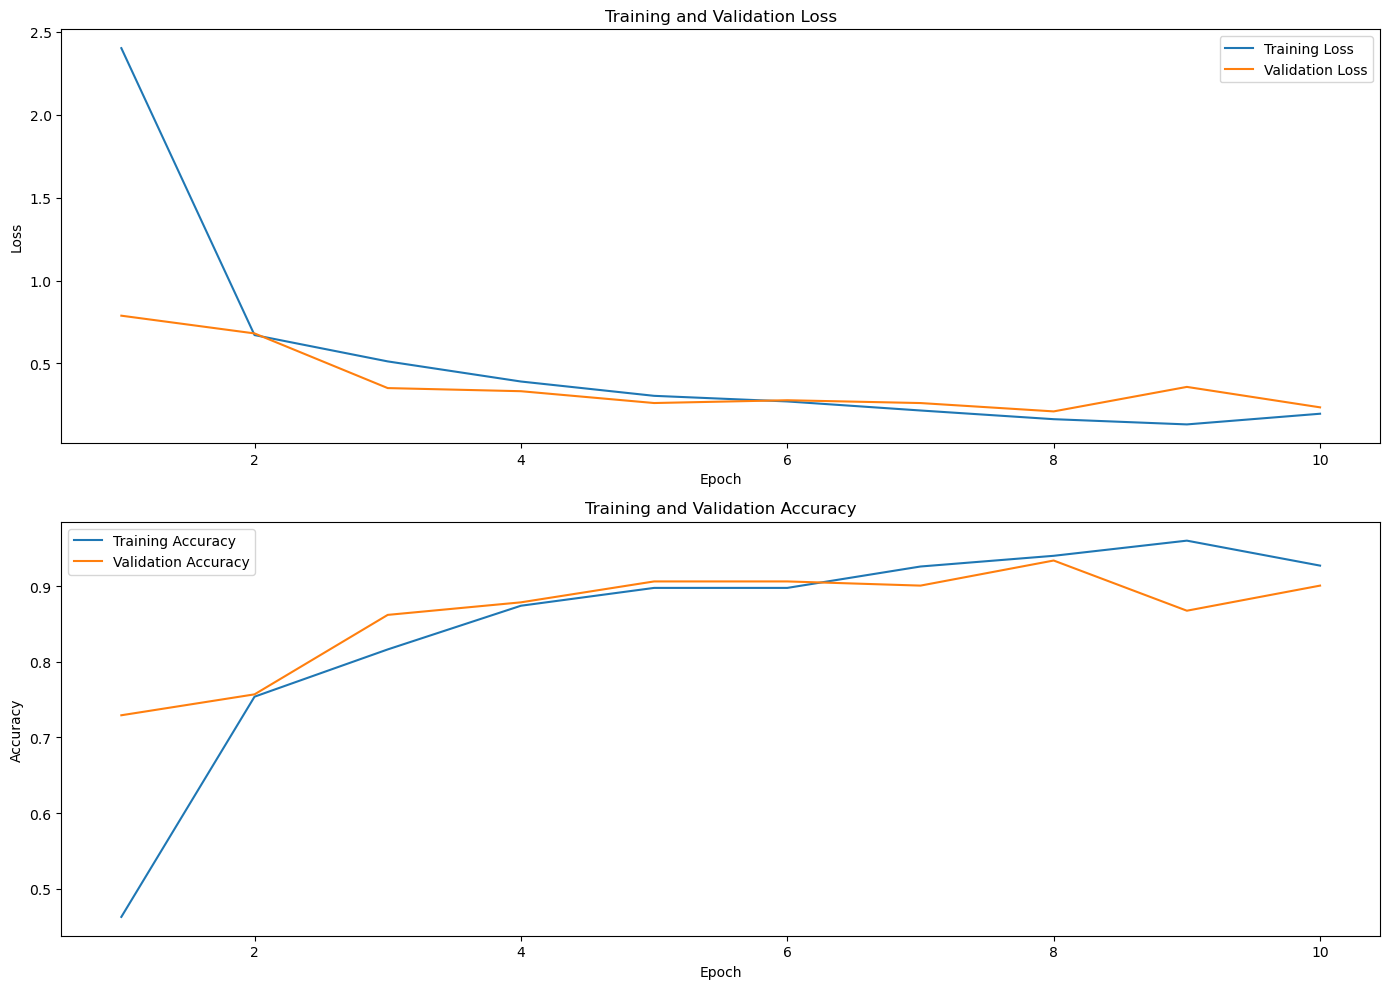

Test Loss: 0.2946927923088272, Test Accuracy: 0.912568306010929
************************************************************************
************************************************************************
Experiment: 2
batch_size= 16
learning_rate= 0.001
hidden_layers= [512]
dropout_rate= 0.3
Epoch 0, Train Loss: 2.7222437461217246, Train Accuracy: 0.4098939929328622, Val Loss: 0.8618326336145401, Val Accuracy: 0.7237569060773481
Epoch 1, Train Loss: 0.8164987161203667, Train Accuracy: 0.7067137809187279, Val Loss: 0.6807672207554182, Val Accuracy: 0.7624309392265194
Epoch 2, Train Loss: 0.598200122549854, Train Accuracy: 0.7797408716136631, Val Loss: 0.43913697451353073, Val Accuracy: 0.861878453038674
Epoch 3, Train Loss: 0.5457580808067212, Train Accuracy: 0.8056537102473498, Val Loss: 0.42368433872858685, Val Accuracy: 0.856353591160221
Epoch 4, Train Loss: 0.4473709449585941, Train Accuracy: 0.8327444051825678, Val Loss: 0.29676394319782656, Val Accuracy: 0.9005524861878453
E

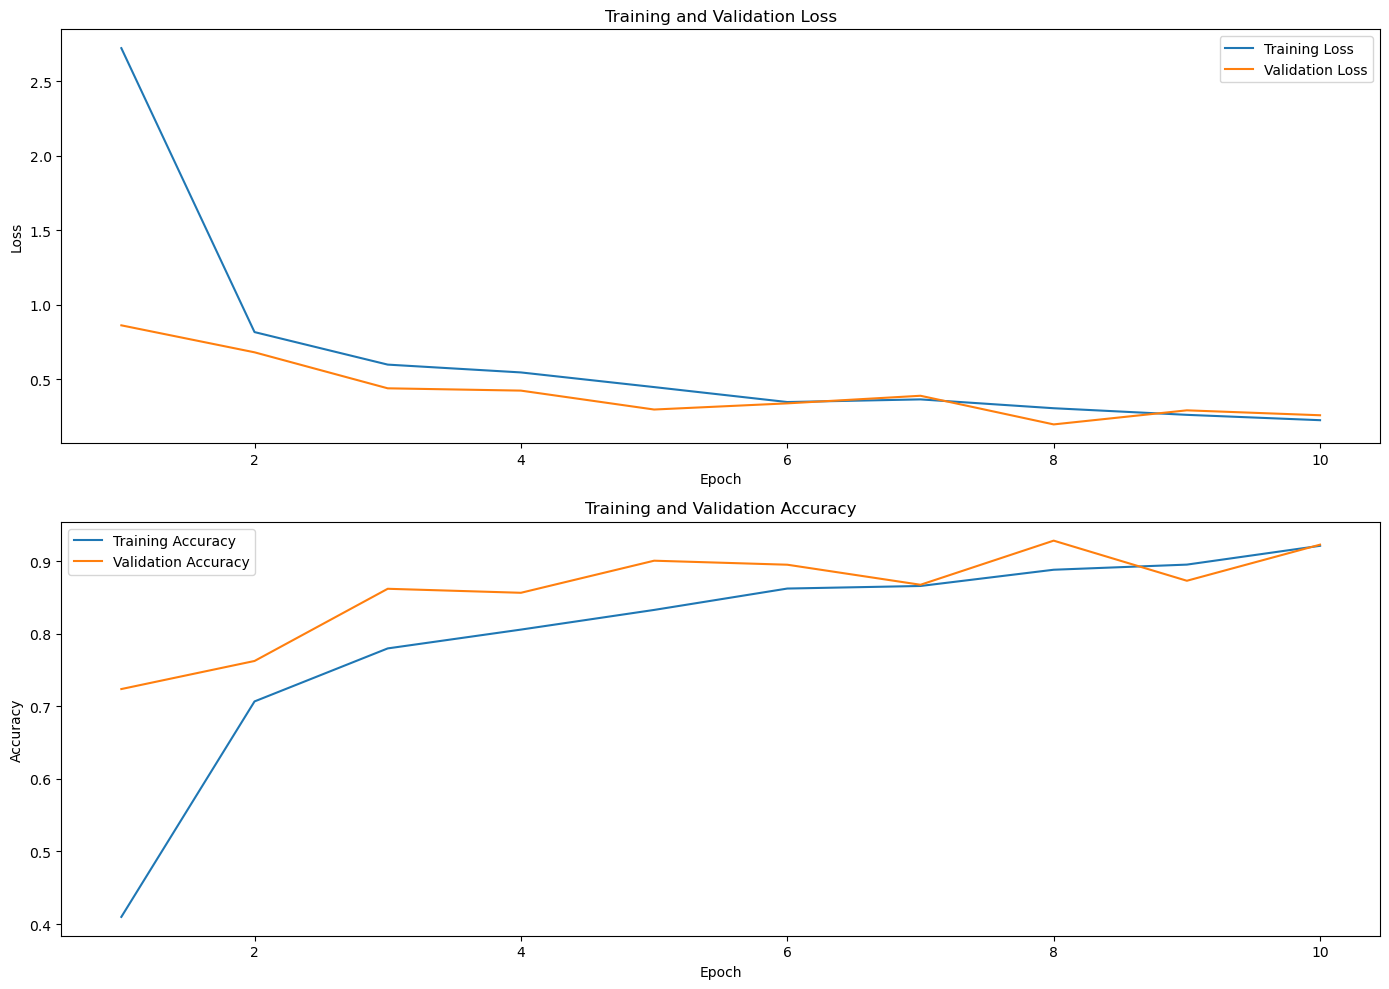

Test Loss: 0.3271496510133147, Test Accuracy: 0.8907103825136612
************************************************************************
************************************************************************
Experiment: 3
batch_size= 16
learning_rate= 0.001
hidden_layers= [512]
dropout_rate= 0.5
Epoch 0, Train Loss: 2.689400276100194, Train Accuracy: 0.41460541813898705, Val Loss: 0.9730407247940699, Val Accuracy: 0.6519337016574586
Epoch 1, Train Loss: 0.961549429429902, Train Accuracy: 0.6325088339222615, Val Loss: 0.8329084366559982, Val Accuracy: 0.7182320441988951
Epoch 2, Train Loss: 0.7767553831692096, Train Accuracy: 0.71849234393404, Val Loss: 0.5536569183071455, Val Accuracy: 0.850828729281768
Epoch 3, Train Loss: 0.7043901900588362, Train Accuracy: 0.7361601884570083, Val Loss: 0.4978763423860073, Val Accuracy: 0.8232044198895028
Epoch 4, Train Loss: 0.6017606887552474, Train Accuracy: 0.7868080094228505, Val Loss: 0.4358300156891346, Val Accuracy: 0.8729281767955801
Epoc

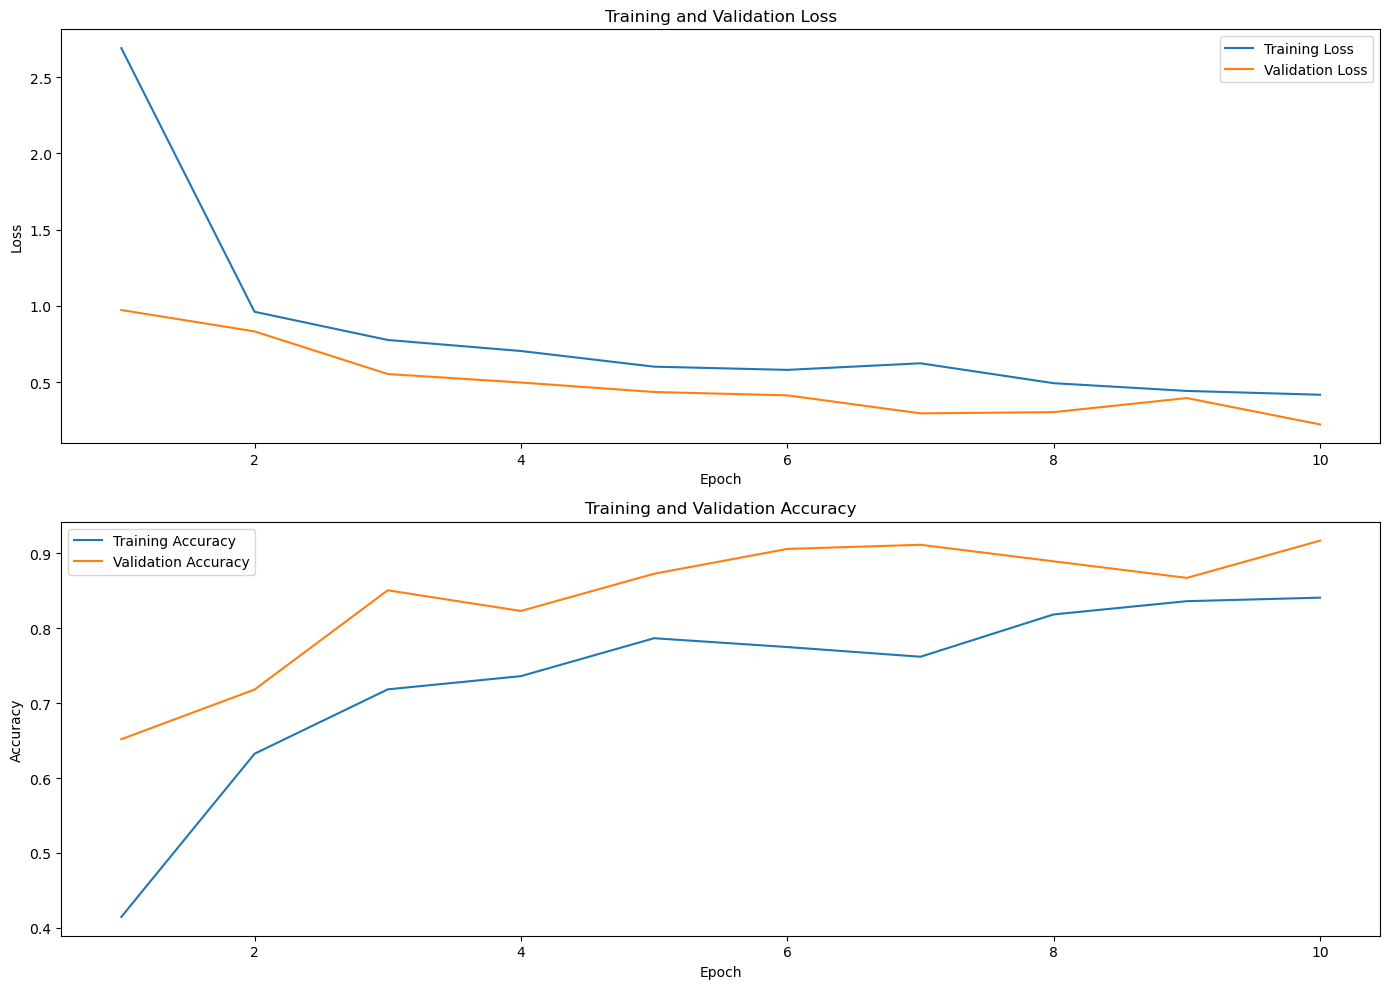

Test Loss: 0.3367013225021462, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 4
batch_size= 16
learning_rate= 0.001
hidden_layers= [512]
dropout_rate= 0.7
Epoch 0, Train Loss: 3.7816464923046254, Train Accuracy: 0.36395759717314485, Val Loss: 1.0216628462076187, Val Accuracy: 0.6685082872928176
Epoch 1, Train Loss: 1.2358260496898934, Train Accuracy: 0.5371024734982333, Val Loss: 0.8840002218882242, Val Accuracy: 0.7348066298342542
Epoch 2, Train Loss: 1.0650971697436438, Train Accuracy: 0.5653710247349824, Val Loss: 0.7178899496793747, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 1.0605712864134047, Train Accuracy: 0.5889281507656066, Val Loss: 0.7152970507740974, Val Accuracy: 0.8176795580110497
Epoch 4, Train Loss: 0.971111958777463, Train Accuracy: 0.6230859835100118, Val Loss: 0.6277874310811361, Val Accuracy: 0.8287292817679558


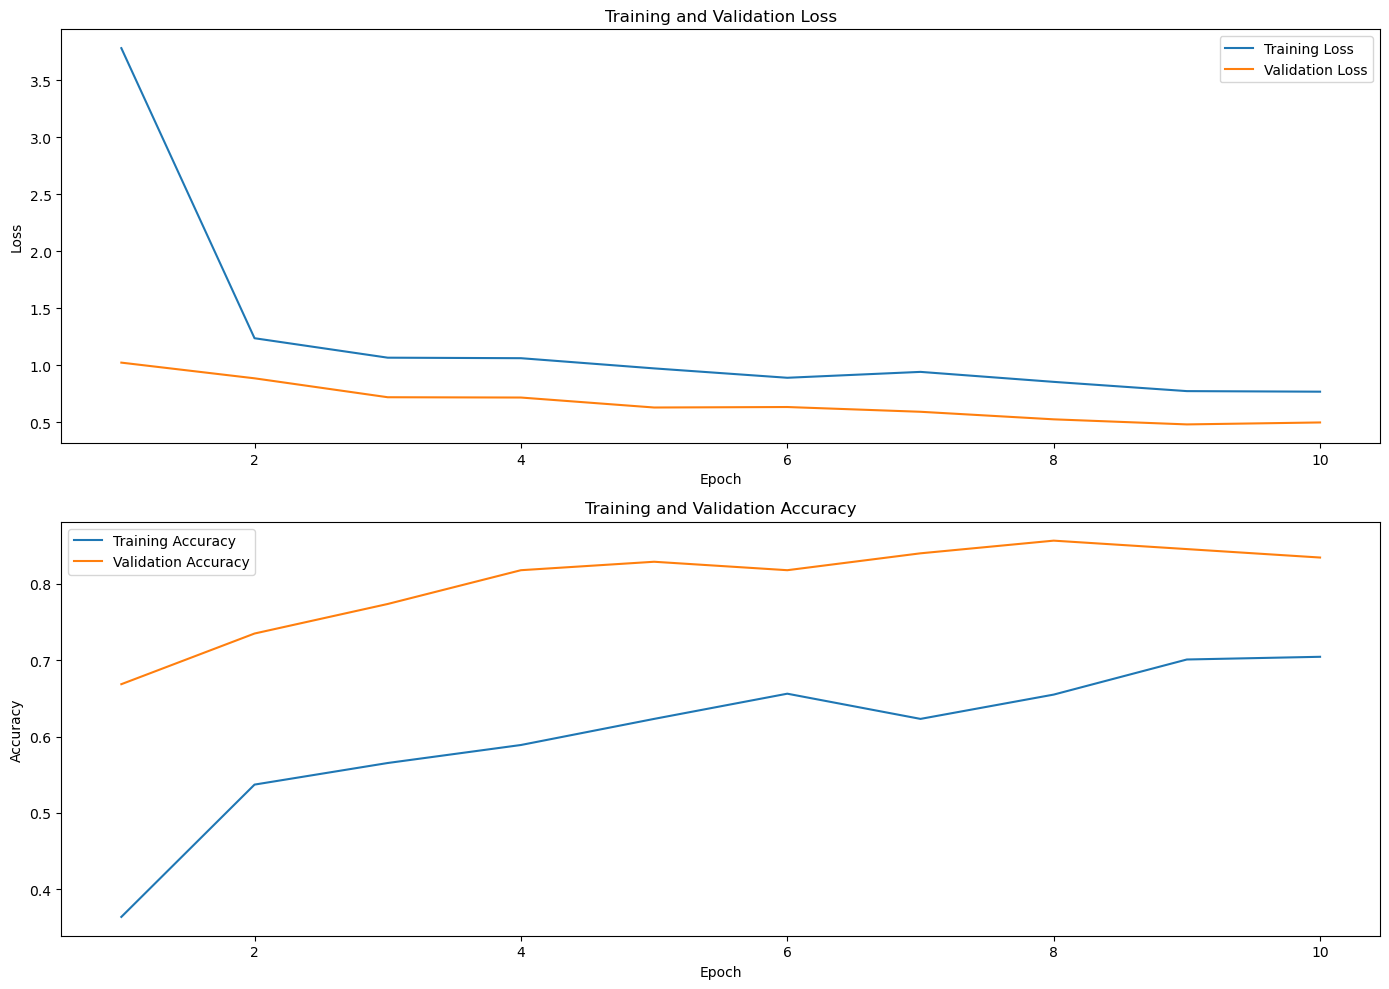

Test Loss: 0.5196176171302795, Test Accuracy: 0.819672131147541
************************************************************************
************************************************************************
Experiment: 5
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024]
dropout_rate= 0.1
Epoch 0, Train Loss: 2.825121918210277, Train Accuracy: 0.47703180212014135, Val Loss: 0.7384974310795466, Val Accuracy: 0.7237569060773481
Epoch 1, Train Loss: 0.7430495581141224, Train Accuracy: 0.7373380447585395, Val Loss: 0.5198060770829519, Val Accuracy: 0.8121546961325967
Epoch 2, Train Loss: 0.5102832303554924, Train Accuracy: 0.8209658421672555, Val Loss: 0.4775085560977459, Val Accuracy: 0.8232044198895028
Epoch 3, Train Loss: 0.3541780655030851, Train Accuracy: 0.8786808009422851, Val Loss: 0.2969941745201747, Val Accuracy: 0.9116022099447514
Epoch 4, Train Loss: 0.32999750557872987, Train Accuracy: 0.8775029446407538, Val Loss: 0.31438648452361423, Val Accuracy: 0.856353591160221

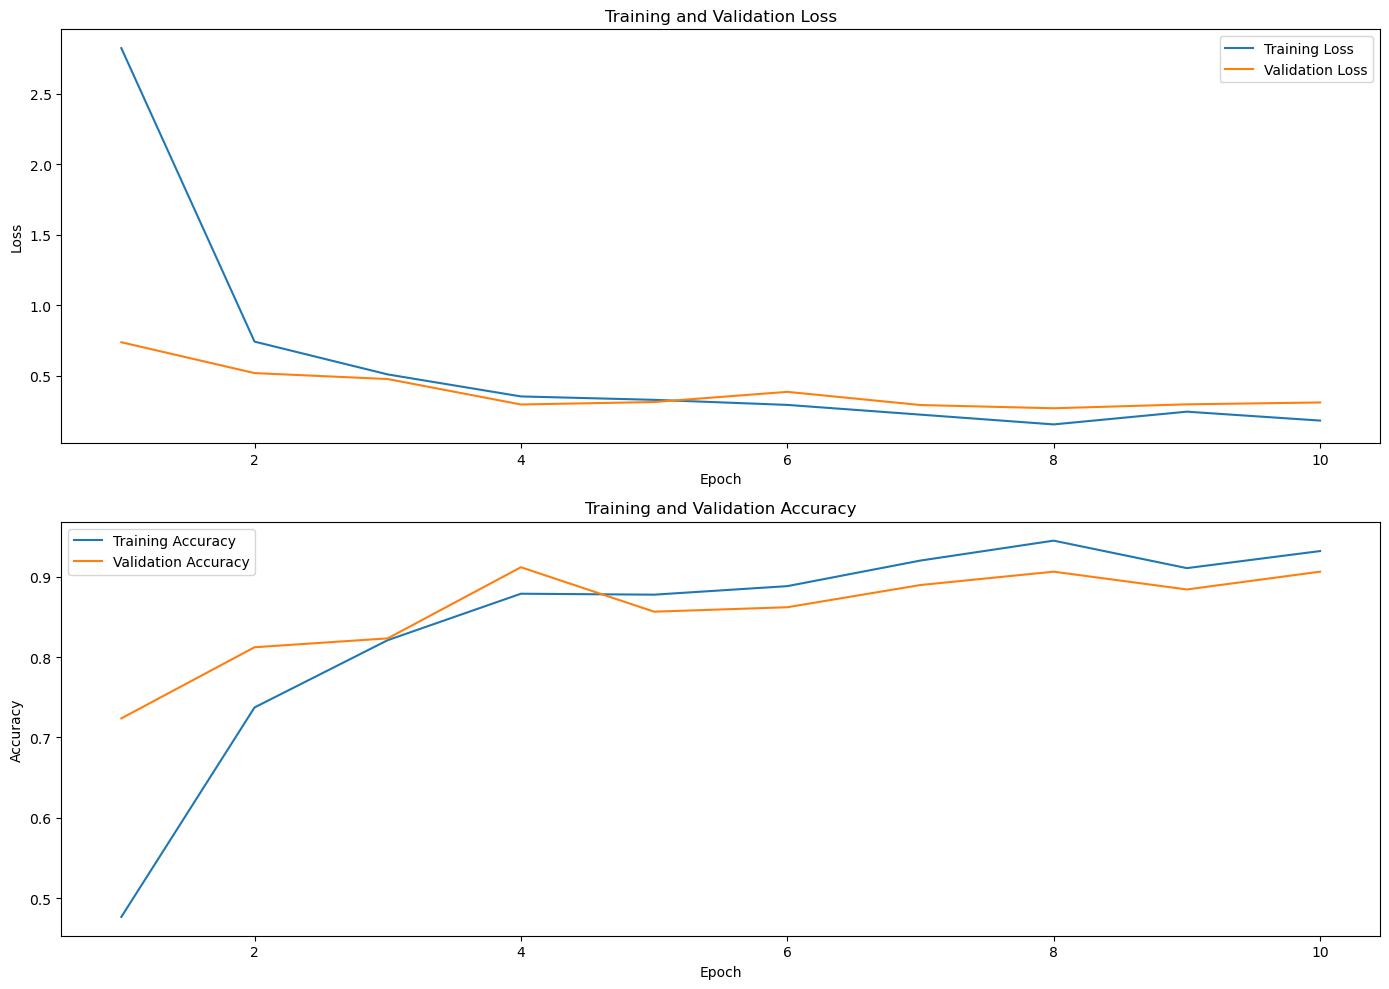

Test Loss: 0.36974056104857783, Test Accuracy: 0.8688524590163934
************************************************************************
************************************************************************
Experiment: 6
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024]
dropout_rate= 0.3
Epoch 0, Train Loss: 3.0258714026874967, Train Accuracy: 0.4746760895170789, Val Loss: 0.7941767300168673, Val Accuracy: 0.6850828729281768
Epoch 1, Train Loss: 0.7921356658140818, Train Accuracy: 0.6925795053003534, Val Loss: 0.5423151875535647, Val Accuracy: 0.8121546961325967
Epoch 2, Train Loss: 0.5605145698344266, Train Accuracy: 0.790341578327444, Val Loss: 0.5287477696935335, Val Accuracy: 0.8121546961325967
Epoch 3, Train Loss: 0.4419491174975755, Train Accuracy: 0.8551236749116607, Val Loss: 0.39629576727747917, Val Accuracy: 0.8729281767955801
Epoch 4, Train Loss: 0.4289674811341144, Train Accuracy: 0.8303886925795053, Val Loss: 0.39321530144661665, Val Accuracy: 0.85635359116022

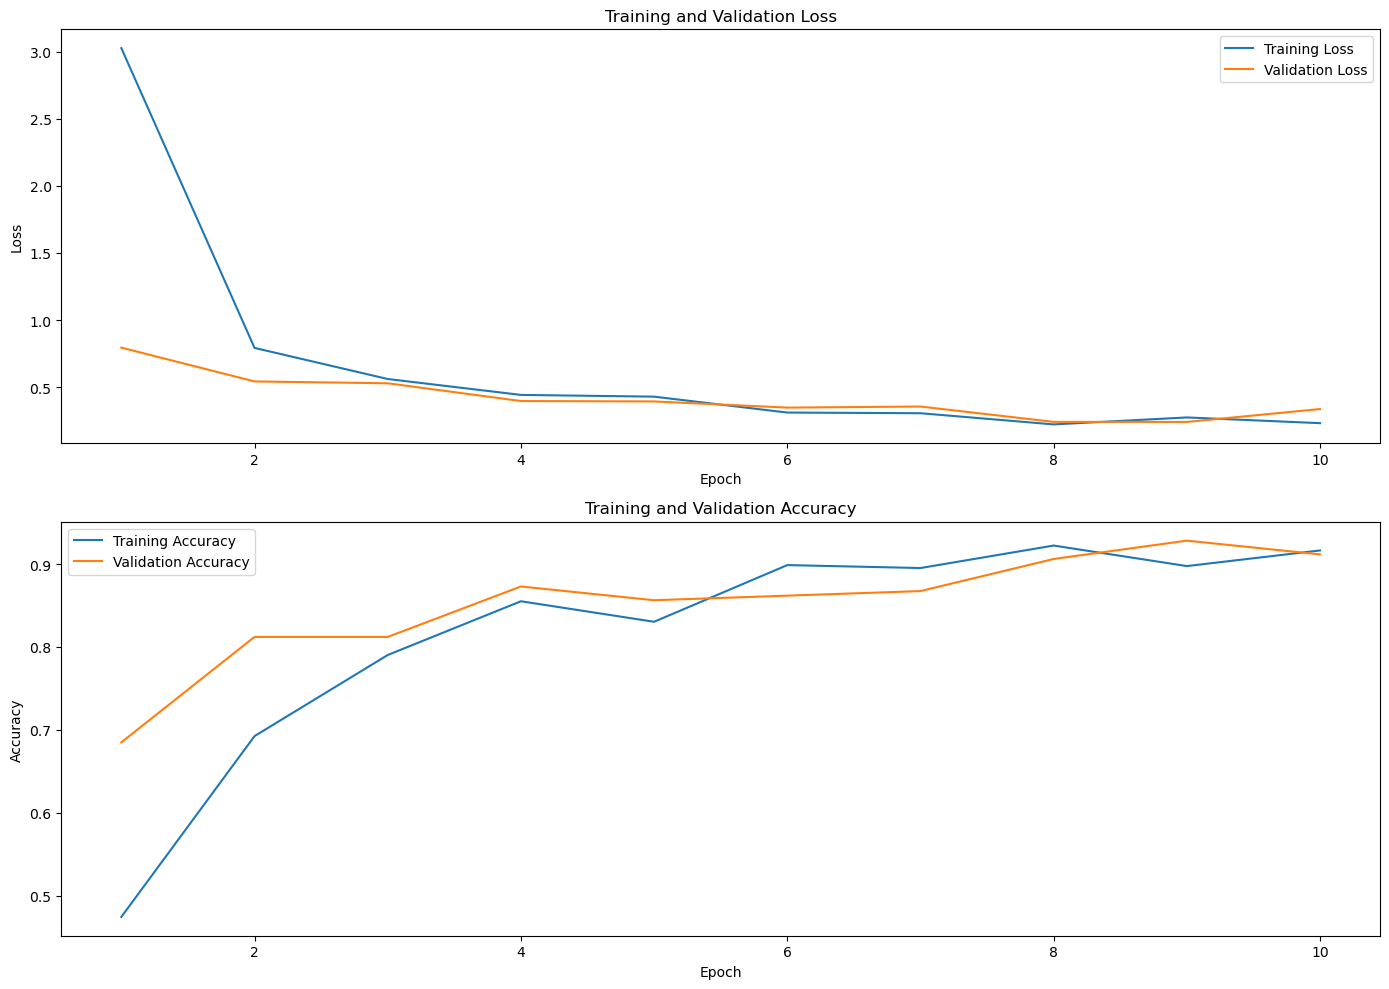

Test Loss: 0.32127365718285245, Test Accuracy: 0.907103825136612
************************************************************************
************************************************************************
Experiment: 7
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024]
dropout_rate= 0.5
Epoch 0, Train Loss: 3.8403032273054123, Train Accuracy: 0.44051825677267376, Val Loss: 0.7523765216271082, Val Accuracy: 0.6961325966850829
Epoch 1, Train Loss: 0.969942096206877, Train Accuracy: 0.6171967020023557, Val Loss: 0.6917694335182508, Val Accuracy: 0.712707182320442
Epoch 2, Train Loss: 0.7788309305906296, Train Accuracy: 0.702002355712603, Val Loss: 0.6819380819797516, Val Accuracy: 0.7569060773480663
Epoch 3, Train Loss: 0.7282146309260968, Train Accuracy: 0.7361601884570083, Val Loss: 0.489622184385856, Val Accuracy: 0.8729281767955801
Epoch 4, Train Loss: 0.5707105182939105, Train Accuracy: 0.7773851590106007, Val Loss: 0.43329466817279655, Val Accuracy: 0.8453038674033149
E

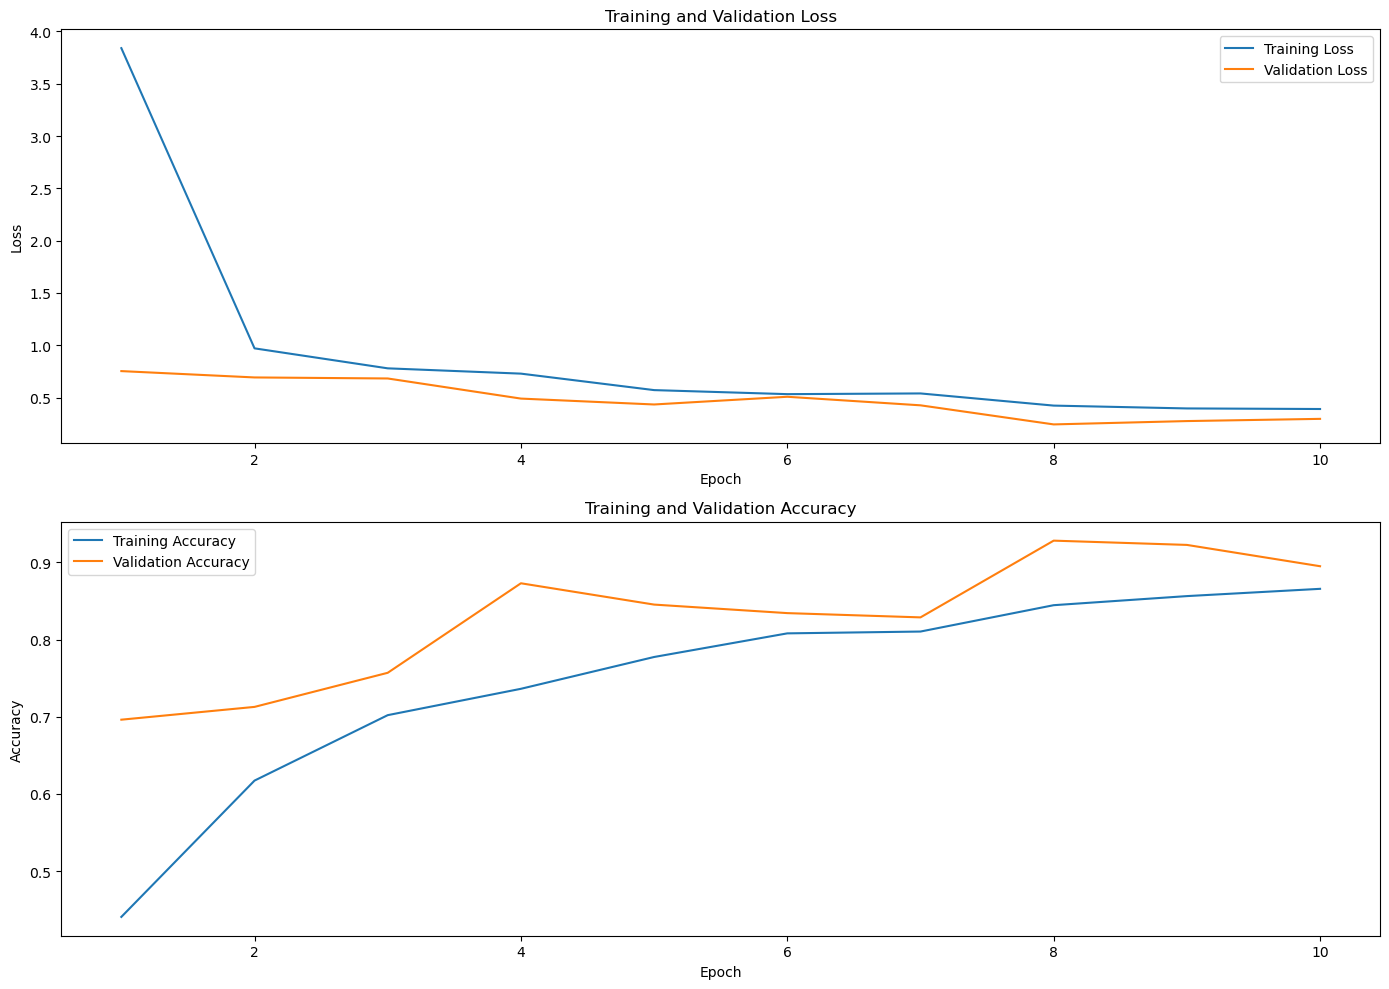

Test Loss: 0.30187025868023437, Test Accuracy: 0.8852459016393442
************************************************************************
************************************************************************
Experiment: 8
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024]
dropout_rate= 0.7
Epoch 0, Train Loss: 5.072237410161136, Train Accuracy: 0.37691401648998824, Val Loss: 1.137534312903881, Val Accuracy: 0.6574585635359116
Epoch 1, Train Loss: 1.3384722068353936, Train Accuracy: 0.5865724381625441, Val Loss: 0.7885881811380386, Val Accuracy: 0.6795580110497238
Epoch 2, Train Loss: 0.9614133027692636, Train Accuracy: 0.6313309776207303, Val Loss: 0.6534393727779388, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 0.8638084930781689, Train Accuracy: 0.6760895170789164, Val Loss: 0.5855360279480616, Val Accuracy: 0.7734806629834254
Epoch 4, Train Loss: 0.8870284148940334, Train Accuracy: 0.6914016489988222, Val Loss: 0.5349372227986654, Val Accuracy: 0.7624309392265194

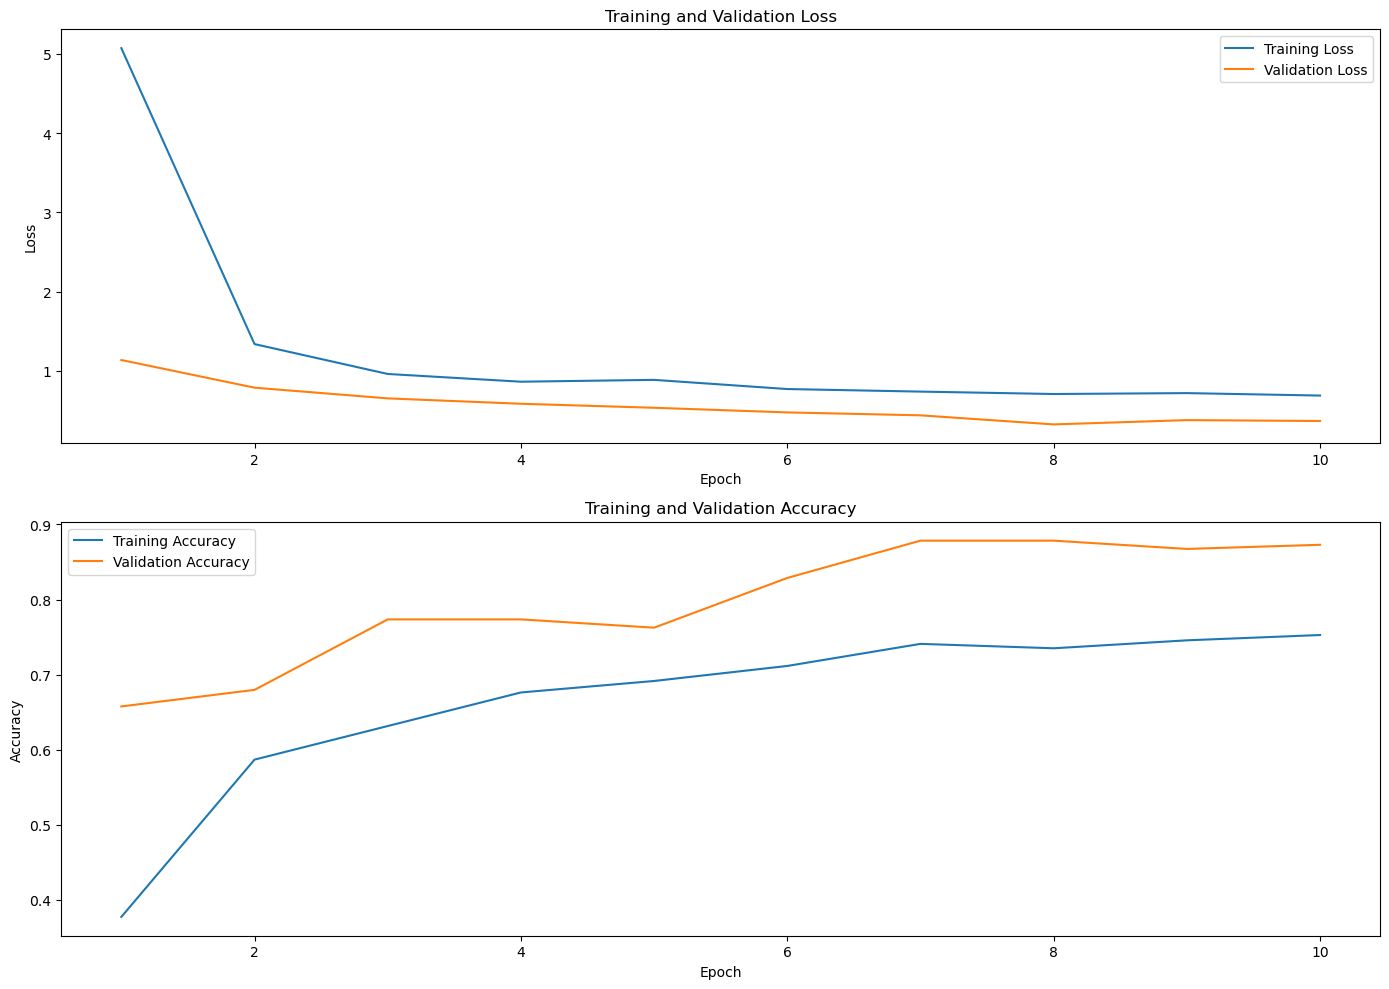

Test Loss: 0.42498862867554027, Test Accuracy: 0.819672131147541
************************************************************************
************************************************************************
Experiment: 9
batch_size= 16
learning_rate= 0.001
hidden_layers= [512, 256]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.5079307558911819, Train Accuracy: 0.42638398115429915, Val Loss: 0.816752498348554, Val Accuracy: 0.7569060773480663
Epoch 1, Train Loss: 0.7978372703547831, Train Accuracy: 0.6972909305064782, Val Loss: 0.9230111440022787, Val Accuracy: 0.712707182320442
Epoch 2, Train Loss: 0.6259199567139149, Train Accuracy: 0.7691401648998822, Val Loss: 0.47274237498641014, Val Accuracy: 0.8287292817679558
Epoch 3, Train Loss: 0.43442505570473494, Train Accuracy: 0.8362779740871613, Val Loss: 0.3506416790187359, Val Accuracy: 0.8839779005524862
Epoch 4, Train Loss: 0.4891157544873379, Train Accuracy: 0.8386336866902238, Val Loss: 0.4103429814179738, Val Accuracy: 0.87845303867

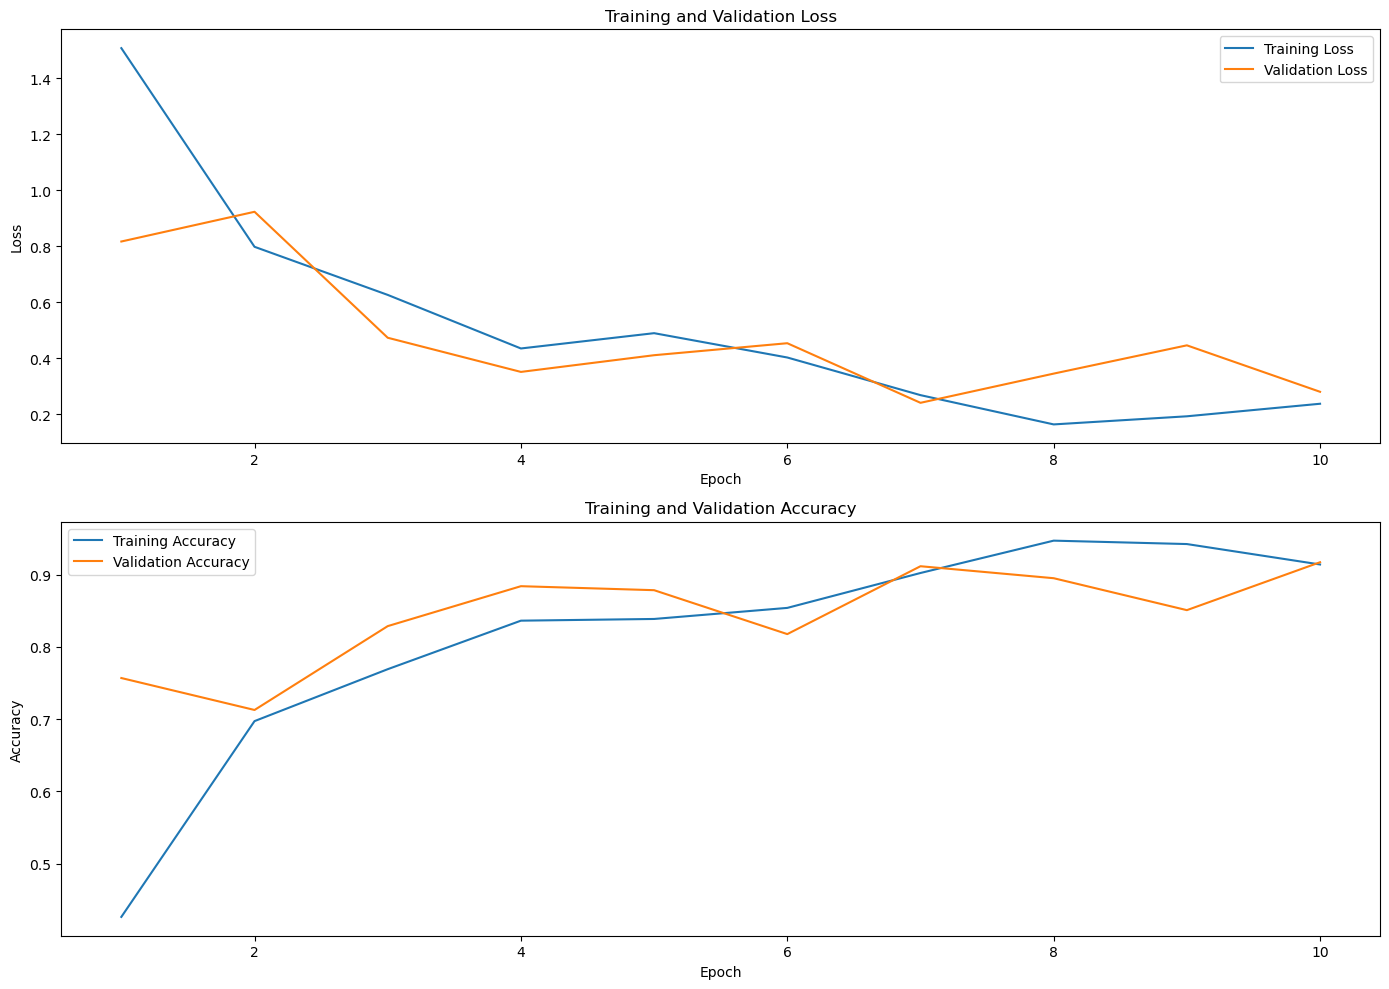

Test Loss: 0.2053726346542438, Test Accuracy: 0.9016393442622951
************************************************************************
************************************************************************
Experiment: 10
batch_size= 16
learning_rate= 0.001
hidden_layers= [512, 256]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.6875067640233923, Train Accuracy: 0.375736160188457, Val Loss: 0.9074903378883997, Val Accuracy: 0.7182320441988951
Epoch 1, Train Loss: 1.0282607509030237, Train Accuracy: 0.6160188457008245, Val Loss: 1.0062755296627681, Val Accuracy: 0.5911602209944752
Epoch 2, Train Loss: 0.8811906253298124, Train Accuracy: 0.6560659599528857, Val Loss: 0.636318584283193, Val Accuracy: 0.7900552486187845
Epoch 3, Train Loss: 0.6362427691066707, Train Accuracy: 0.7656065959952886, Val Loss: 0.41804763426383335, Val Accuracy: 0.8674033149171271
Epoch 4, Train Loss: 0.6043360688620143, Train Accuracy: 0.800942285041225, Val Loss: 0.48632774377862614, Val Accuracy: 0.806629834254

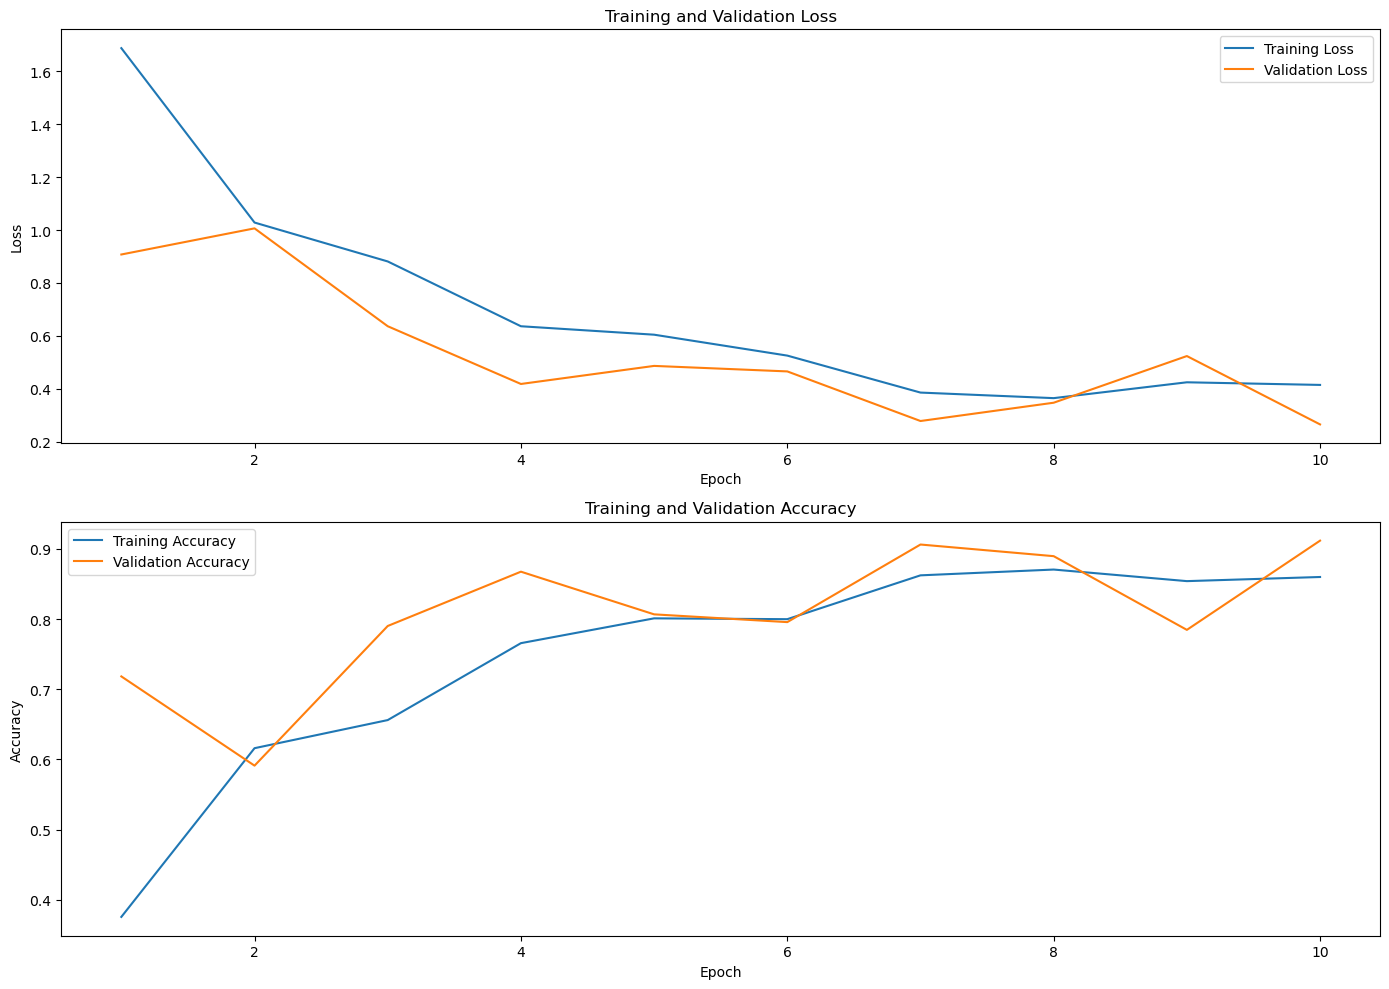

Test Loss: 0.32627426863958436, Test Accuracy: 0.8961748633879781
************************************************************************
************************************************************************
Experiment: 11
batch_size= 16
learning_rate= 0.001
hidden_layers= [512, 256]
dropout_rate= 0.5
Epoch 0, Train Loss: 2.0146131997031196, Train Accuracy: 0.30742049469964666, Val Loss: 1.1297987749179204, Val Accuracy: 0.6408839779005525
Epoch 1, Train Loss: 1.23061243141139, Train Accuracy: 0.4876325088339223, Val Loss: 0.903168057401975, Val Accuracy: 0.7237569060773481
Epoch 2, Train Loss: 1.1298185719384088, Train Accuracy: 0.558303886925795, Val Loss: 0.7710175290703773, Val Accuracy: 0.7679558011049724
Epoch 3, Train Loss: 0.9421678856015205, Train Accuracy: 0.6525323910482921, Val Loss: 0.6210489844282469, Val Accuracy: 0.7955801104972375
Epoch 4, Train Loss: 0.9039189329853764, Train Accuracy: 0.6760895170789164, Val Loss: 0.6305120090643564, Val Accuracy: 0.7403314917127

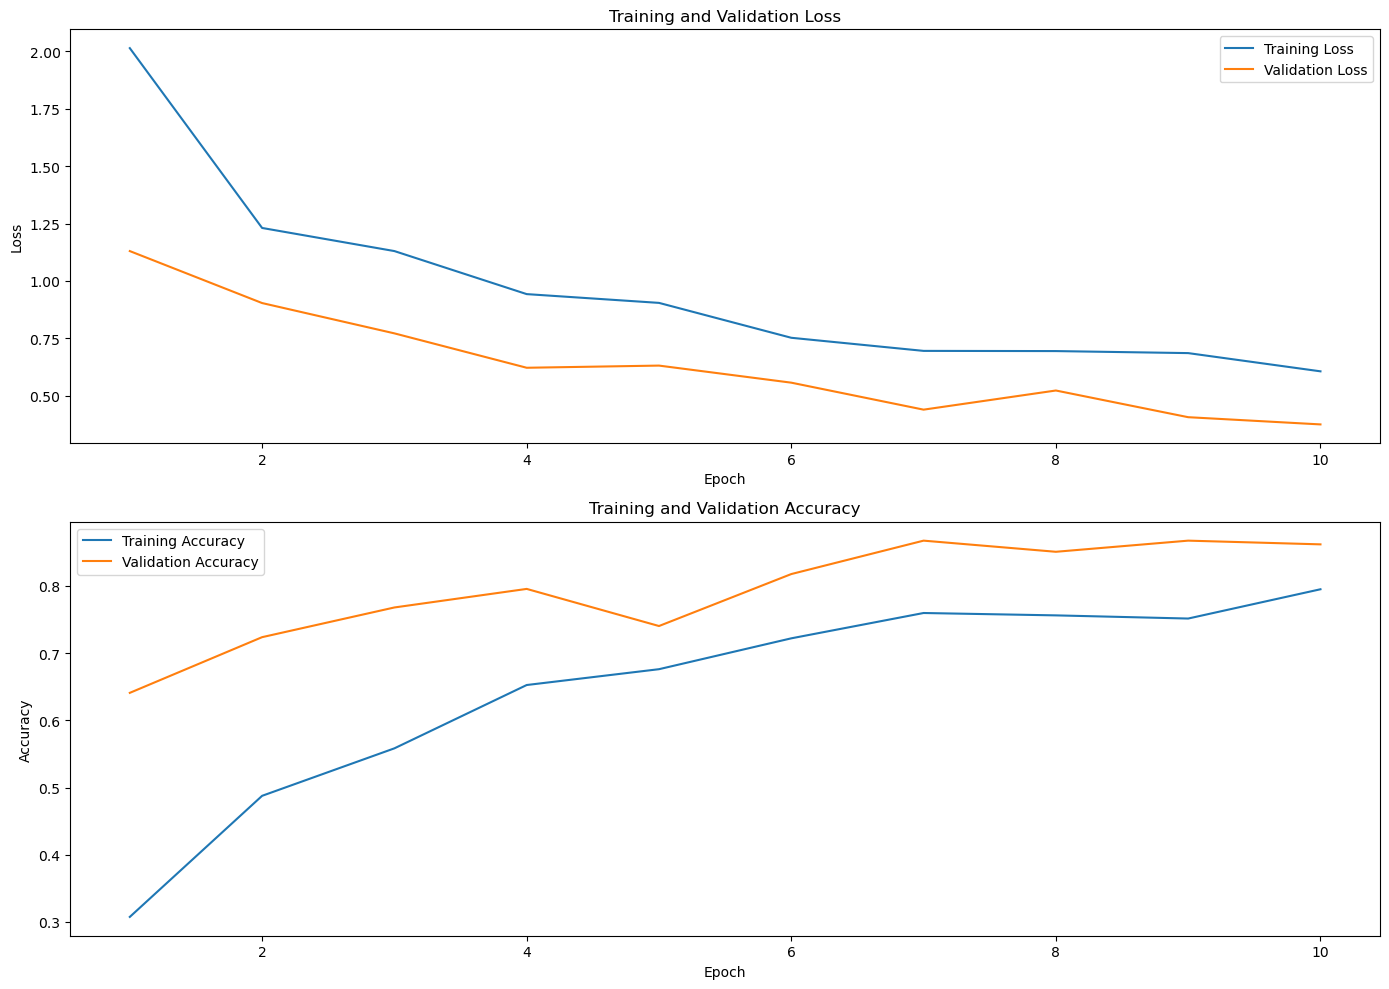

Test Loss: 0.45983612909913063, Test Accuracy: 0.8415300546448088
************************************************************************
************************************************************************
Experiment: 12
batch_size= 16
learning_rate= 0.001
hidden_layers= [512, 256]
dropout_rate= 0.7
Epoch 0, Train Loss: 2.997992013339643, Train Accuracy: 0.22379269729093051, Val Loss: 1.4890028635660808, Val Accuracy: 0.425414364640884
Epoch 1, Train Loss: 1.6185929709010654, Train Accuracy: 0.29093050647820967, Val Loss: 1.367994139591853, Val Accuracy: 0.5193370165745856
Epoch 2, Train Loss: 1.556220915582445, Train Accuracy: 0.3168433451118963, Val Loss: 1.2649668256441753, Val Accuracy: 0.6298342541436464
Epoch 3, Train Loss: 1.4853100688369185, Train Accuracy: 0.39693757361601884, Val Loss: 1.220657467842102, Val Accuracy: 0.580110497237569
Epoch 4, Train Loss: 1.4080980111051489, Train Accuracy: 0.4075382803297998, Val Loss: 1.1292674094438553, Val Accuracy: 0.6187845303867

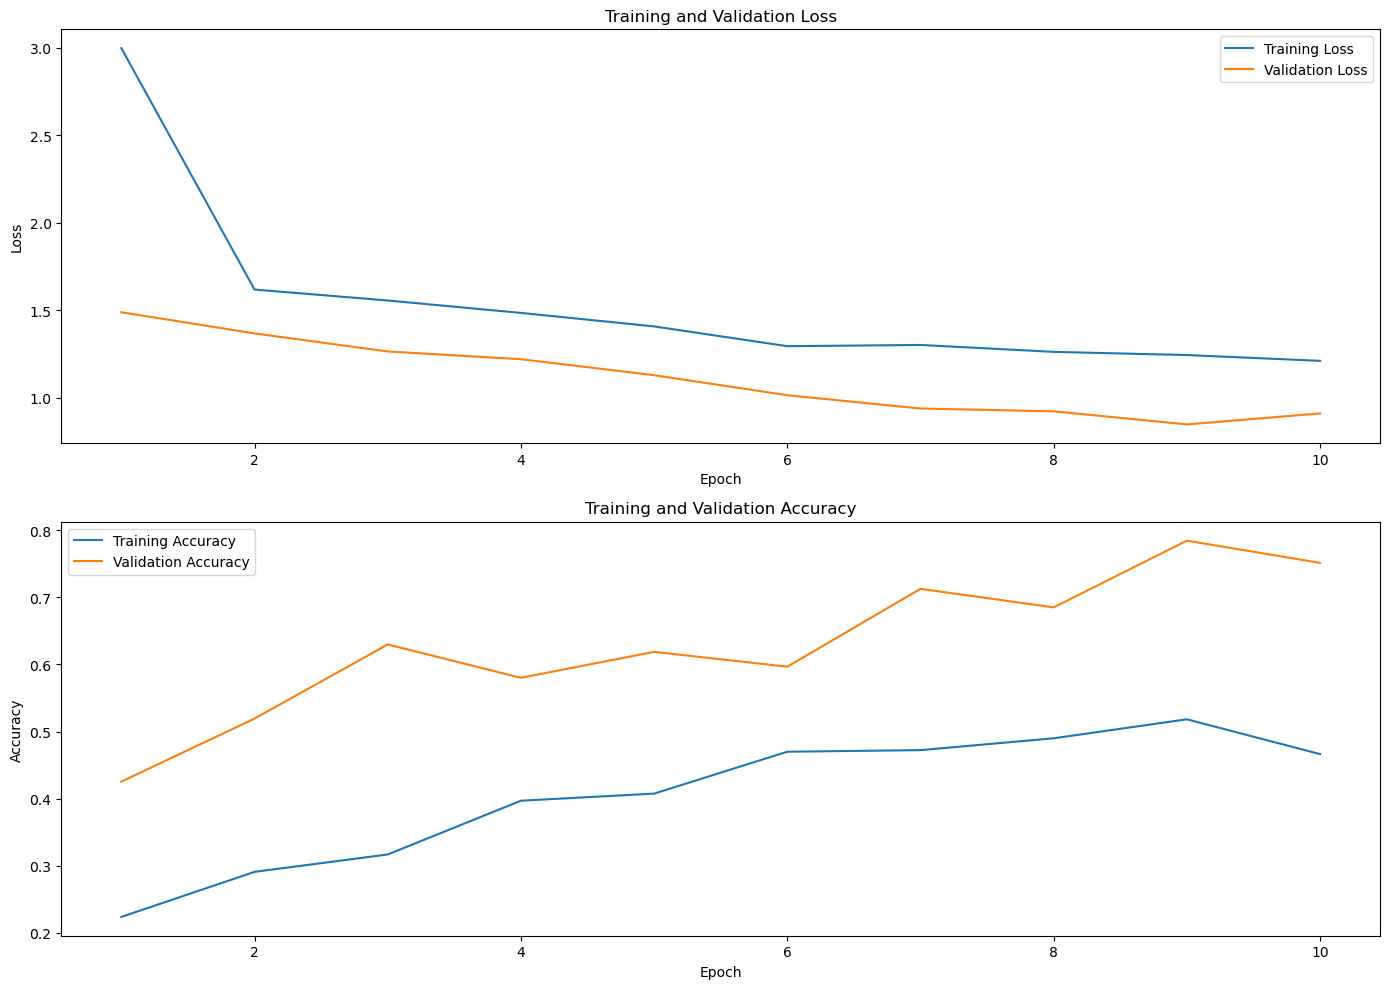

Test Loss: 0.9609651813904444, Test Accuracy: 0.6885245901639344
************************************************************************
************************************************************************
Experiment: 13
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024, 512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.6383452117443085, Train Accuracy: 0.43462897526501765, Val Loss: 1.0191866606473923, Val Accuracy: 0.580110497237569
Epoch 1, Train Loss: 0.7863726061941297, Train Accuracy: 0.6972909305064782, Val Loss: 0.8660064538319906, Val Accuracy: 0.7016574585635359
Epoch 2, Train Loss: 0.5684254637195004, Train Accuracy: 0.8044758539458187, Val Loss: 0.5610902905464172, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 0.48768548832999337, Train Accuracy: 0.8362779740871613, Val Loss: 0.3947371530036132, Val Accuracy: 0.850828729281768
Epoch 4, Train Loss: 0.4323152596199954, Train Accuracy: 0.8527679623085983, Val Loss: 0.3224320001900196, Val Accuracy: 0.8950276243

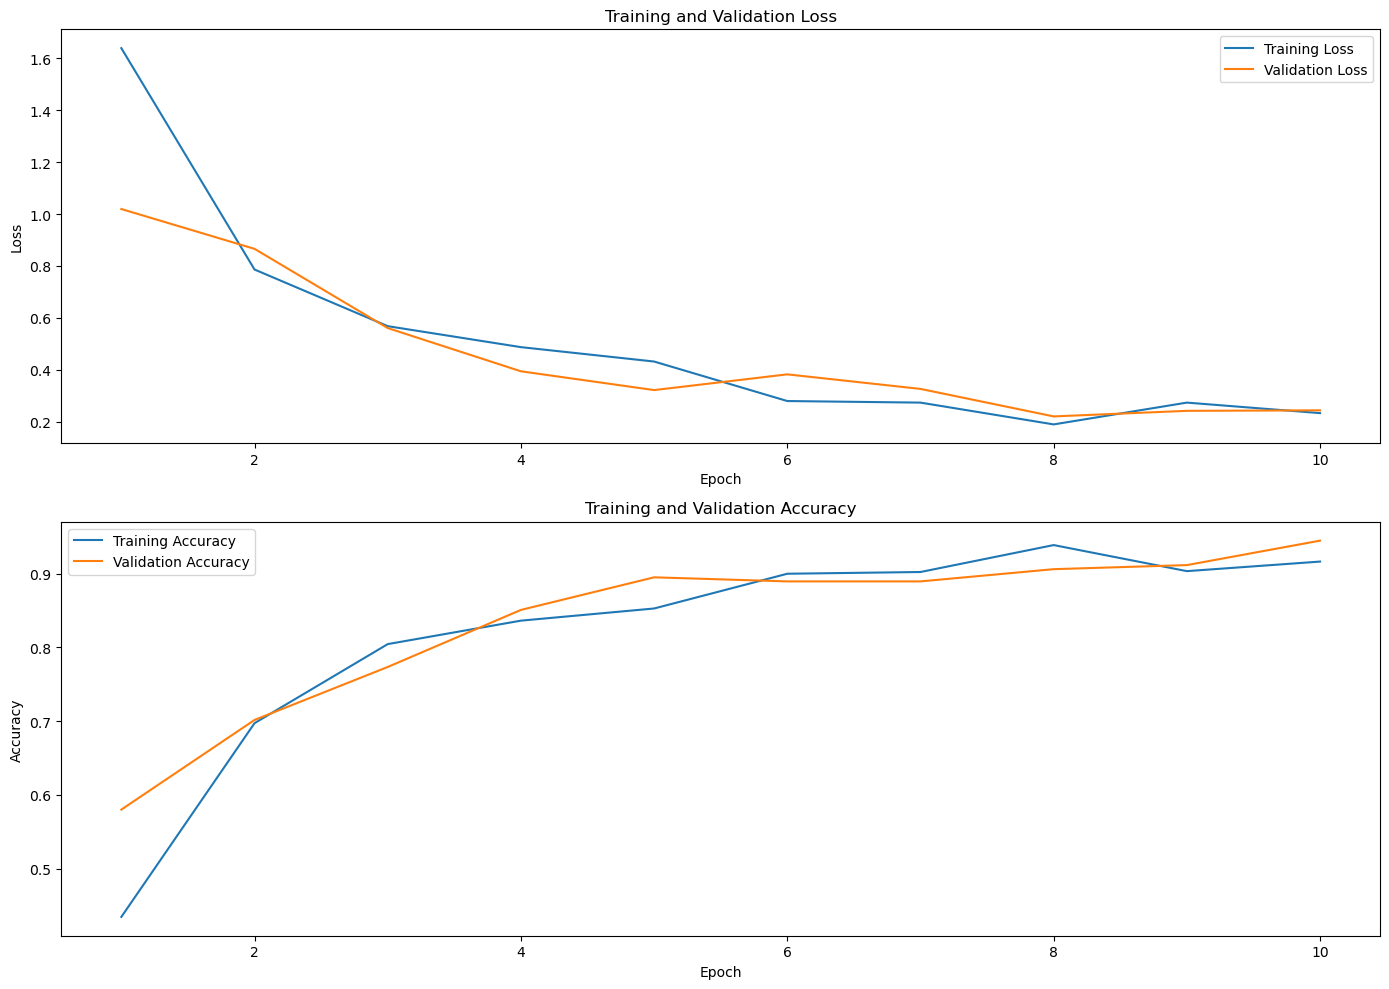

Test Loss: 0.20826463028788567, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 14
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024, 512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.9317267956557098, Train Accuracy: 0.3828032979976443, Val Loss: 1.0326781868934631, Val Accuracy: 0.56353591160221
Epoch 1, Train Loss: 0.9786319479829183, Train Accuracy: 0.6065959952885748, Val Loss: 0.8818651437759399, Val Accuracy: 0.6740331491712708
Epoch 2, Train Loss: 0.7472084114948908, Train Accuracy: 0.7373380447585395, Val Loss: 0.6828623662392298, Val Accuracy: 0.7403314917127072
Epoch 3, Train Loss: 0.59818788010765, Train Accuracy: 0.7868080094228505, Val Loss: 0.4239304394771655, Val Accuracy: 0.8342541436464088
Epoch 4, Train Loss: 0.5628170371055603, Train Accuracy: 0.8080094228504122, Val Loss: 0.5241366997361183, Val Accuracy: 0.8176795580110

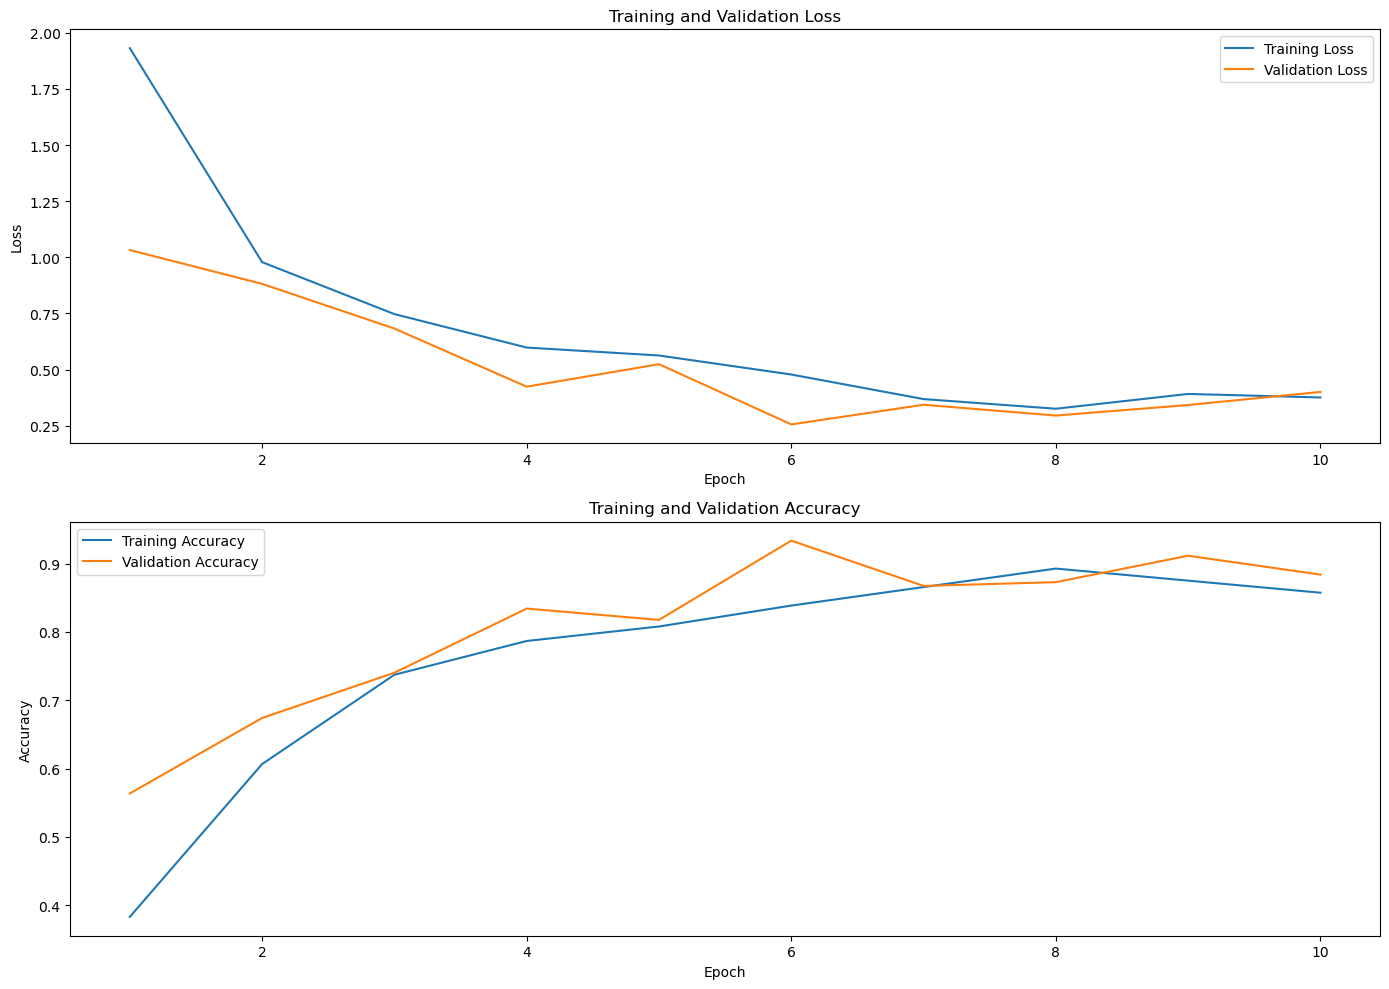

Test Loss: 0.3012087283035119, Test Accuracy: 0.8907103825136612
************************************************************************
************************************************************************
Experiment: 15
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024, 512]
dropout_rate= 0.5
Epoch 0, Train Loss: 2.43923752396195, Train Accuracy: 0.32037691401649, Val Loss: 1.1263362020254135, Val Accuracy: 0.56353591160221
Epoch 1, Train Loss: 1.1359777868621879, Train Accuracy: 0.5394581861012956, Val Loss: 0.9288089623053869, Val Accuracy: 0.6850828729281768
Epoch 2, Train Loss: 1.0150793145100276, Train Accuracy: 0.6336866902237926, Val Loss: 0.7896049618721008, Val Accuracy: 0.6740331491712708
Epoch 3, Train Loss: 0.8528527004851235, Train Accuracy: 0.6666666666666666, Val Loss: 0.6112884109218916, Val Accuracy: 0.7679558011049724
Epoch 4, Train Loss: 0.7753506931993697, Train Accuracy: 0.7243816254416962, Val Loss: 0.4482145185271899, Val Accuracy: 0.861878453038674


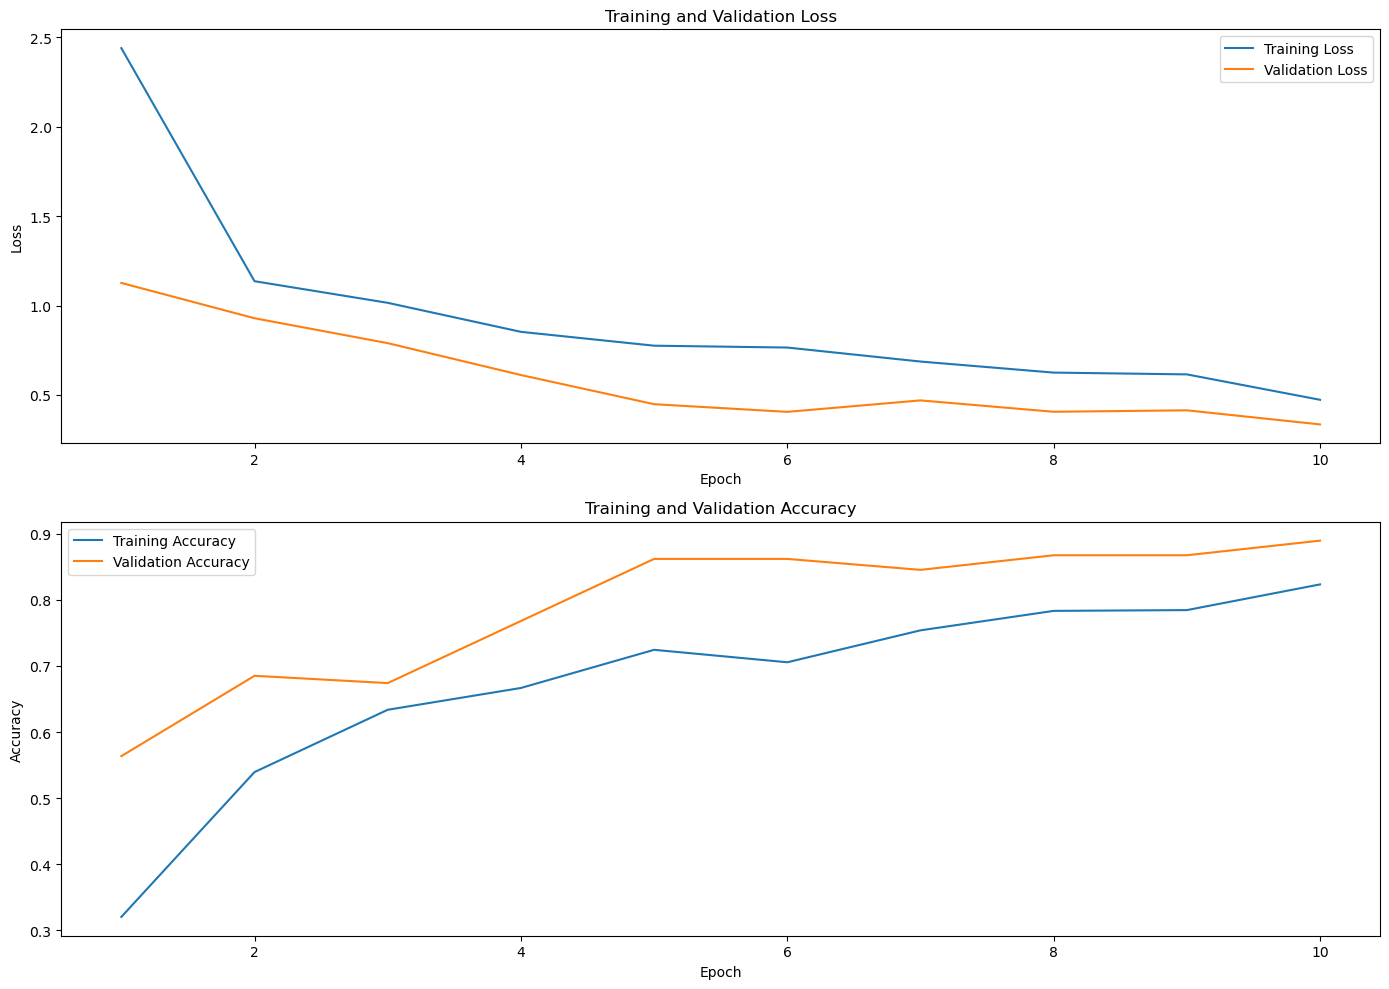

Test Loss: 0.3655615436534087, Test Accuracy: 0.8633879781420765
************************************************************************
************************************************************************
Experiment: 16
batch_size= 16
learning_rate= 0.001
hidden_layers= [1024, 512]
dropout_rate= 0.7
Epoch 0, Train Loss: 4.234406186474694, Train Accuracy: 0.2226148409893993, Val Loss: 1.2704853117465973, Val Accuracy: 0.5469613259668509
Epoch 1, Train Loss: 1.676756252017286, Train Accuracy: 0.3545347467608952, Val Loss: 1.2018503149350483, Val Accuracy: 0.585635359116022
Epoch 2, Train Loss: 1.3889477363339178, Train Accuracy: 0.46996466431095407, Val Loss: 1.1216413229703903, Val Accuracy: 0.6961325966850829
Epoch 3, Train Loss: 1.3120146106790613, Train Accuracy: 0.4793875147232038, Val Loss: 0.9645564456780752, Val Accuracy: 0.7016574585635359
Epoch 4, Train Loss: 1.2997900424180207, Train Accuracy: 0.4758539458186101, Val Loss: 0.9609321157137553, Val Accuracy: 0.707182320441

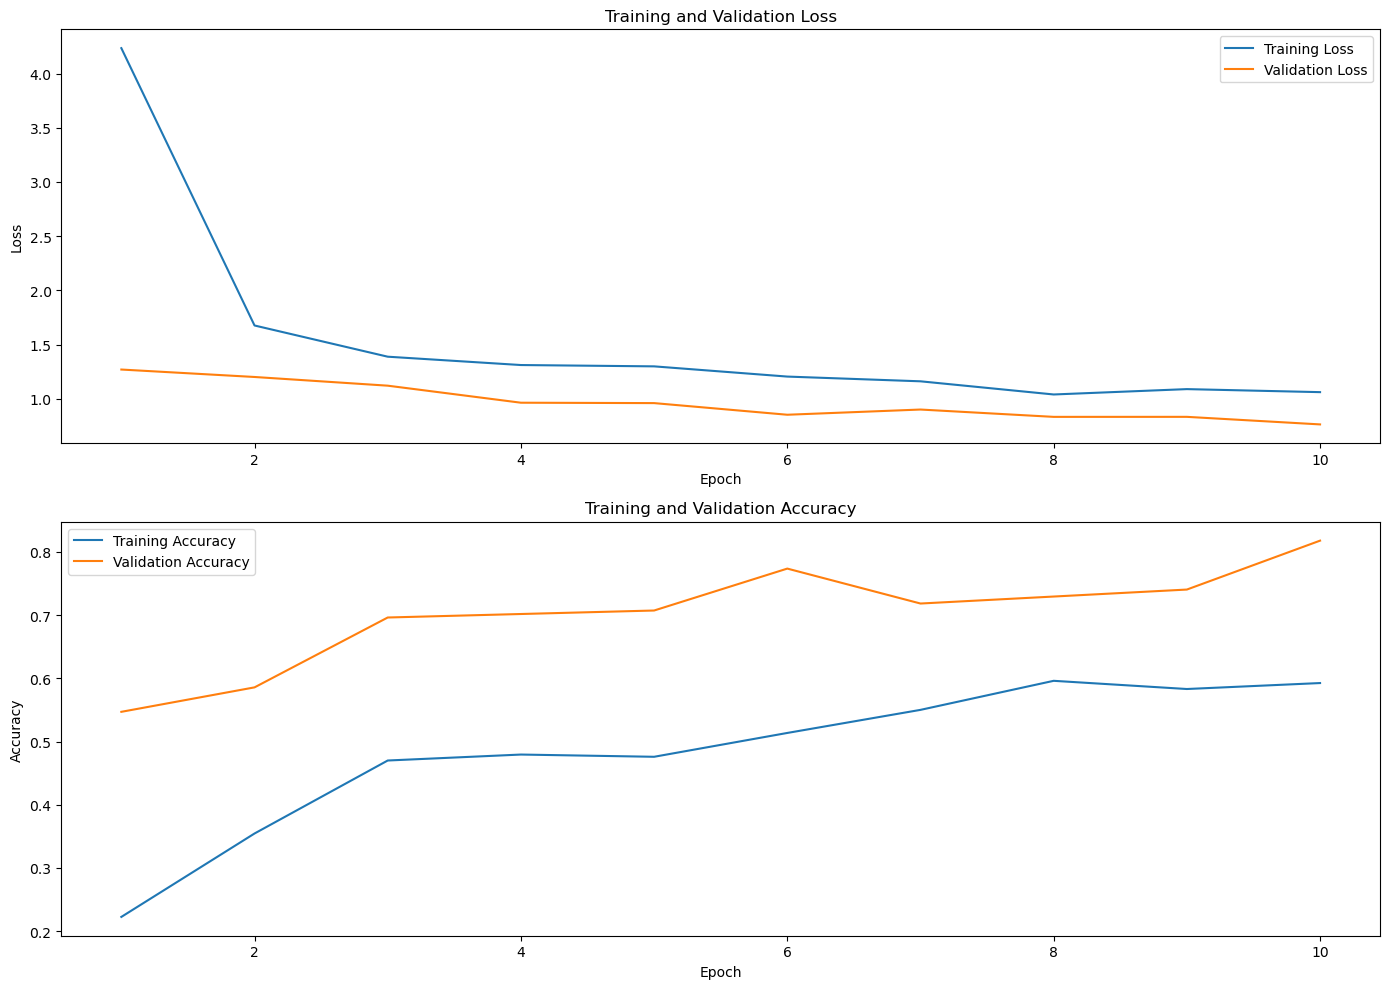

Test Loss: 0.7552044490973154, Test Accuracy: 0.7978142076502732
************************************************************************
************************************************************************
Experiment: 17
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.6061671344494377, Train Accuracy: 0.4923439340400471, Val Loss: 0.7356608435511589, Val Accuracy: 0.7679558011049724
Epoch 1, Train Loss: 0.6377458726918256, Train Accuracy: 0.767962308598351, Val Loss: 0.6008022415141264, Val Accuracy: 0.7955801104972375
Epoch 2, Train Loss: 0.4412852680672788, Train Accuracy: 0.8621908127208481, Val Loss: 0.36576182146867114, Val Accuracy: 0.850828729281768
Epoch 3, Train Loss: 0.37474316924258516, Train Accuracy: 0.8810365135453475, Val Loss: 0.32824521077175933, Val Accuracy: 0.9005524861878453
Epoch 4, Train Loss: 0.27322783328040884, Train Accuracy: 0.917550058892815, Val Loss: 0.24890013256420693, Val Accuracy: 0.9226519337016

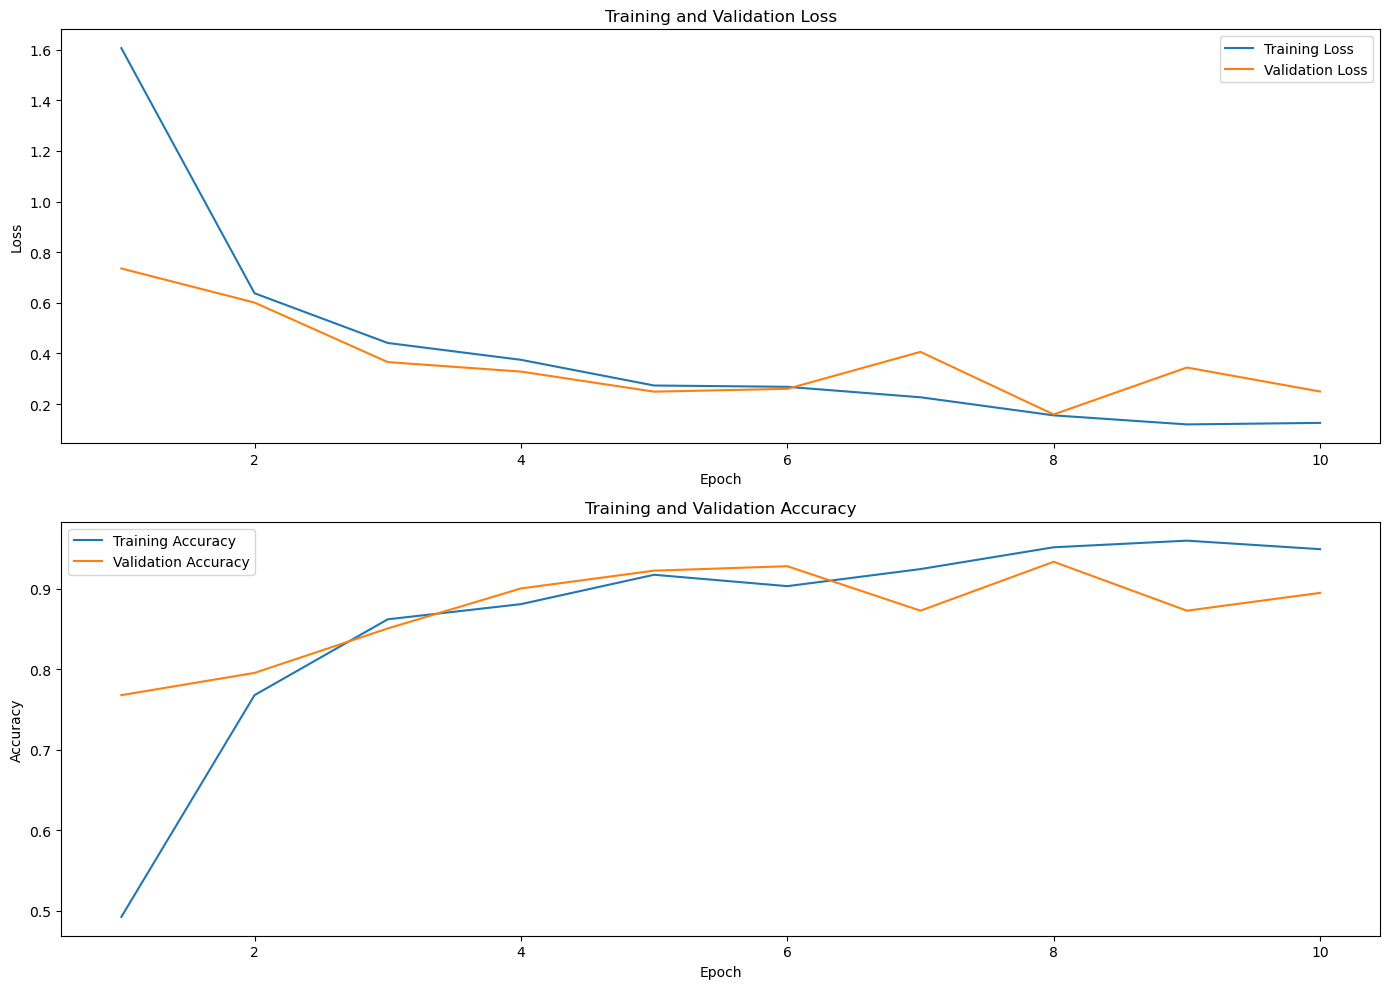

Test Loss: 0.3677685968577862, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 18
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.7520497700682394, Train Accuracy: 0.46760895170789163, Val Loss: 0.7824486245711645, Val Accuracy: 0.7513812154696132
Epoch 1, Train Loss: 0.7286522068359234, Train Accuracy: 0.71849234393404, Val Loss: 0.6377309548358122, Val Accuracy: 0.8011049723756906
Epoch 2, Train Loss: 0.4962122814419369, Train Accuracy: 0.8315665488810365, Val Loss: 0.5116508776942889, Val Accuracy: 0.8287292817679558
Epoch 3, Train Loss: 0.4977263747541993, Train Accuracy: 0.8303886925795053, Val Loss: 0.4056214901308219, Val Accuracy: 0.8839779005524862
Epoch 4, Train Loss: 0.34631564992445485, Train Accuracy: 0.8775029446407538, Val Loss: 0.2959165411690871, Val Accuracy: 0.917127071823204

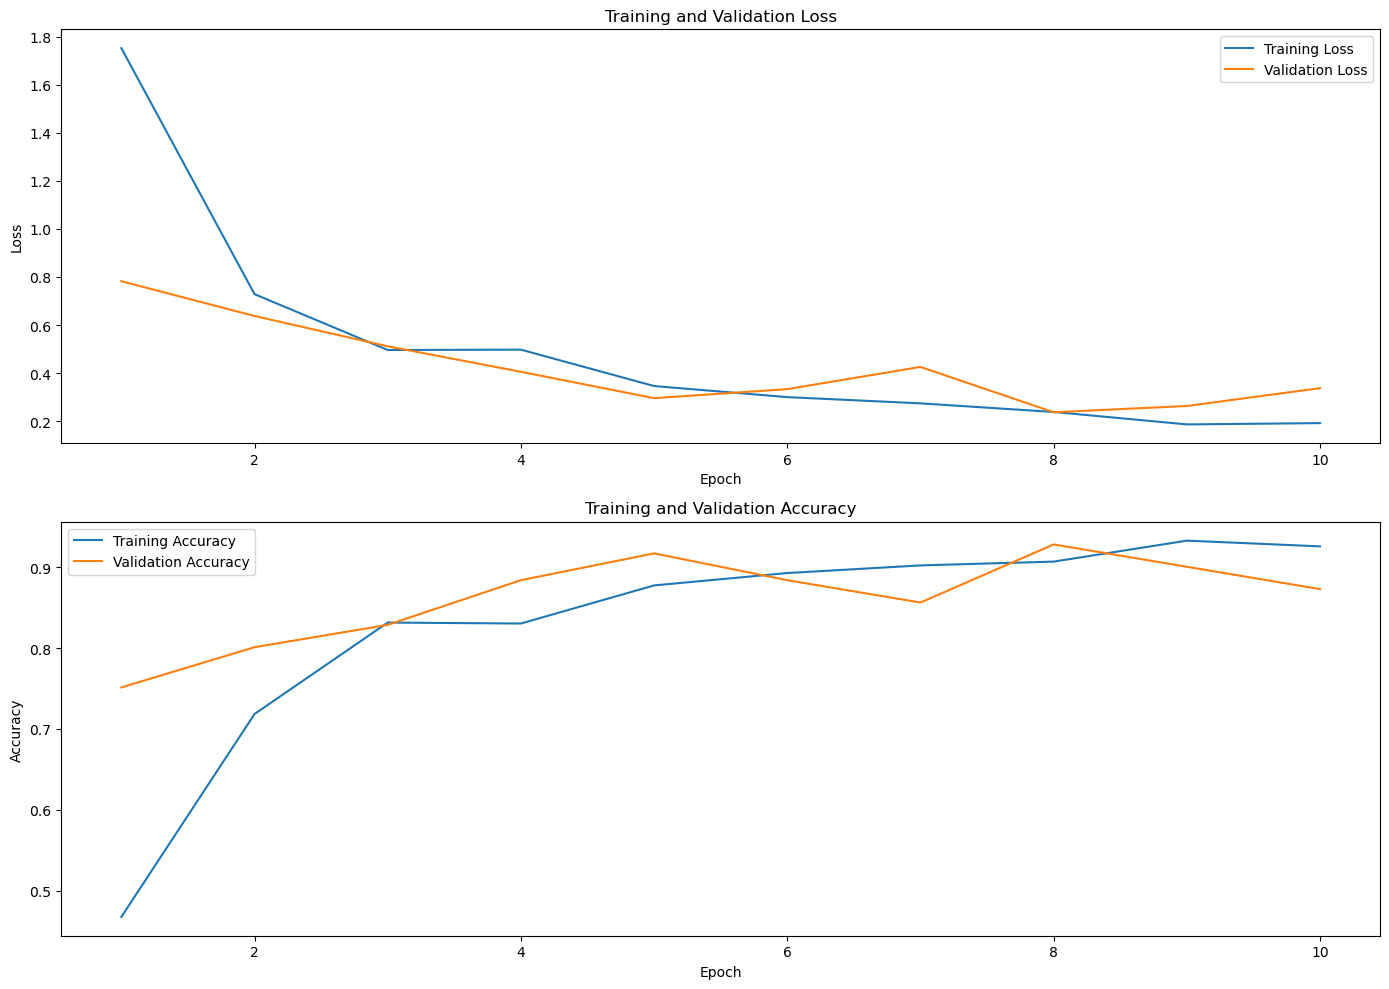

Test Loss: 0.3555835535128911, Test Accuracy: 0.8907103825136612
************************************************************************
************************************************************************
Experiment: 19
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.7398011419508193, Train Accuracy: 0.4381625441696113, Val Loss: 0.818007712562879, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.8825176424450345, Train Accuracy: 0.6749116607773852, Val Loss: 0.6500825683275858, Val Accuracy: 0.7900552486187845
Epoch 2, Train Loss: 0.6862779136885095, Train Accuracy: 0.7491166077738516, Val Loss: 0.4561106190085411, Val Accuracy: 0.8397790055248618
Epoch 3, Train Loss: 0.6230811457391139, Train Accuracy: 0.7644287396937574, Val Loss: 0.4444732467333476, Val Accuracy: 0.8397790055248618
Epoch 4, Train Loss: 0.47878733691242004, Train Accuracy: 0.8303886925795053, Val Loss: 0.35563005817433196, Val Accuracy: 0.87292817679558

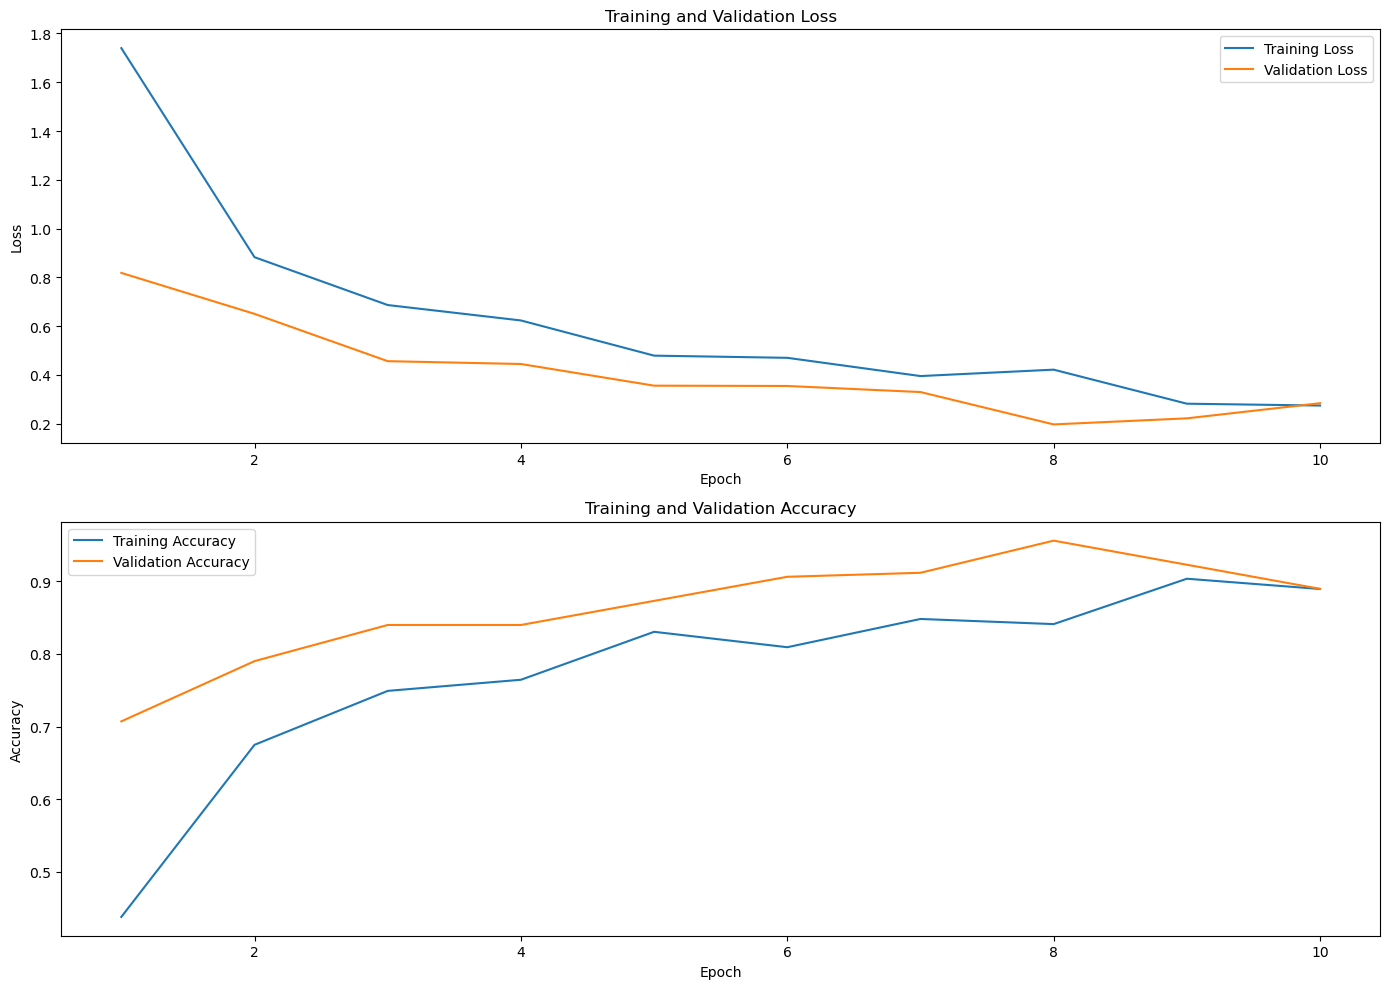

Test Loss: 0.35532752703875303, Test Accuracy: 0.8633879781420765
************************************************************************
************************************************************************
Experiment: 20
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512]
dropout_rate= 0.7
Epoch 0, Train Loss: 2.3448816151530654, Train Accuracy: 0.38869257950530034, Val Loss: 0.9614209334055582, Val Accuracy: 0.6685082872928176
Epoch 1, Train Loss: 1.1034009975415688, Train Accuracy: 0.5842167255594818, Val Loss: 0.8571891387303671, Val Accuracy: 0.7348066298342542
Epoch 2, Train Loss: 1.0018211128535095, Train Accuracy: 0.6230859835100118, Val Loss: 0.7056135386228561, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 0.9360295313375967, Train Accuracy: 0.6254416961130742, Val Loss: 0.5797403454780579, Val Accuracy: 0.8232044198895028
Epoch 4, Train Loss: 0.7562538788274482, Train Accuracy: 0.7290930506478209, Val Loss: 0.5462207024296125, Val Accuracy: 0.8176795580110

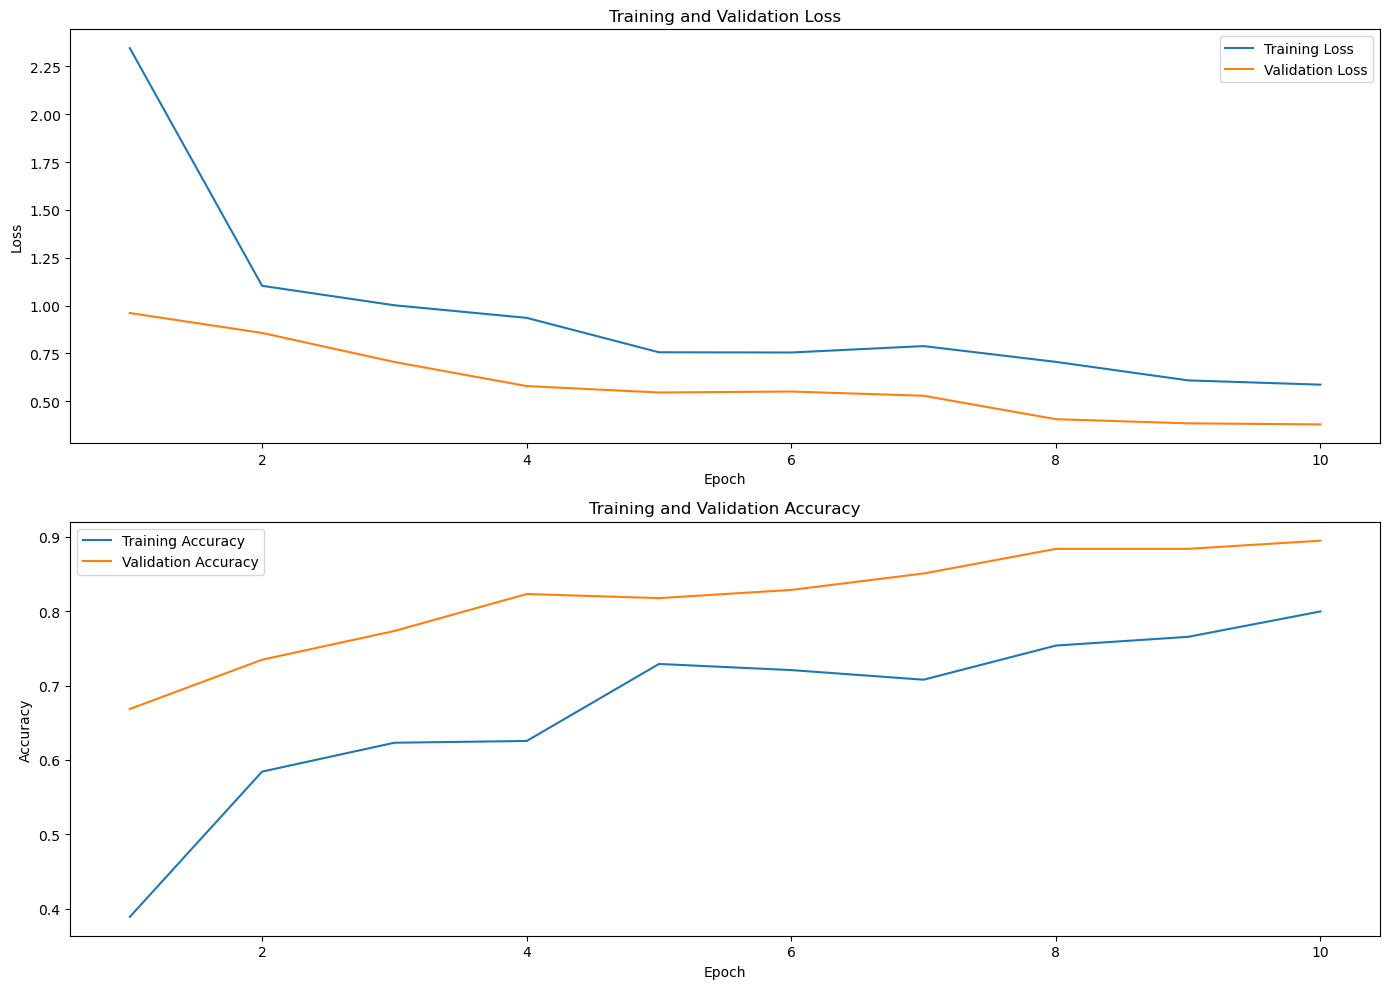

Test Loss: 0.42731665819883347, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 21
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.8577387575749997, Train Accuracy: 0.5041224970553593, Val Loss: 0.6794225225845972, Val Accuracy: 0.7348066298342542
Epoch 1, Train Loss: 0.715837288233969, Train Accuracy: 0.7455830388692579, Val Loss: 0.5132138654589653, Val Accuracy: 0.8066298342541437
Epoch 2, Train Loss: 0.4808533400366152, Train Accuracy: 0.8280329799764429, Val Loss: 0.4551486633718014, Val Accuracy: 0.8287292817679558
Epoch 3, Train Loss: 0.3249732359415955, Train Accuracy: 0.8869257950530035, Val Loss: 0.28935706863800686, Val Accuracy: 0.9060773480662984
Epoch 4, Train Loss: 0.27625079259828283, Train Accuracy: 0.8975265017667845, Val Loss: 0.27246644782523316, Val Accuracy: 0.93922651933

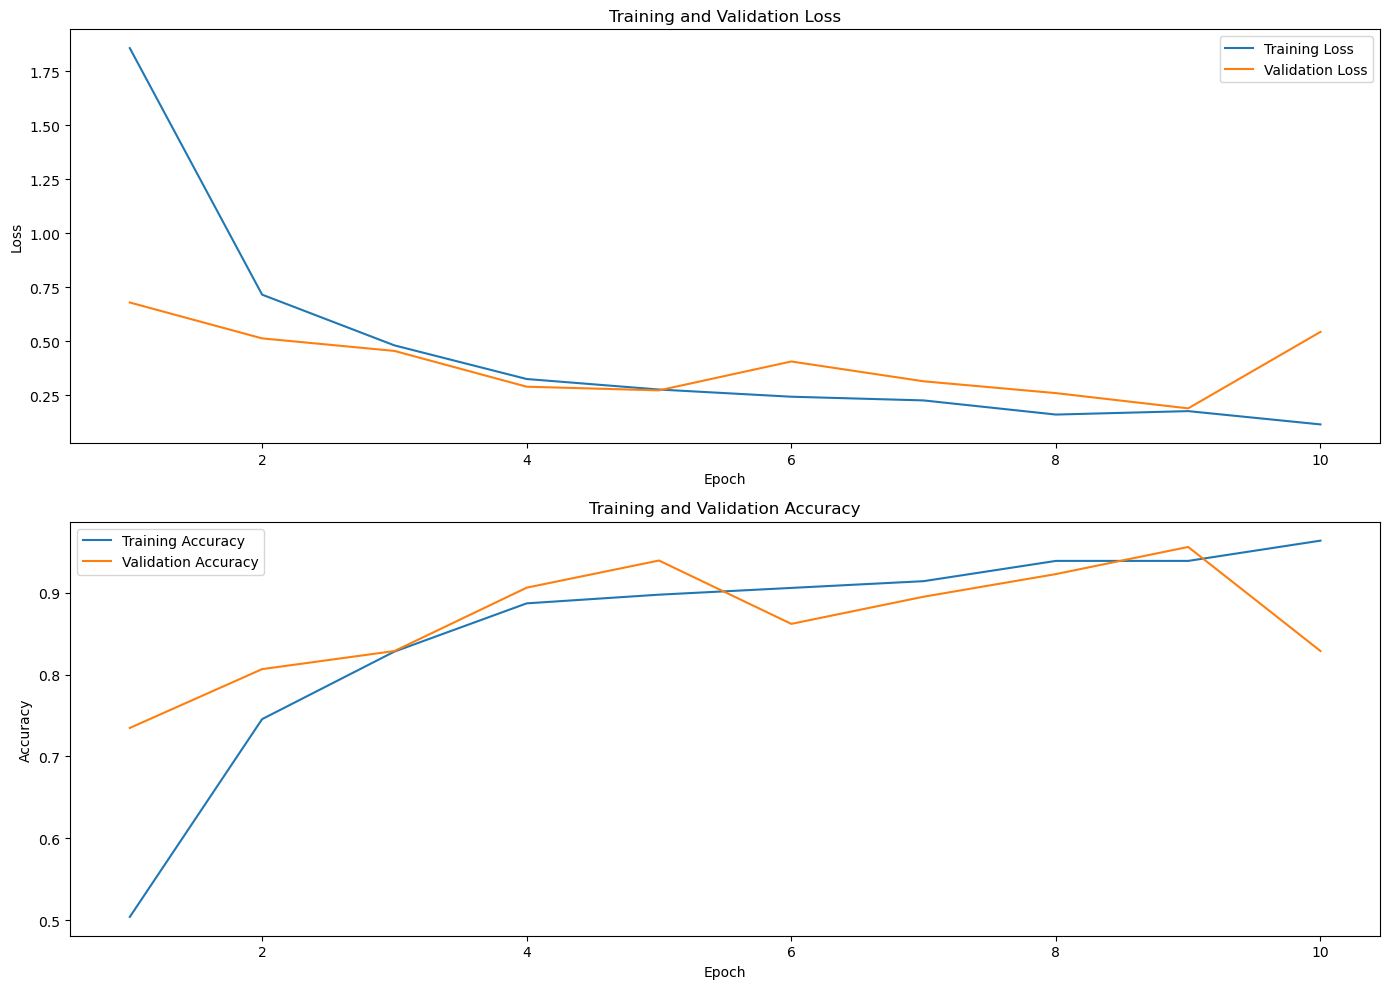

Test Loss: 0.598637169925496, Test Accuracy: 0.8032786885245902
************************************************************************
************************************************************************
Experiment: 22
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.9064088667984362, Train Accuracy: 0.4911660777385159, Val Loss: 0.7449348370234171, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.8106436596976386, Train Accuracy: 0.7067137809187279, Val Loss: 0.5528035312891006, Val Accuracy: 0.7955801104972375
Epoch 2, Train Loss: 0.5412754254346644, Train Accuracy: 0.8044758539458187, Val Loss: 0.4983571606377761, Val Accuracy: 0.8011049723756906
Epoch 3, Train Loss: 0.40014981878576455, Train Accuracy: 0.8539458186101295, Val Loss: 0.2895700770119826, Val Accuracy: 0.9171270718232044
Epoch 4, Train Loss: 0.36396285022298497, Train Accuracy: 0.8574793875147232, Val Loss: 0.3430538686613242, Val Accuracy: 0.8839779005524

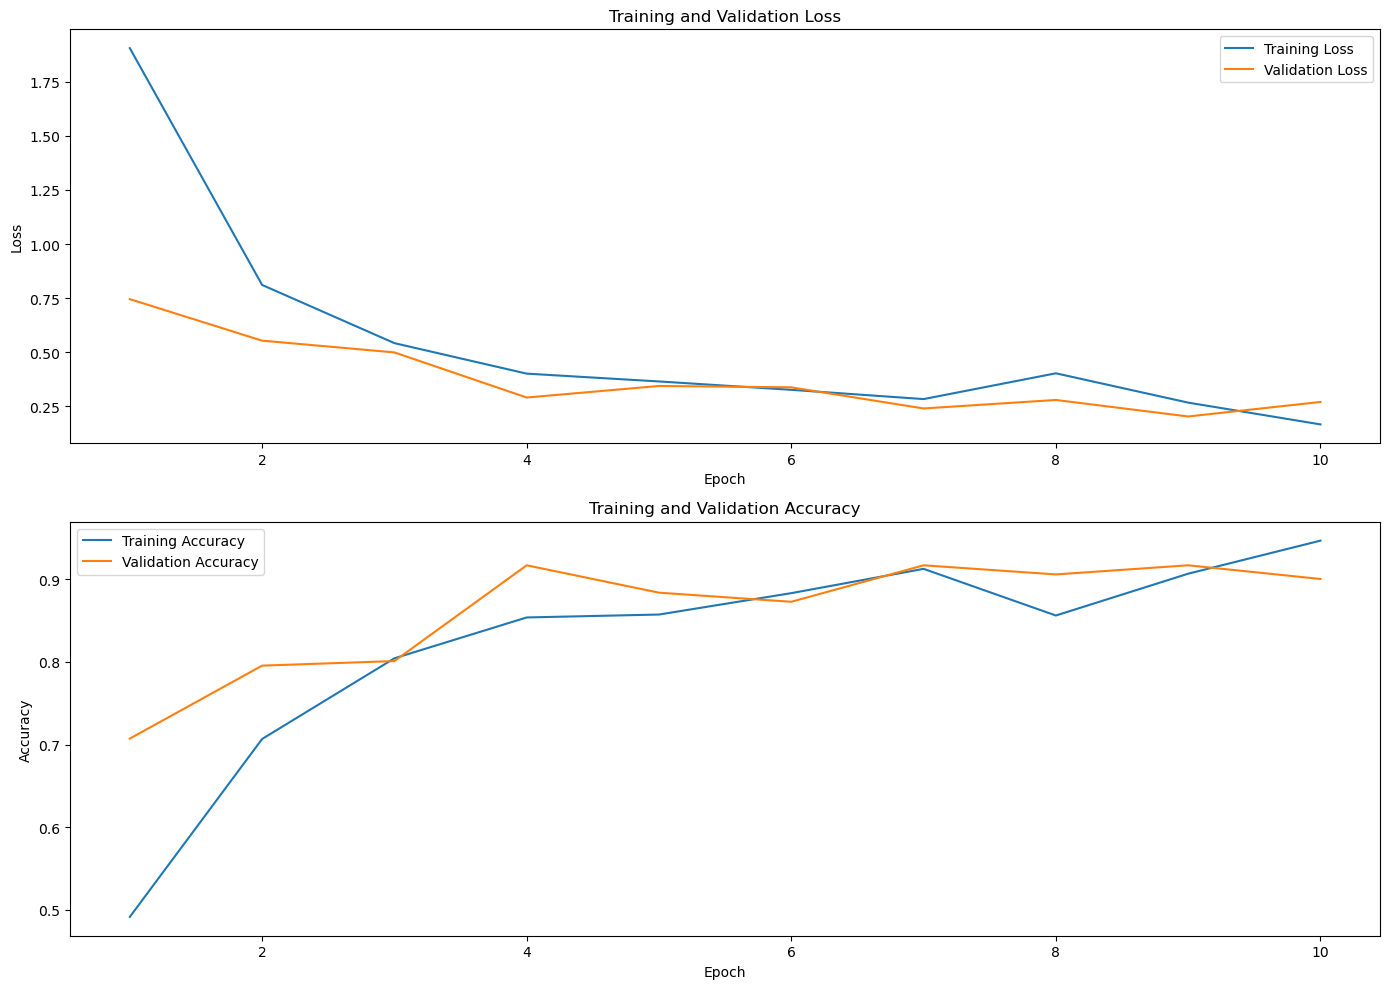

Test Loss: 0.34882098350984353, Test Accuracy: 0.8688524590163934
************************************************************************
************************************************************************
Experiment: 23
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024]
dropout_rate= 0.5
Epoch 0, Train Loss: 2.2841798210585558, Train Accuracy: 0.42285041224970554, Val Loss: 0.7963552648822466, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.9264103957900295, Train Accuracy: 0.6501766784452296, Val Loss: 0.661886140704155, Val Accuracy: 0.7569060773480663
Epoch 2, Train Loss: 0.697301324043009, Train Accuracy: 0.7502944640753828, Val Loss: 0.5500708557665348, Val Accuracy: 0.8232044198895028
Epoch 3, Train Loss: 0.5486553295480984, Train Accuracy: 0.784452296819788, Val Loss: 0.4619549463192622, Val Accuracy: 0.850828729281768
Epoch 4, Train Loss: 0.49959380745335863, Train Accuracy: 0.817432273262662, Val Loss: 0.397376482685407, Val Accuracy: 0.8453038674033149


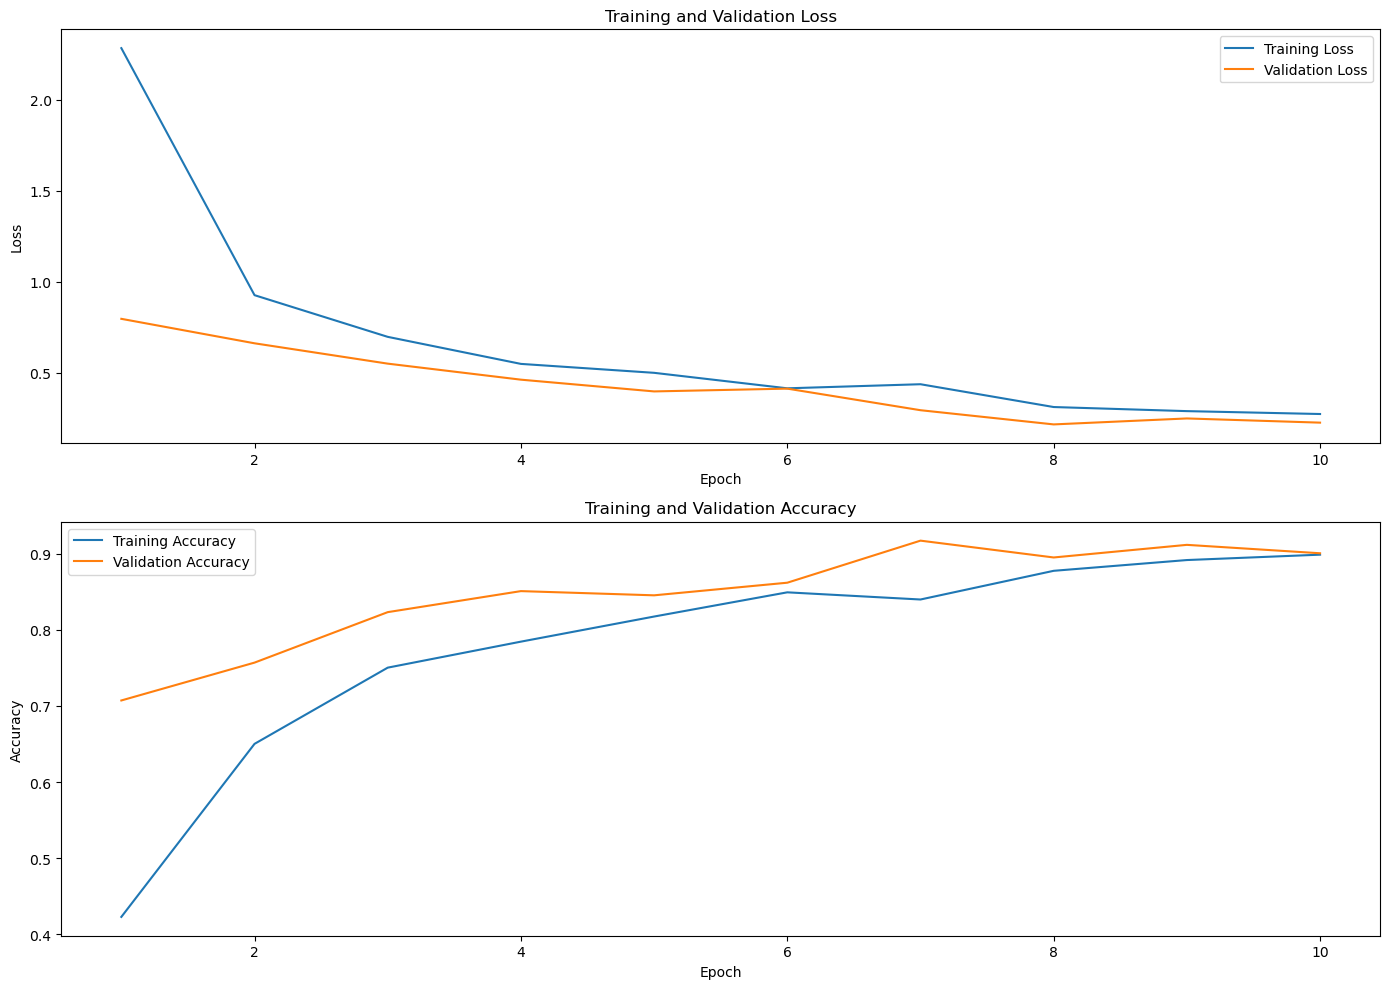

Test Loss: 0.2938145643565804, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 24
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024]
dropout_rate= 0.7
Epoch 0, Train Loss: 2.987675545392213, Train Accuracy: 0.40636042402826855, Val Loss: 0.9664513990283012, Val Accuracy: 0.6740331491712708
Epoch 1, Train Loss: 1.1492282941385552, Train Accuracy: 0.5948174322732627, Val Loss: 0.7684395288427671, Val Accuracy: 0.6795580110497238
Epoch 2, Train Loss: 0.8846838352856813, Train Accuracy: 0.6690223792697291, Val Loss: 0.5547110090653101, Val Accuracy: 0.8232044198895028
Epoch 3, Train Loss: 0.7494524558661161, Train Accuracy: 0.7208480565371025, Val Loss: 0.5773572300871214, Val Accuracy: 0.8342541436464088
Epoch 4, Train Loss: 0.6294801088946836, Train Accuracy: 0.7644287396937574, Val Loss: 0.4324154108762741, Val Accuracy: 0.85635359116022

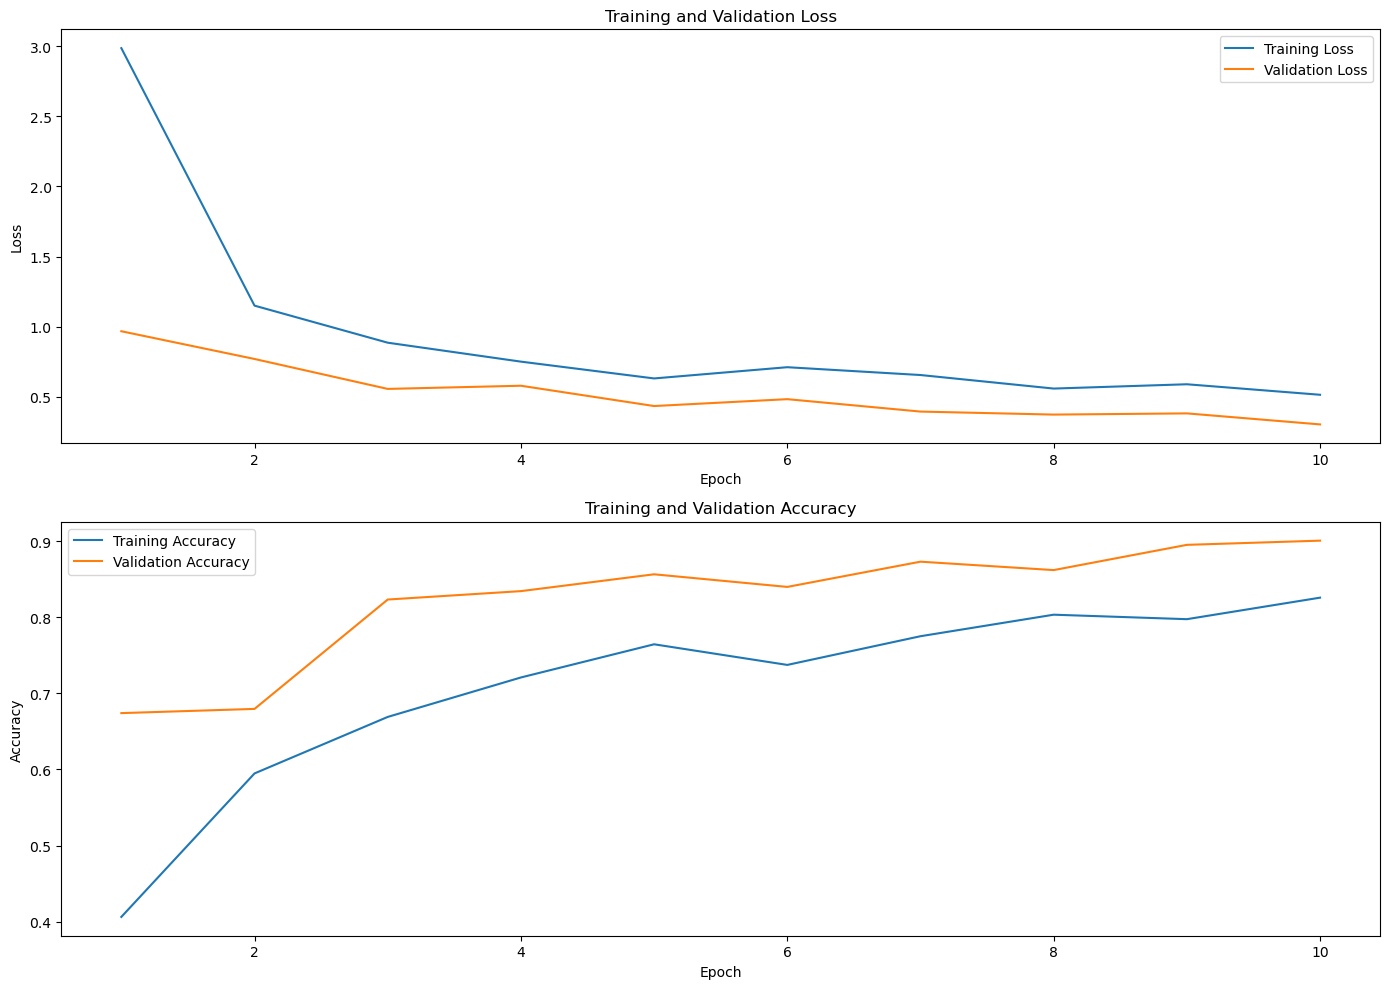

Test Loss: 0.3433071579784155, Test Accuracy: 0.8579234972677595
************************************************************************
************************************************************************
Experiment: 25
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512, 256]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.3100852992178664, Train Accuracy: 0.4534746760895171, Val Loss: 0.7524988651275635, Val Accuracy: 0.7845303867403315
Epoch 1, Train Loss: 0.7308349741829766, Train Accuracy: 0.7385159010600707, Val Loss: 0.8433505445718765, Val Accuracy: 0.6906077348066298
Epoch 2, Train Loss: 0.5577502063027134, Train Accuracy: 0.800942285041225, Val Loss: 0.4171873653928439, Val Accuracy: 0.8839779005524862
Epoch 3, Train Loss: 0.40288575200570953, Train Accuracy: 0.8480565371024735, Val Loss: 0.29561695270240307, Val Accuracy: 0.9060773480662984
Epoch 4, Train Loss: 0.3523125896851222, Train Accuracy: 0.8775029446407538, Val Loss: 0.2935325273623069, Val Accuracy: 0.872928176

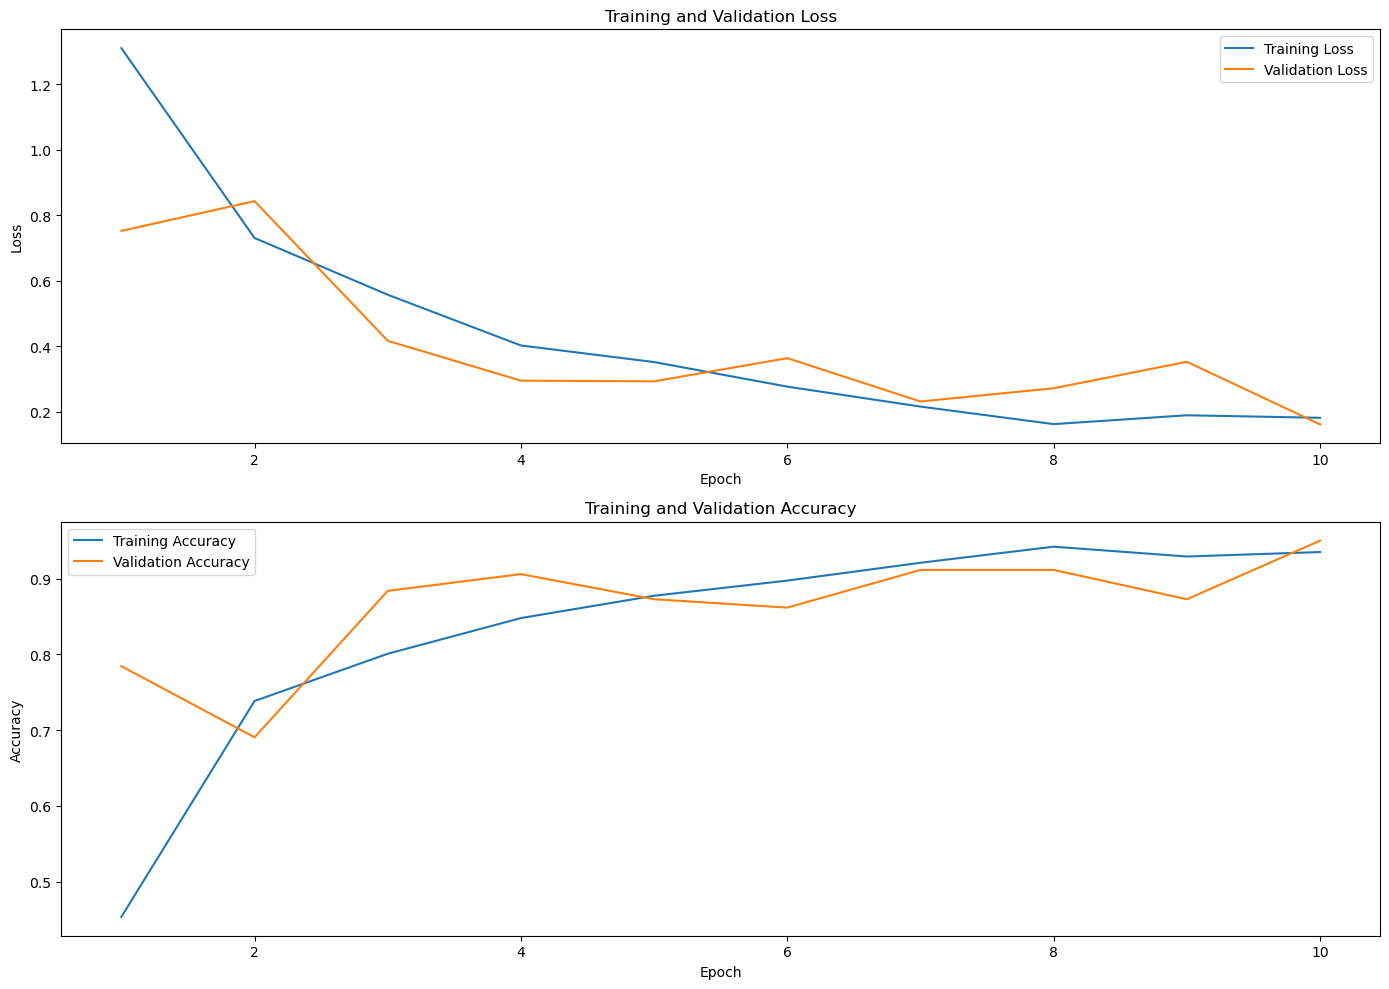

Test Loss: 0.1796111778045694, Test Accuracy: 0.9234972677595629
************************************************************************
************************************************************************
Experiment: 26
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512, 256]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.4595473811582282, Train Accuracy: 0.3957597173144876, Val Loss: 0.9108709941307703, Val Accuracy: 0.6740331491712708
Epoch 1, Train Loss: 1.0023854231392895, Train Accuracy: 0.6254416961130742, Val Loss: 0.7532187203566233, Val Accuracy: 0.7513812154696132
Epoch 2, Train Loss: 0.7567434443367852, Train Accuracy: 0.7173144876325088, Val Loss: 0.5042949989438057, Val Accuracy: 0.8397790055248618
Epoch 3, Train Loss: 0.5631921076112323, Train Accuracy: 0.7974087161366313, Val Loss: 0.40713763733704883, Val Accuracy: 0.8674033149171271
Epoch 4, Train Loss: 0.5860023931772621, Train Accuracy: 0.7891637220259128, Val Loss: 0.3822471884389718, Val Accuracy: 0.828729281

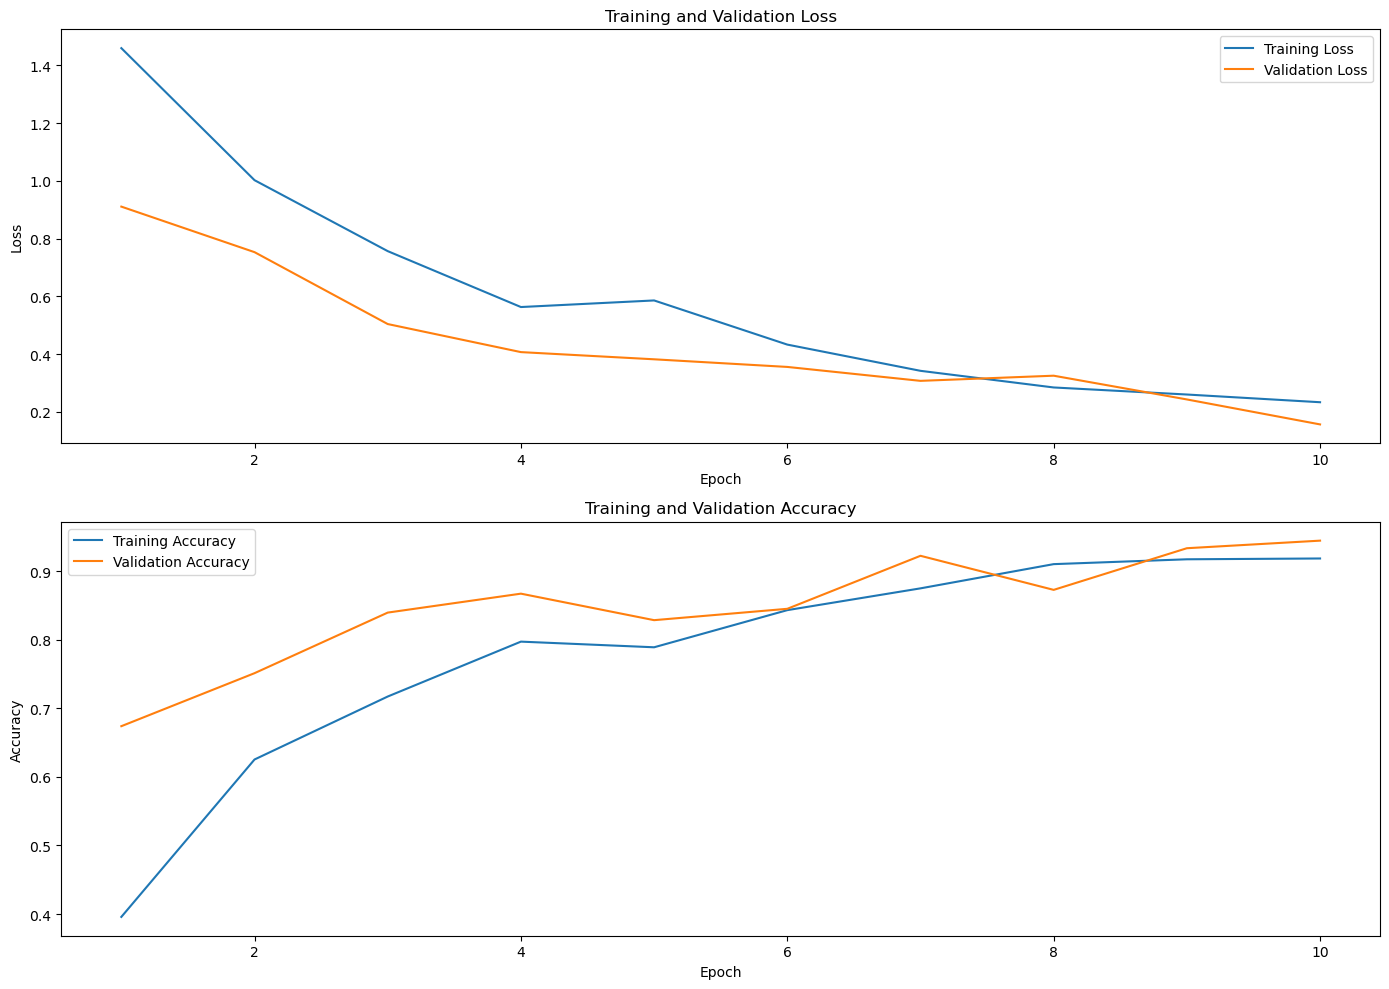

Test Loss: 0.20163698711742958, Test Accuracy: 0.9344262295081968
************************************************************************
************************************************************************
Experiment: 27
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512, 256]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.7446819368611883, Train Accuracy: 0.30742049469964666, Val Loss: 1.2412272344032924, Val Accuracy: 0.5138121546961326
Epoch 1, Train Loss: 1.2488200234042273, Train Accuracy: 0.5017667844522968, Val Loss: 1.0113030125697453, Val Accuracy: 0.6519337016574586
Epoch 2, Train Loss: 1.0936667392099346, Train Accuracy: 0.5653710247349824, Val Loss: 0.7810824364423752, Val Accuracy: 0.7348066298342542
Epoch 3, Train Loss: 0.8775486901954368, Train Accuracy: 0.657243816254417, Val Loss: 0.5564505656560262, Val Accuracy: 0.861878453038674
Epoch 4, Train Loss: 0.8387749277883105, Train Accuracy: 0.6925795053003534, Val Loss: 0.6057875876625379, Val Accuracy: 0.8287292817

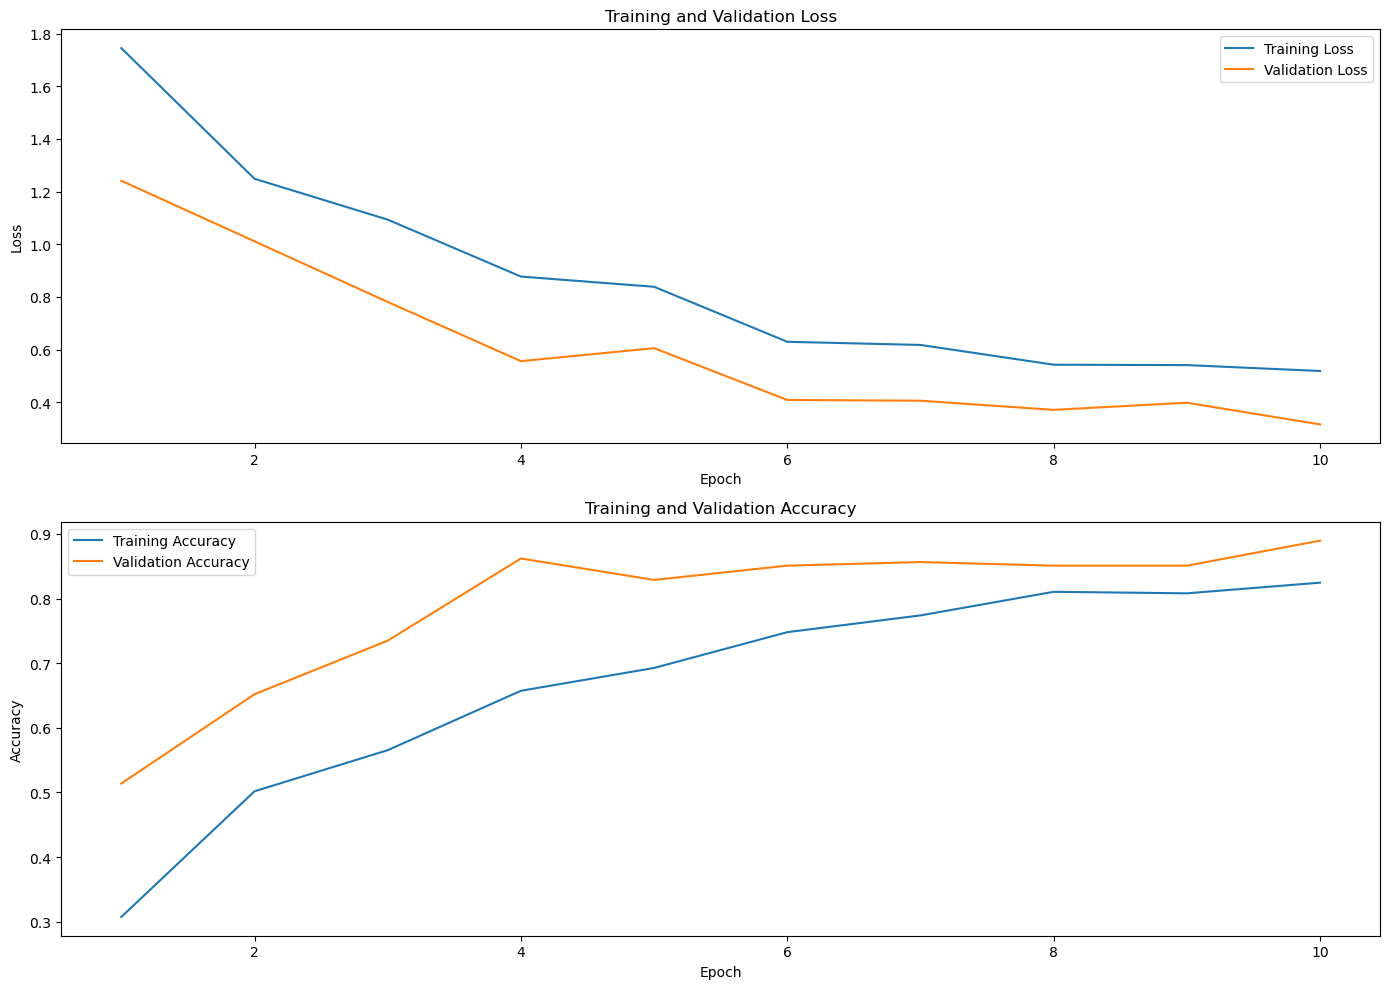

Test Loss: 0.3655647312601407, Test Accuracy: 0.8633879781420765
************************************************************************
************************************************************************
Experiment: 28
batch_size= 16
learning_rate= 0.0005
hidden_layers= [512, 256]
dropout_rate= 0.7
Epoch 0, Train Loss: 2.2361336571198924, Train Accuracy: 0.2037691401648999, Val Loss: 1.4721382757027943, Val Accuracy: 0.4088397790055249
Epoch 1, Train Loss: 1.584701540293517, Train Accuracy: 0.29917550058892817, Val Loss: 1.4026444653669994, Val Accuracy: 0.46408839779005523
Epoch 2, Train Loss: 1.484265634307155, Train Accuracy: 0.37691401648998824, Val Loss: 1.2590889235337575, Val Accuracy: 0.5966850828729282
Epoch 3, Train Loss: 1.385097798373964, Train Accuracy: 0.4299175500588928, Val Loss: 1.101095199584961, Val Accuracy: 0.7403314917127072
Epoch 4, Train Loss: 1.2658215485237263, Train Accuracy: 0.48645465253239106, Val Loss: 1.0592116663853328, Val Accuracy: 0.6850828729

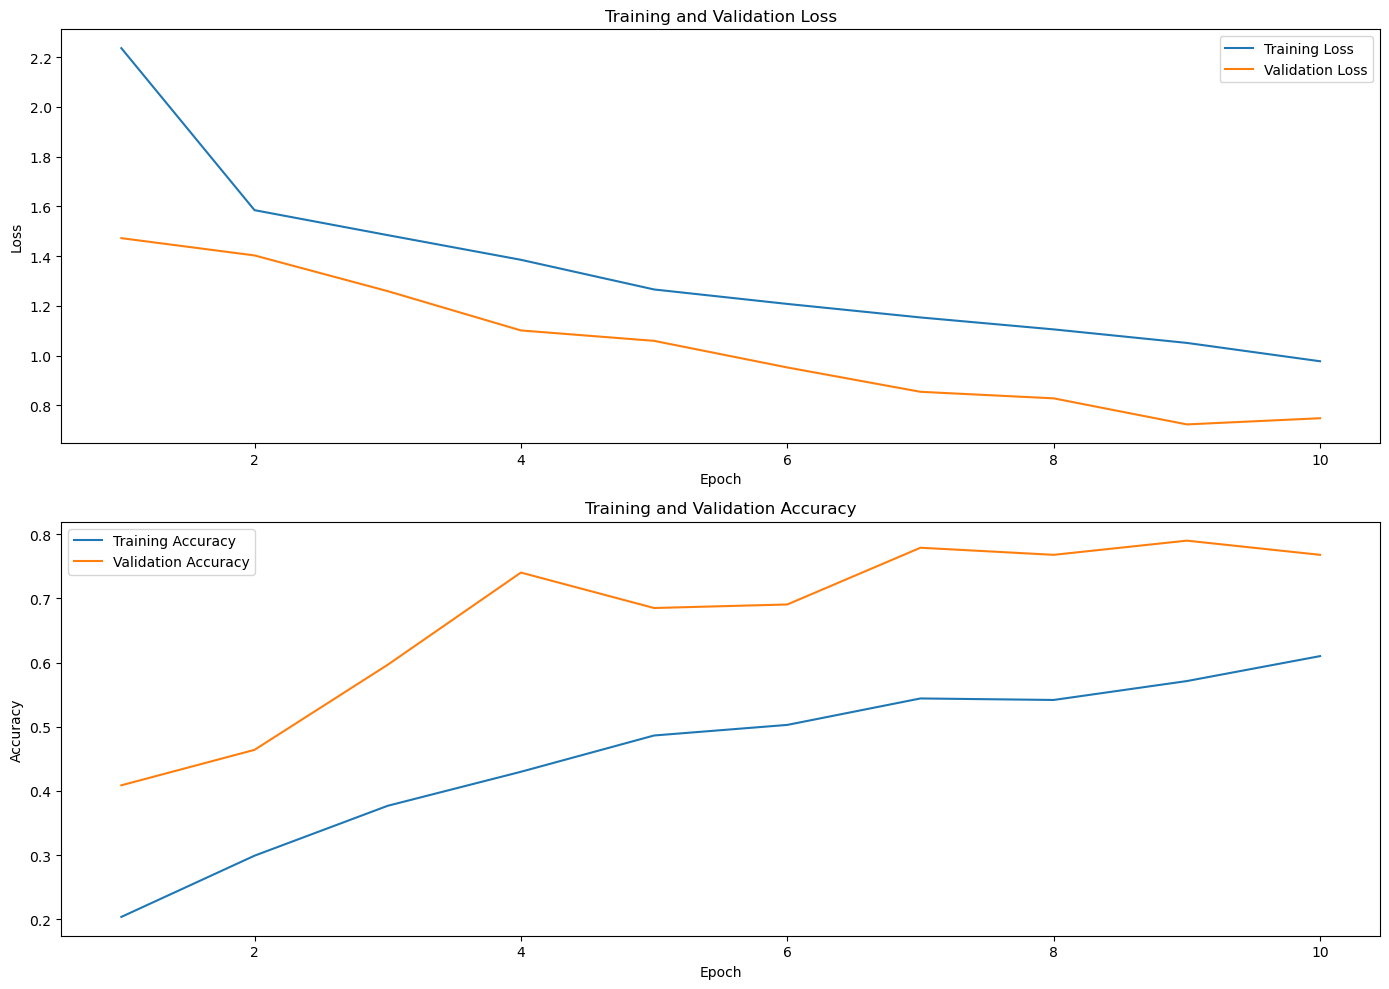

Test Loss: 0.7690582970778147, Test Accuracy: 0.7158469945355191
************************************************************************
************************************************************************
Experiment: 29
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024, 512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.3802764493006248, Train Accuracy: 0.4711425206124853, Val Loss: 0.9760062793890635, Val Accuracy: 0.5580110497237569
Epoch 1, Train Loss: 0.7371850756031496, Train Accuracy: 0.7196702002355713, Val Loss: 0.7269731933871905, Val Accuracy: 0.7458563535911602
Epoch 2, Train Loss: 0.5305021544573484, Train Accuracy: 0.8032979976442874, Val Loss: 0.6282174016038576, Val Accuracy: 0.7513812154696132
Epoch 3, Train Loss: 0.4025696526040082, Train Accuracy: 0.8527679623085983, Val Loss: 0.37067632594456273, Val Accuracy: 0.8784530386740331
Epoch 4, Train Loss: 0.3340885175598992, Train Accuracy: 0.8928150765606596, Val Loss: 0.2971698871503274, Val Accuracy: 0.92265193

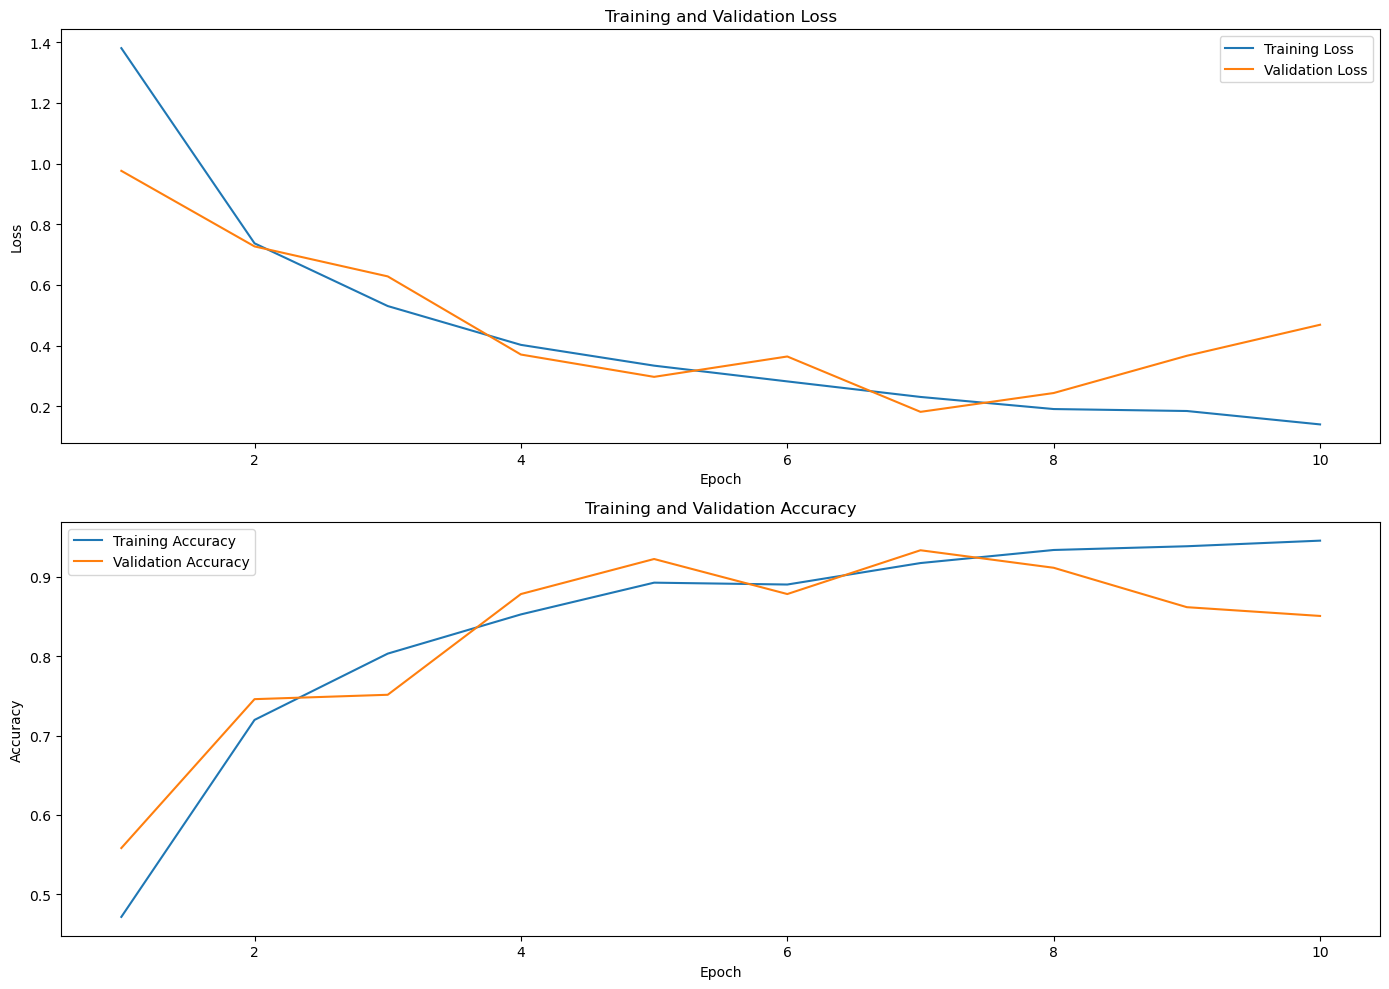

Test Loss: 0.49042984036107856, Test Accuracy: 0.8633879781420765
************************************************************************
************************************************************************
Experiment: 30
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024, 512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.5989754531118605, Train Accuracy: 0.37809187279151946, Val Loss: 0.9669622232516607, Val Accuracy: 0.6243093922651933
Epoch 1, Train Loss: 0.9024315357070278, Train Accuracy: 0.6501766784452296, Val Loss: 0.9410931716362635, Val Accuracy: 0.6740331491712708
Epoch 2, Train Loss: 0.6999426086743673, Train Accuracy: 0.7444051825677267, Val Loss: 0.5713008542855581, Val Accuracy: 0.7845303867403315
Epoch 3, Train Loss: 0.5812388288754003, Train Accuracy: 0.7797408716136631, Val Loss: 0.50418679540356, Val Accuracy: 0.8232044198895028
Epoch 4, Train Loss: 0.48160408520036274, Train Accuracy: 0.8280329799764429, Val Loss: 0.379555298636357, Val Accuracy: 0.867403314

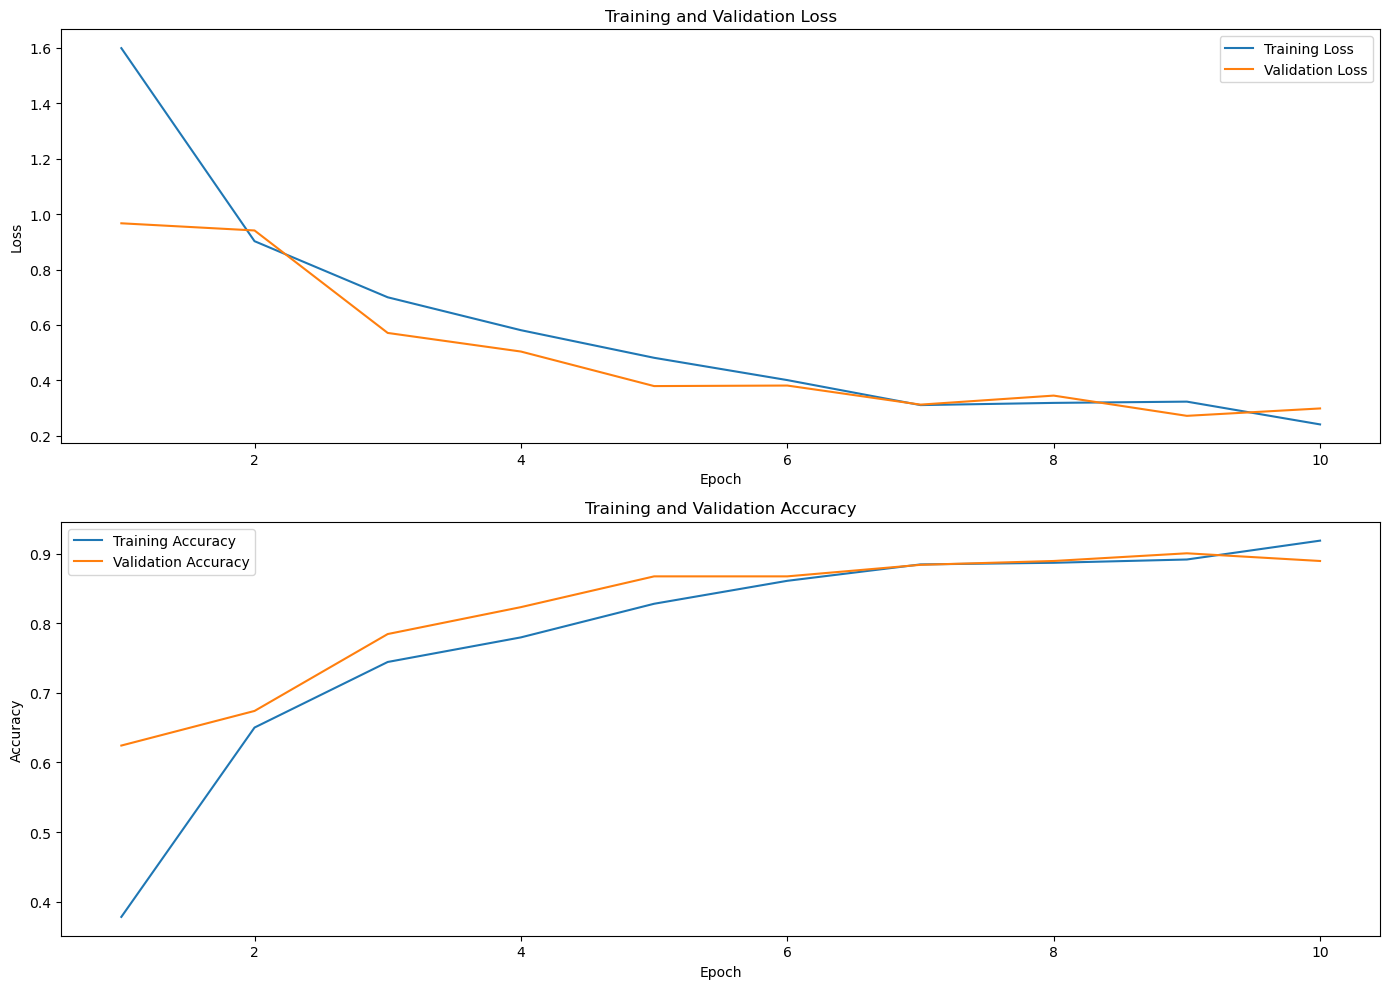

Test Loss: 0.2532392454644044, Test Accuracy: 0.8852459016393442
************************************************************************
************************************************************************
Experiment: 31
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024, 512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.8774295912848578, Train Accuracy: 0.3380447585394582, Val Loss: 1.0044704129298527, Val Accuracy: 0.6629834254143646
Epoch 1, Train Loss: 1.1038425281919815, Train Accuracy: 0.5500588928150766, Val Loss: 0.9116137077411016, Val Accuracy: 0.7237569060773481
Epoch 2, Train Loss: 0.9099163838006832, Train Accuracy: 0.6560659599528857, Val Loss: 0.6652968575557073, Val Accuracy: 0.7403314917127072
Epoch 3, Train Loss: 0.7576257809306737, Train Accuracy: 0.7196702002355713, Val Loss: 0.5353627192477385, Val Accuracy: 0.8342541436464088
Epoch 4, Train Loss: 0.7149999610803746, Train Accuracy: 0.751472320376914, Val Loss: 0.45905718455712, Val Accuracy: 0.845303867403

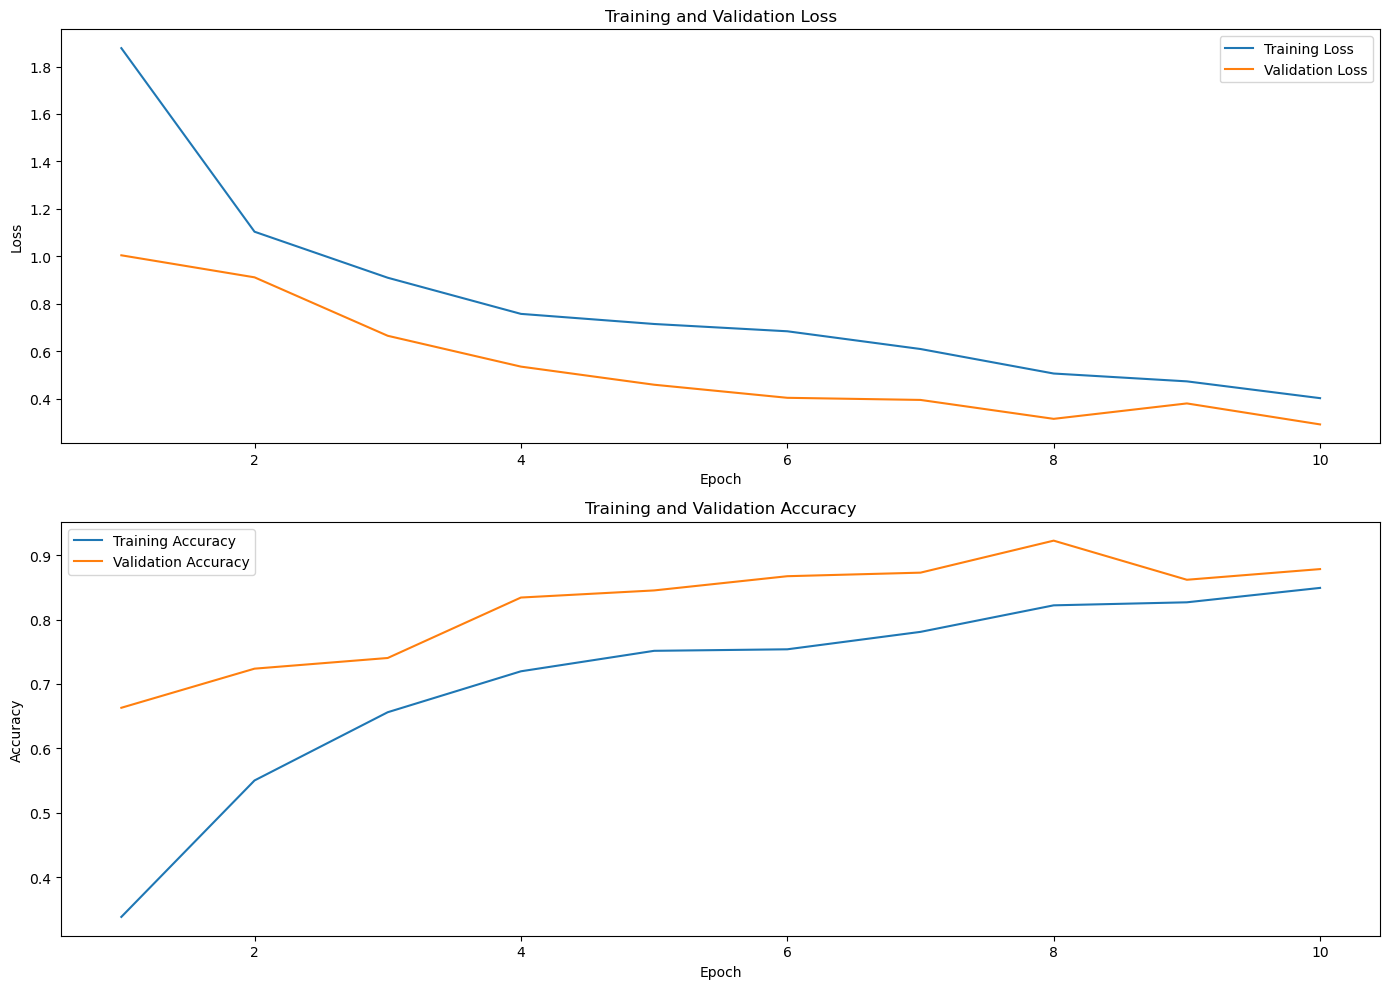

Test Loss: 0.29449334492286044, Test Accuracy: 0.912568306010929
************************************************************************
************************************************************************
Experiment: 32
batch_size= 16
learning_rate= 0.0005
hidden_layers= [1024, 512]
dropout_rate= 0.7
Epoch 0, Train Loss: 2.753717323144277, Train Accuracy: 0.2332155477031802, Val Loss: 1.3127593298753102, Val Accuracy: 0.5248618784530387
Epoch 1, Train Loss: 1.585305873994474, Train Accuracy: 0.3415783274440518, Val Loss: 1.2281877795855205, Val Accuracy: 0.5138121546961326
Epoch 2, Train Loss: 1.4216719501548343, Train Accuracy: 0.4122497055359246, Val Loss: 1.0320252776145935, Val Accuracy: 0.6629834254143646
Epoch 3, Train Loss: 1.210018570776339, Train Accuracy: 0.5064782096584217, Val Loss: 0.8751607884963354, Val Accuracy: 0.7569060773480663
Epoch 4, Train Loss: 1.1507194207774267, Train Accuracy: 0.5382803297997645, Val Loss: 0.8217010945081711, Val Accuracy: 0.773480662983

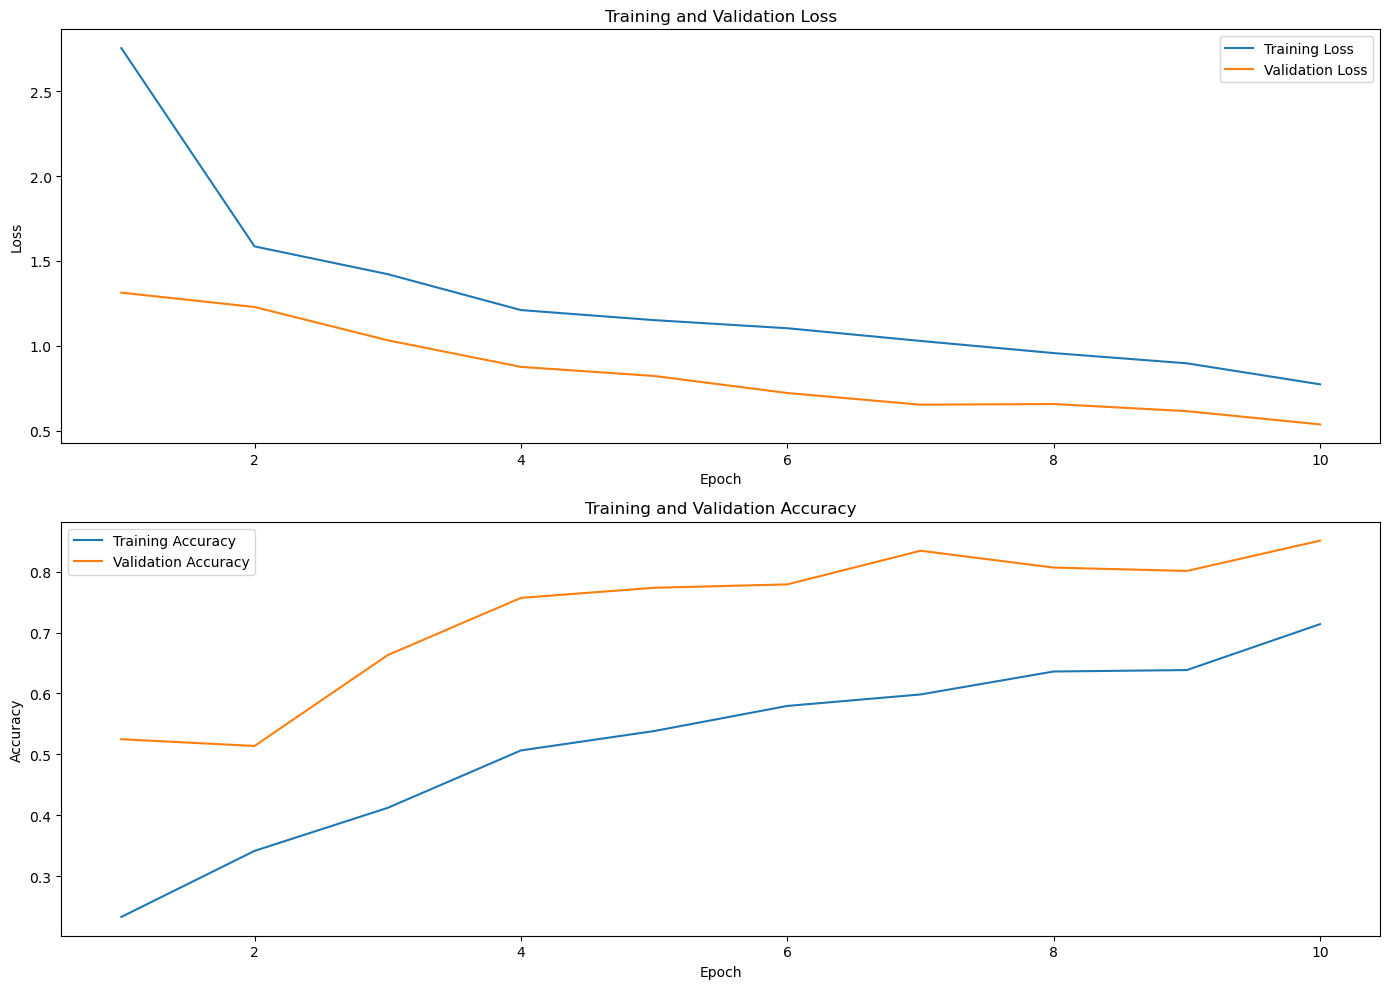

Test Loss: 0.56637192517519, Test Accuracy: 0.7978142076502732
************************************************************************
************************************************************************
Experiment: 33
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.1699932474229071, Train Accuracy: 0.5371024734982333, Val Loss: 0.6755245998501778, Val Accuracy: 0.7845303867403315
Epoch 1, Train Loss: 0.5928884035459271, Train Accuracy: 0.7915194346289752, Val Loss: 0.6273755133152008, Val Accuracy: 0.7900552486187845
Epoch 2, Train Loss: 0.409426780934963, Train Accuracy: 0.8704358068315665, Val Loss: 0.3730686741570632, Val Accuracy: 0.8839779005524862
Epoch 3, Train Loss: 0.34867389900264917, Train Accuracy: 0.9034157832744405, Val Loss: 0.3071972268323104, Val Accuracy: 0.9116022099447514
Epoch 4, Train Loss: 0.24536495766154043, Train Accuracy: 0.9234393404004712, Val Loss: 0.22758763624976078, Val Accuracy: 0.939226519337016

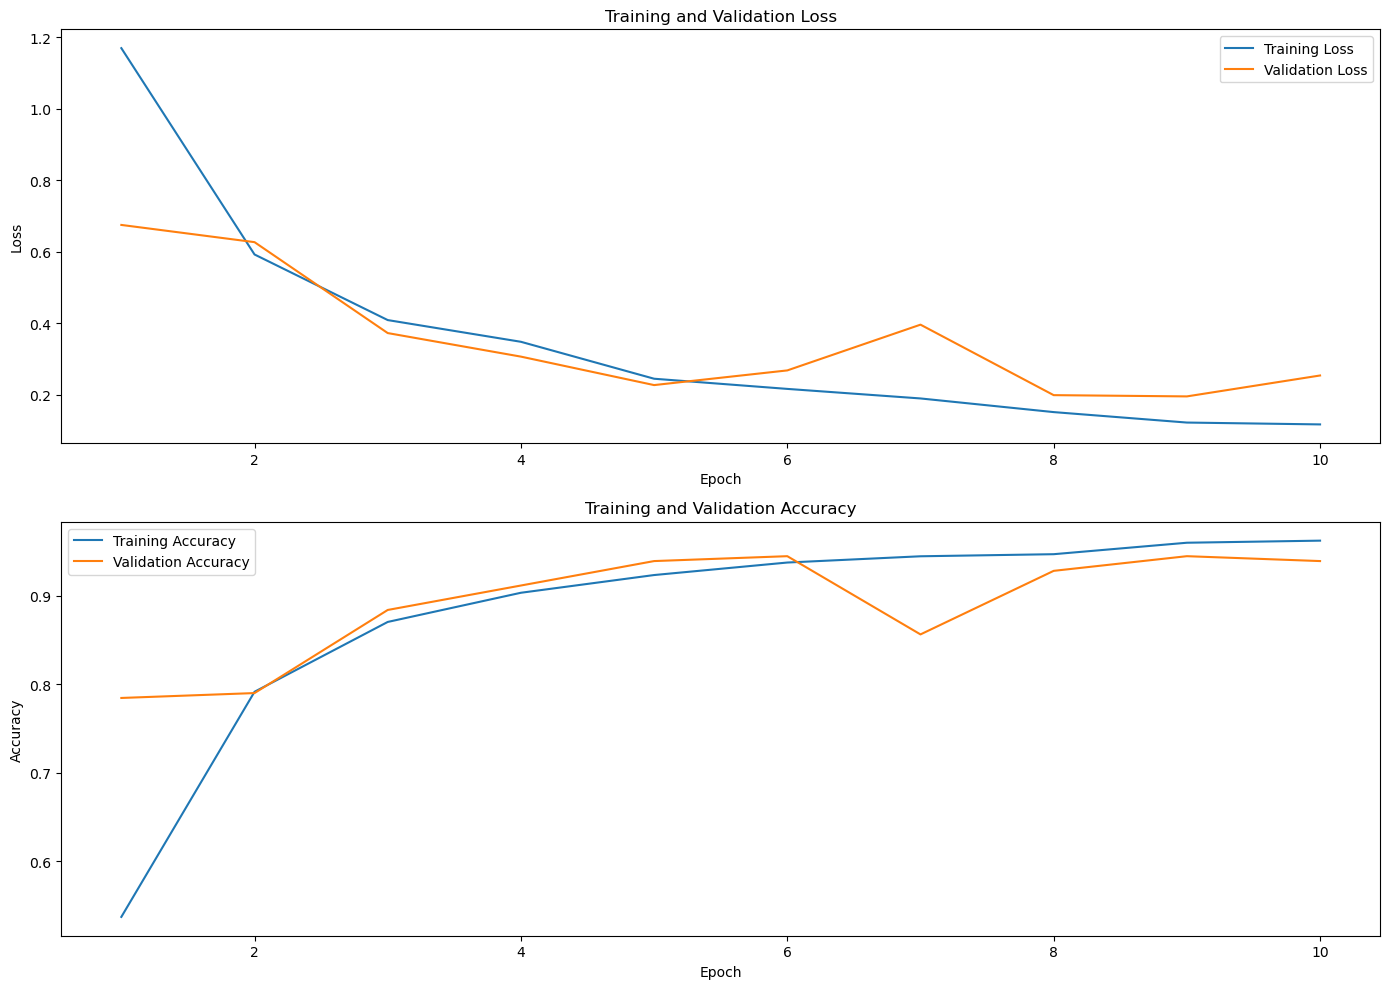

Test Loss: 0.3162930704032381, Test Accuracy: 0.9016393442622951
************************************************************************
************************************************************************
Experiment: 34
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.2560540054131437, Train Accuracy: 0.5064782096584217, Val Loss: 0.7503786608576775, Val Accuracy: 0.7624309392265194
Epoch 1, Train Loss: 0.6922717729100475, Train Accuracy: 0.7385159010600707, Val Loss: 0.6298235766589642, Val Accuracy: 0.8121546961325967
Epoch 2, Train Loss: 0.4886819503024324, Train Accuracy: 0.8409893992932862, Val Loss: 0.4585512864092986, Val Accuracy: 0.8176795580110497
Epoch 3, Train Loss: 0.433449146648248, Train Accuracy: 0.8445229681978799, Val Loss: 0.3661157302558422, Val Accuracy: 0.8950276243093923
Epoch 4, Train Loss: 0.3332275647532057, Train Accuracy: 0.889281507656066, Val Loss: 0.2645698220779498, Val Accuracy: 0.9281767955801105


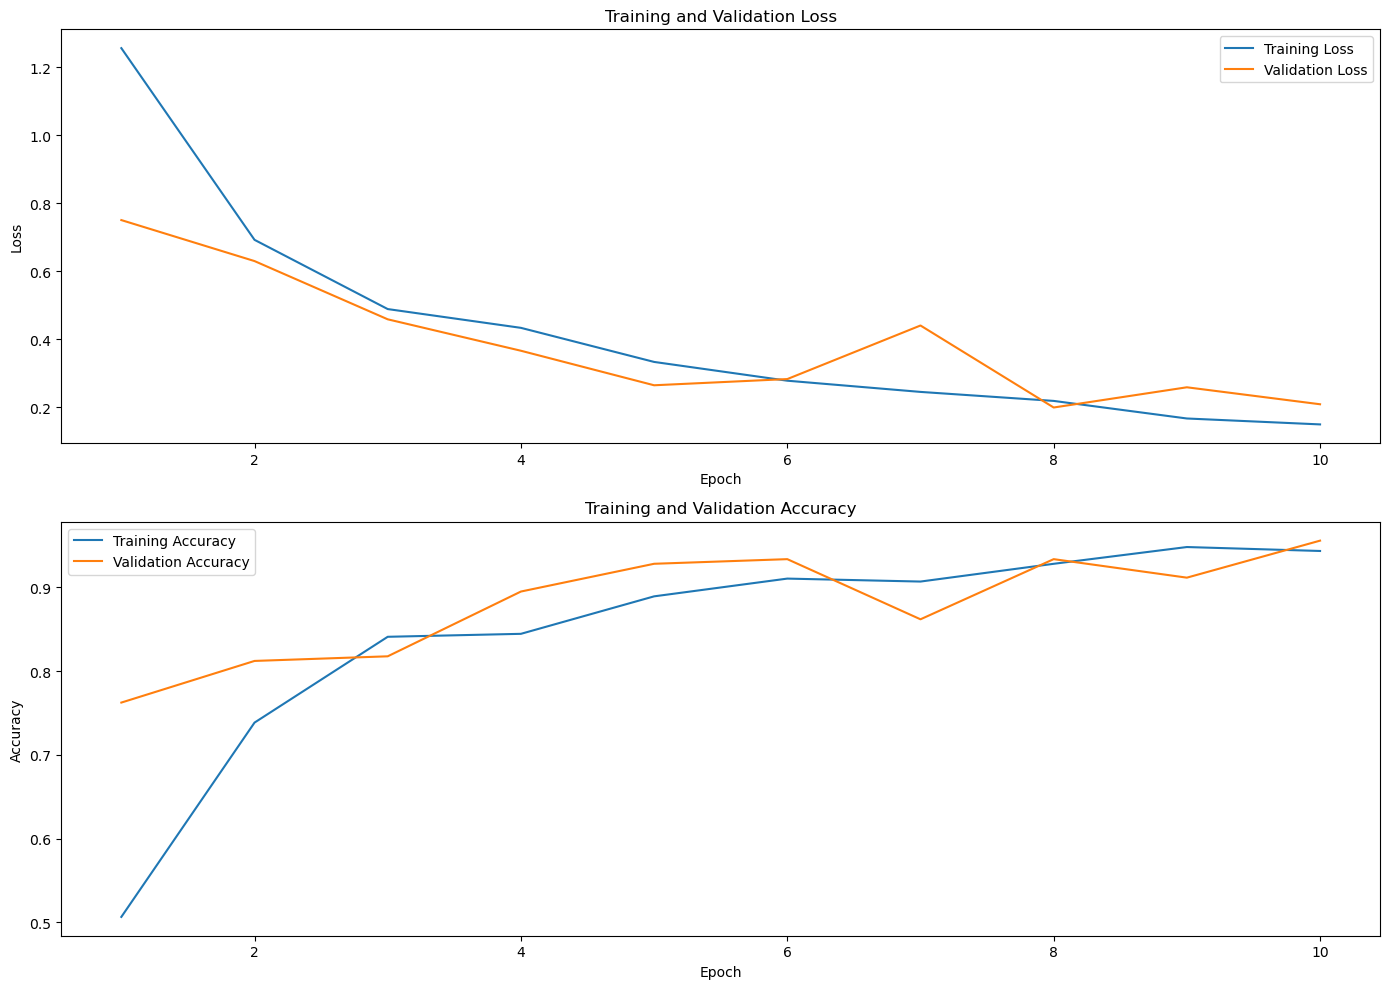

Test Loss: 0.24728468883161744, Test Accuracy: 0.9398907103825137
************************************************************************
************************************************************************
Experiment: 35
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.3472638505476493, Train Accuracy: 0.46760895170789163, Val Loss: 0.8009755512078603, Val Accuracy: 0.7348066298342542
Epoch 1, Train Loss: 0.8198185019471027, Train Accuracy: 0.7043580683156655, Val Loss: 0.6597659861048063, Val Accuracy: 0.7845303867403315
Epoch 2, Train Loss: 0.6432236612136303, Train Accuracy: 0.7632508833922261, Val Loss: 0.5481648767987887, Val Accuracy: 0.7955801104972375
Epoch 3, Train Loss: 0.5165484086782844, Train Accuracy: 0.8186101295641932, Val Loss: 0.40578389291961986, Val Accuracy: 0.8729281767955801
Epoch 4, Train Loss: 0.4283092248219031, Train Accuracy: 0.8551236749116607, Val Loss: 0.29912166732052964, Val Accuracy: 0.91712707182

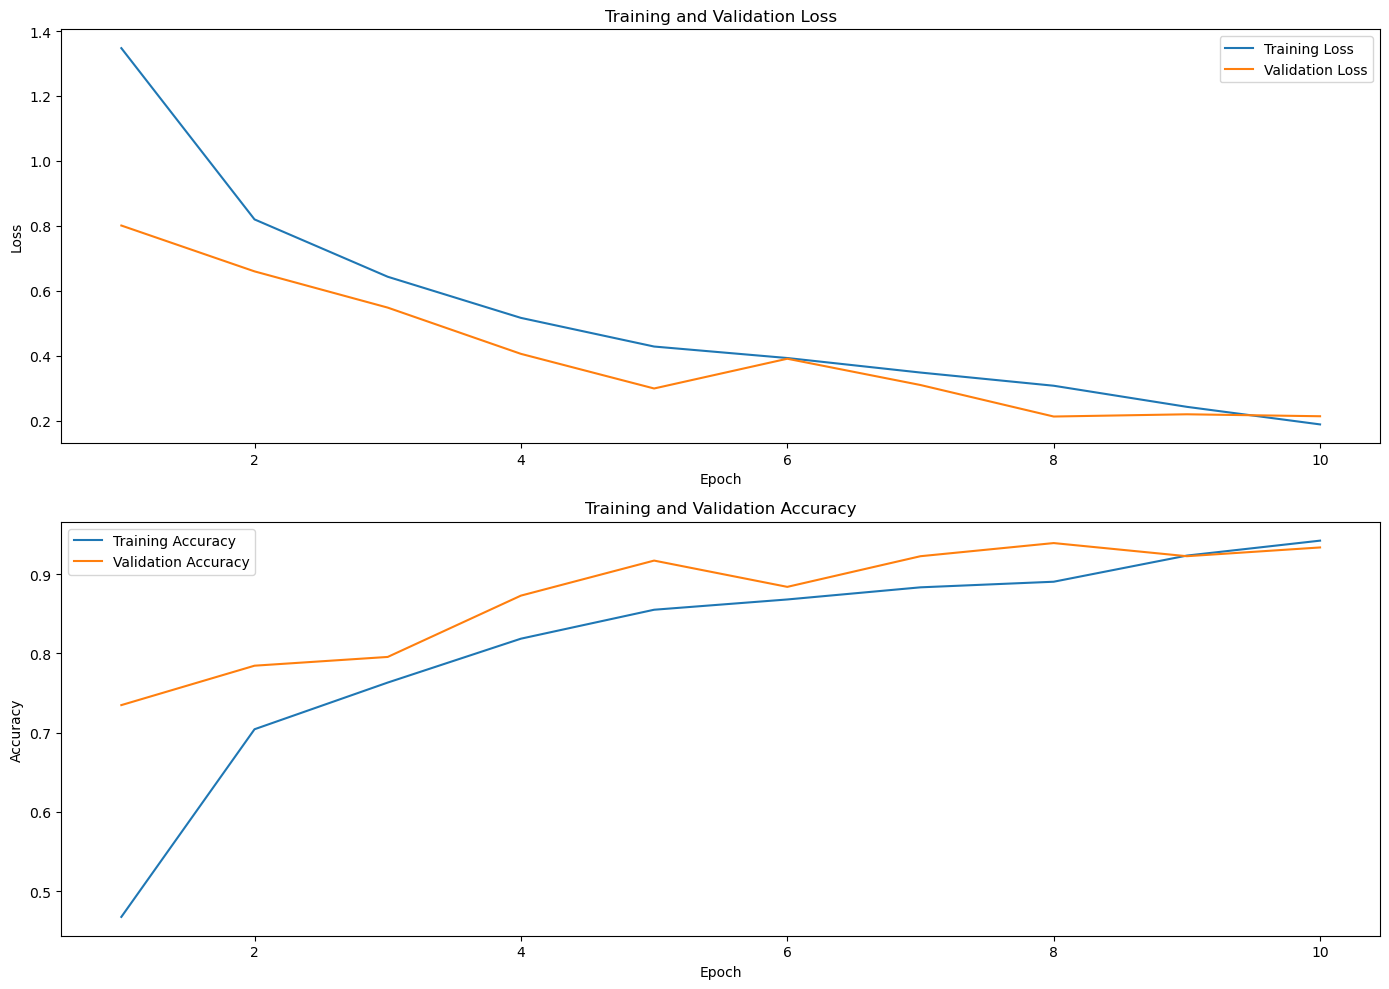

Test Loss: 0.23728619562461972, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 36
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.5439724524815877, Train Accuracy: 0.39693757361601884, Val Loss: 0.944368506471316, Val Accuracy: 0.6795580110497238
Epoch 1, Train Loss: 1.0589706428624965, Train Accuracy: 0.6007067137809188, Val Loss: 0.7753050178289413, Val Accuracy: 0.7513812154696132
Epoch 2, Train Loss: 0.8922086948597873, Train Accuracy: 0.6796230859835101, Val Loss: 0.6307559510072073, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 0.764893367058701, Train Accuracy: 0.7161366313309776, Val Loss: 0.5558551152547201, Val Accuracy: 0.850828729281768
Epoch 4, Train Loss: 0.6400052162784117, Train Accuracy: 0.7714958775029447, Val Loss: 0.5050271277626356, Val Accuracy: 0.850828729281768


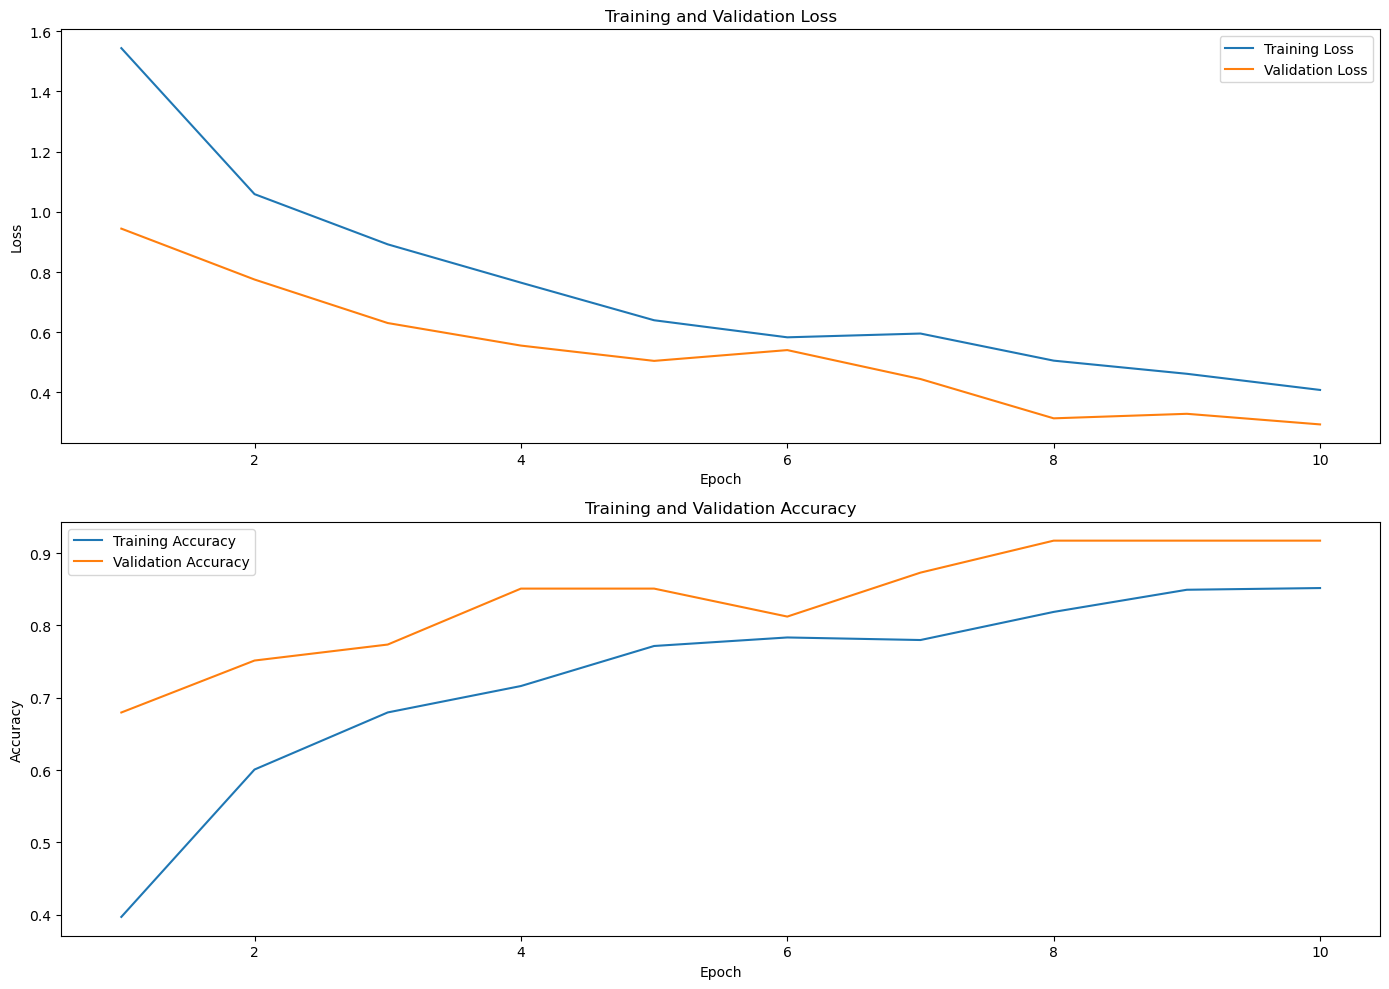

Test Loss: 0.33077888935804367, Test Accuracy: 0.9016393442622951
************************************************************************
************************************************************************
Experiment: 37
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.2549719145452534, Train Accuracy: 0.5217903415783275, Val Loss: 0.681099146604538, Val Accuracy: 0.7734806629834254
Epoch 1, Train Loss: 0.6454632149802314, Train Accuracy: 0.7597173144876325, Val Loss: 0.5259175002574921, Val Accuracy: 0.7955801104972375
Epoch 2, Train Loss: 0.4613809375161374, Train Accuracy: 0.8362779740871613, Val Loss: 0.4150550191601117, Val Accuracy: 0.8453038674033149
Epoch 3, Train Loss: 0.29615902969682656, Train Accuracy: 0.8951707891637221, Val Loss: 0.26166568355013925, Val Accuracy: 0.9337016574585635
Epoch 4, Train Loss: 0.23727425698328902, Train Accuracy: 0.911660777385159, Val Loss: 0.2848893292248249, Val Accuracy: 0.895027624309

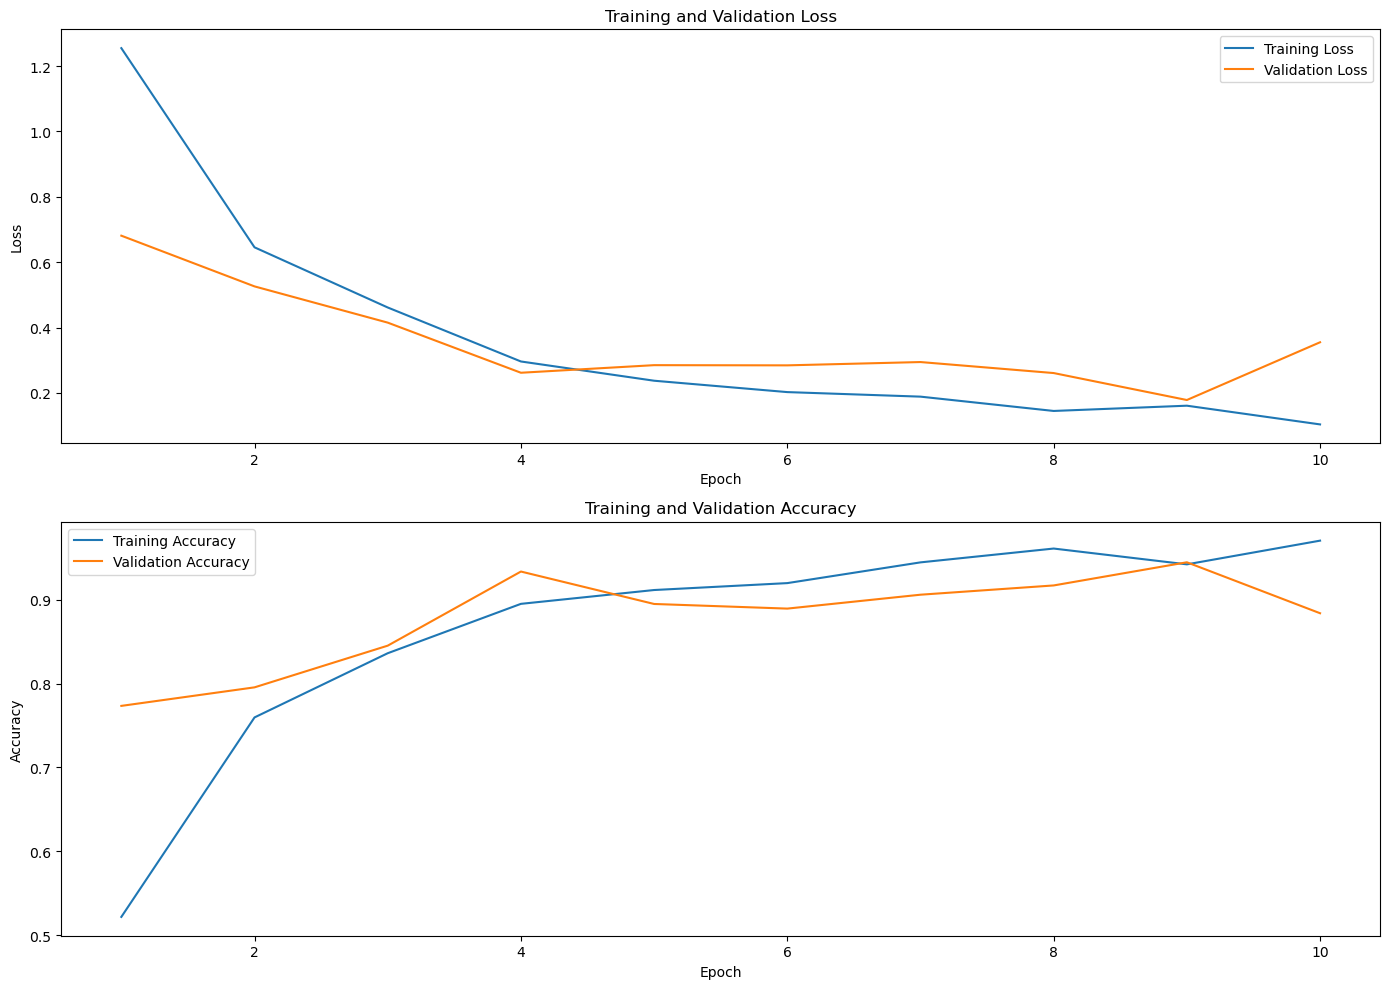

Test Loss: 0.36991566279903054, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 38
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.3010696782558053, Train Accuracy: 0.4958775029446408, Val Loss: 0.7071737051010132, Val Accuracy: 0.7734806629834254
Epoch 1, Train Loss: 0.7203229847881529, Train Accuracy: 0.7220259128386337, Val Loss: 0.5621937103569508, Val Accuracy: 0.7790055248618785
Epoch 2, Train Loss: 0.5337308268235238, Train Accuracy: 0.8197879858657244, Val Loss: 0.4734875013430913, Val Accuracy: 0.8232044198895028
Epoch 3, Train Loss: 0.3744895695536225, Train Accuracy: 0.8610129564193169, Val Loss: 0.3117918452868859, Val Accuracy: 0.9116022099447514
Epoch 4, Train Loss: 0.30471091696785557, Train Accuracy: 0.8833922261484098, Val Loss: 0.31536264531314373, Val Accuracy: 0.90055248618

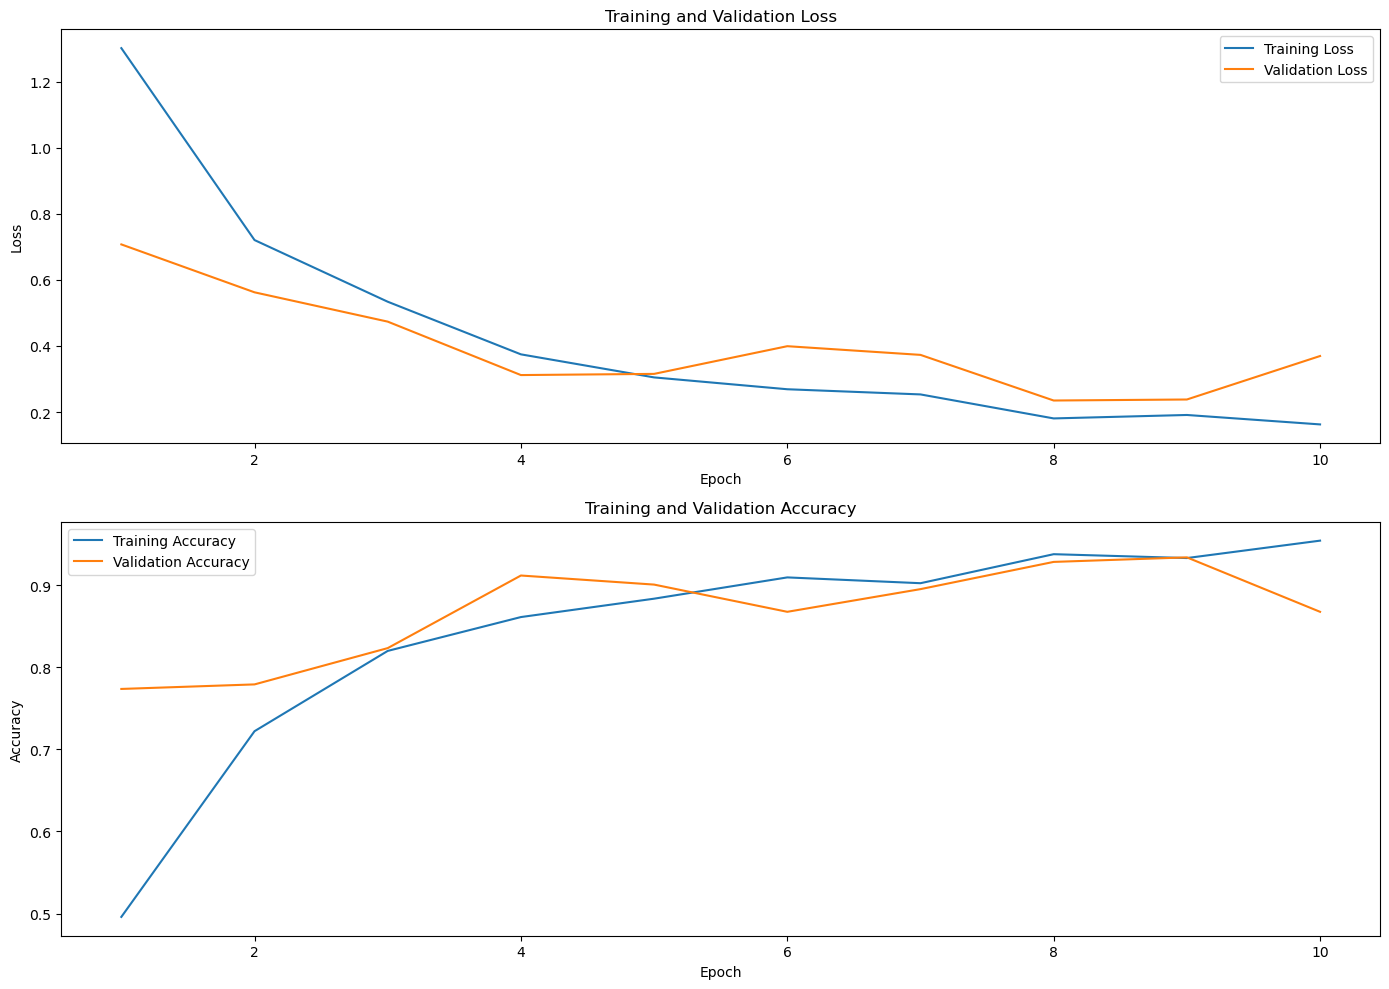

Test Loss: 0.37950568009788793, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 39
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.4117657702278208, Train Accuracy: 0.4534746760895171, Val Loss: 0.7595760077238083, Val Accuracy: 0.7348066298342542
Epoch 1, Train Loss: 0.8204061482791547, Train Accuracy: 0.7031802120141343, Val Loss: 0.6540100624163946, Val Accuracy: 0.7403314917127072
Epoch 2, Train Loss: 0.6299097275844326, Train Accuracy: 0.7597173144876325, Val Loss: 0.5172366946935654, Val Accuracy: 0.8232044198895028
Epoch 3, Train Loss: 0.47449967948098976, Train Accuracy: 0.8256772673733804, Val Loss: 0.4467957702775796, Val Accuracy: 0.8674033149171271
Epoch 4, Train Loss: 0.40123509477686, Train Accuracy: 0.8610129564193169, Val Loss: 0.3333755520482858, Val Accuracy: 0.88950276243093

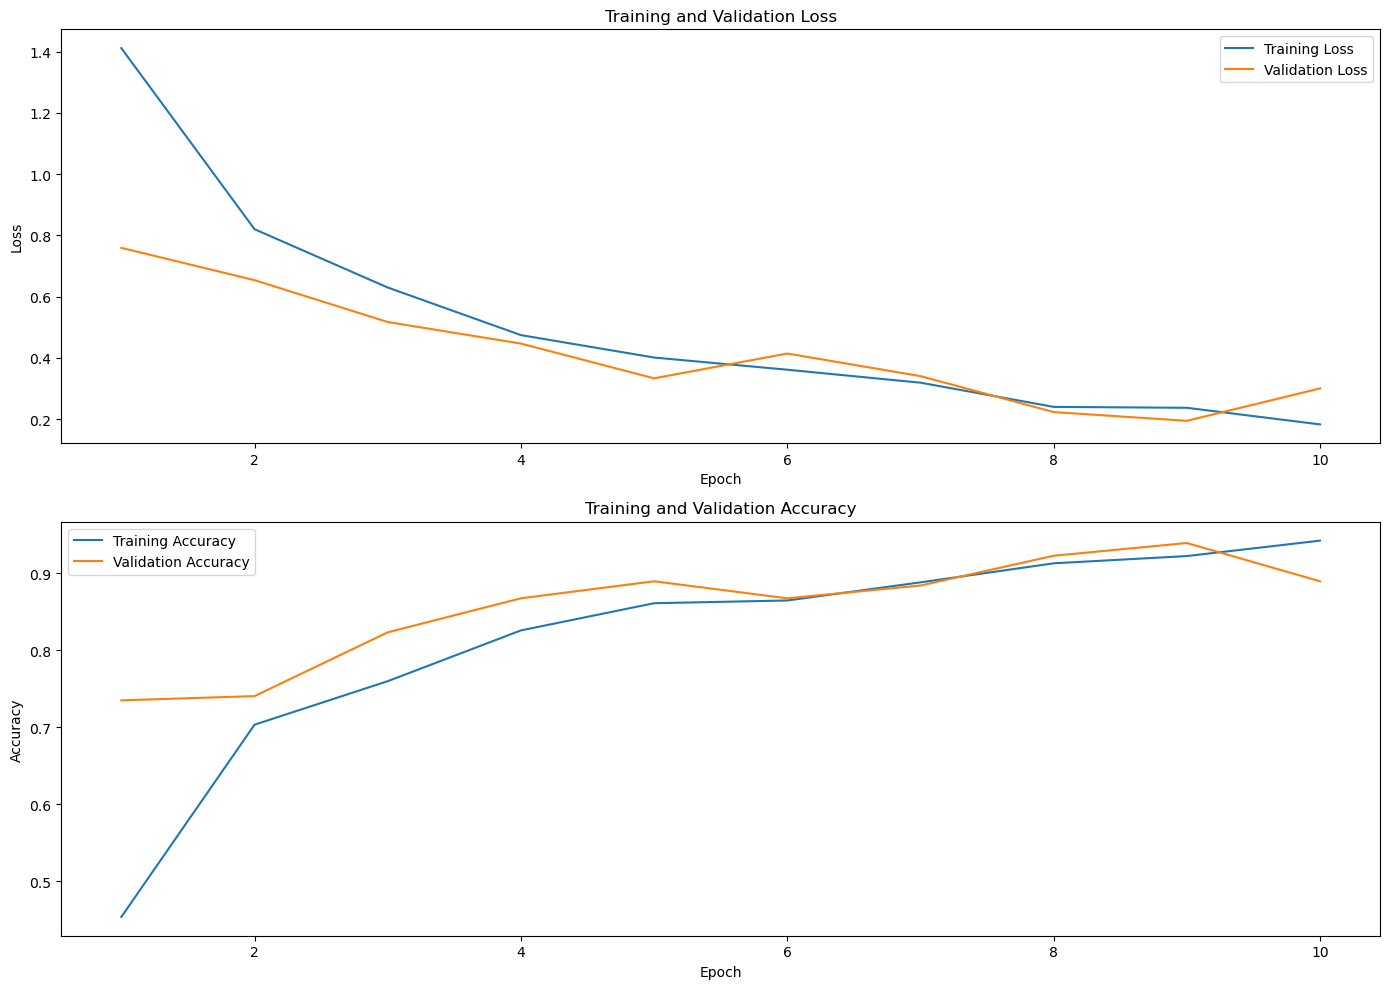

Test Loss: 0.35771262692287564, Test Accuracy: 0.8579234972677595
************************************************************************
************************************************************************
Experiment: 40
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.5566828782083812, Train Accuracy: 0.40518256772673733, Val Loss: 0.9541303763786951, Val Accuracy: 0.6519337016574586
Epoch 1, Train Loss: 1.0303052696916792, Train Accuracy: 0.6018845700824499, Val Loss: 0.7854857295751572, Val Accuracy: 0.6961325966850829
Epoch 2, Train Loss: 0.8559895709708885, Train Accuracy: 0.6796230859835101, Val Loss: 0.5532948523759842, Val Accuracy: 0.8784530386740331
Epoch 3, Train Loss: 0.6751619150896592, Train Accuracy: 0.7420494699646644, Val Loss: 0.48100167016188305, Val Accuracy: 0.8784530386740331
Epoch 4, Train Loss: 0.607539180804182, Train Accuracy: 0.7773851590106007, Val Loss: 0.4237118735909462, Val Accuracy: 0.872928176795

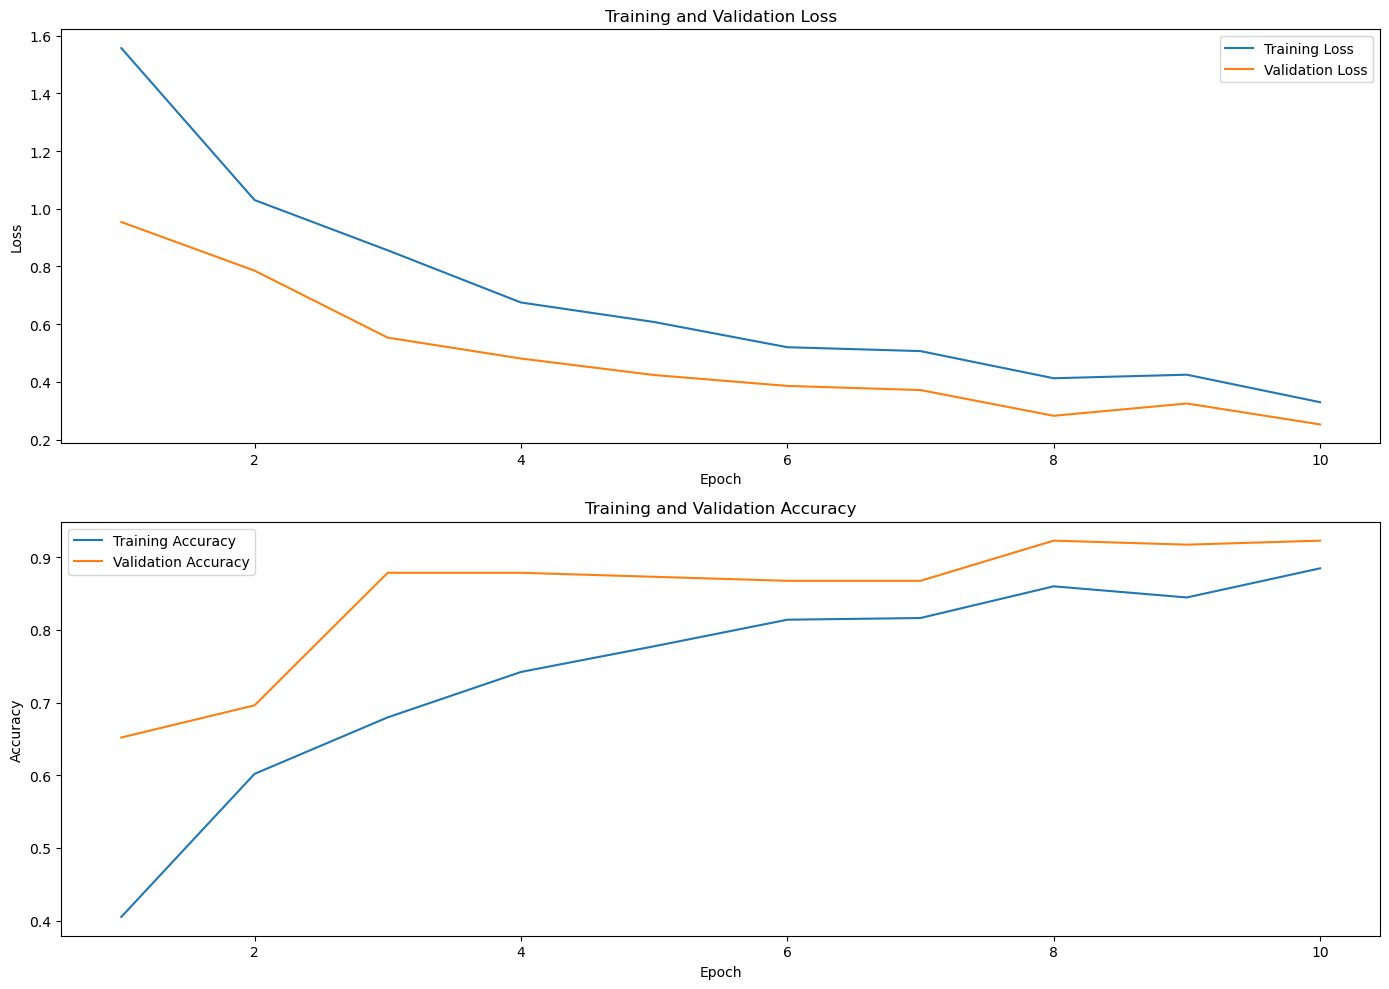

Test Loss: 0.309840926900506, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 41
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512, 256]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.2706857764472563, Train Accuracy: 0.48881036513545345, Val Loss: 0.8800587256749471, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.794188301872324, Train Accuracy: 0.7090694935217904, Val Loss: 0.7147058819731077, Val Accuracy: 0.7403314917127072
Epoch 2, Train Loss: 0.6132684403823482, Train Accuracy: 0.7856301531213192, Val Loss: 0.46729107946157455, Val Accuracy: 0.8674033149171271
Epoch 3, Train Loss: 0.41622895609449456, Train Accuracy: 0.8551236749116607, Val Loss: 0.3042449504137039, Val Accuracy: 0.9171270718232044
Epoch 4, Train Loss: 0.31125341079853197, Train Accuracy: 0.8975265017667845, Val Loss: 0.33886459718147915, Val Accuracy: 0.8563535

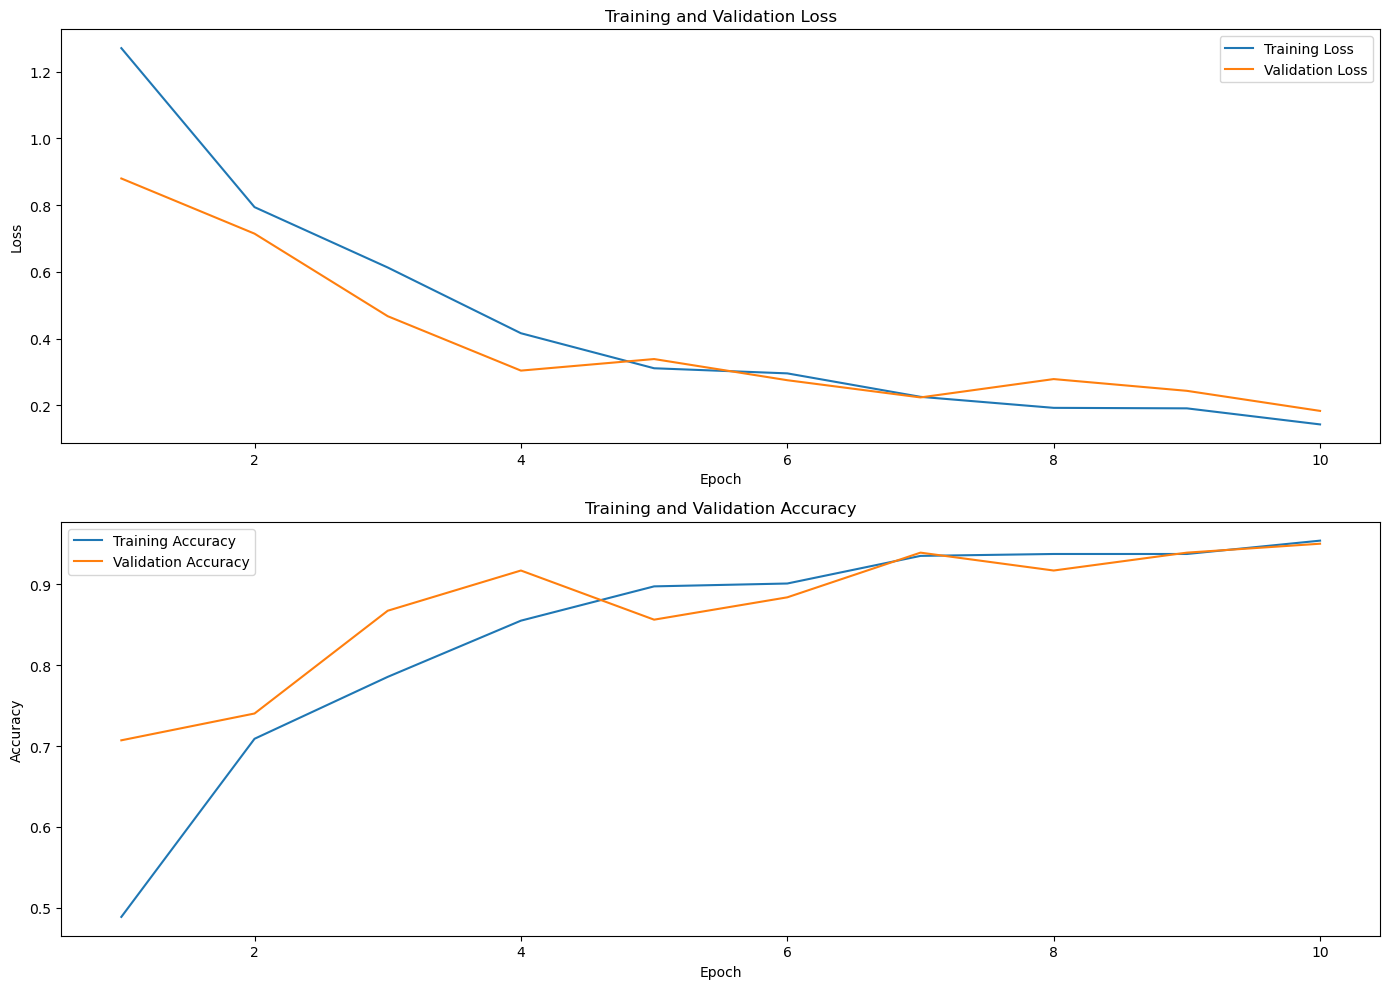

Test Loss: 0.16808540125687918, Test Accuracy: 0.9508196721311475
************************************************************************
************************************************************************
Experiment: 42
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512, 256]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.3803928704173476, Train Accuracy: 0.408716136631331, Val Loss: 1.0447966307401657, Val Accuracy: 0.6408839779005525
Epoch 1, Train Loss: 1.011477028882062, Train Accuracy: 0.6277974087161367, Val Loss: 0.7412617305914561, Val Accuracy: 0.7624309392265194
Epoch 2, Train Loss: 0.7693757762511572, Train Accuracy: 0.7208480565371025, Val Loss: 0.6101397971312205, Val Accuracy: 0.8066298342541437
Epoch 3, Train Loss: 0.6102304690414004, Train Accuracy: 0.7762073027090695, Val Loss: 0.421879380941391, Val Accuracy: 0.861878453038674
Epoch 4, Train Loss: 0.5142788663506508, Train Accuracy: 0.8150765606595995, Val Loss: 0.38410893827676773, Val Accuracy: 0.867403314917

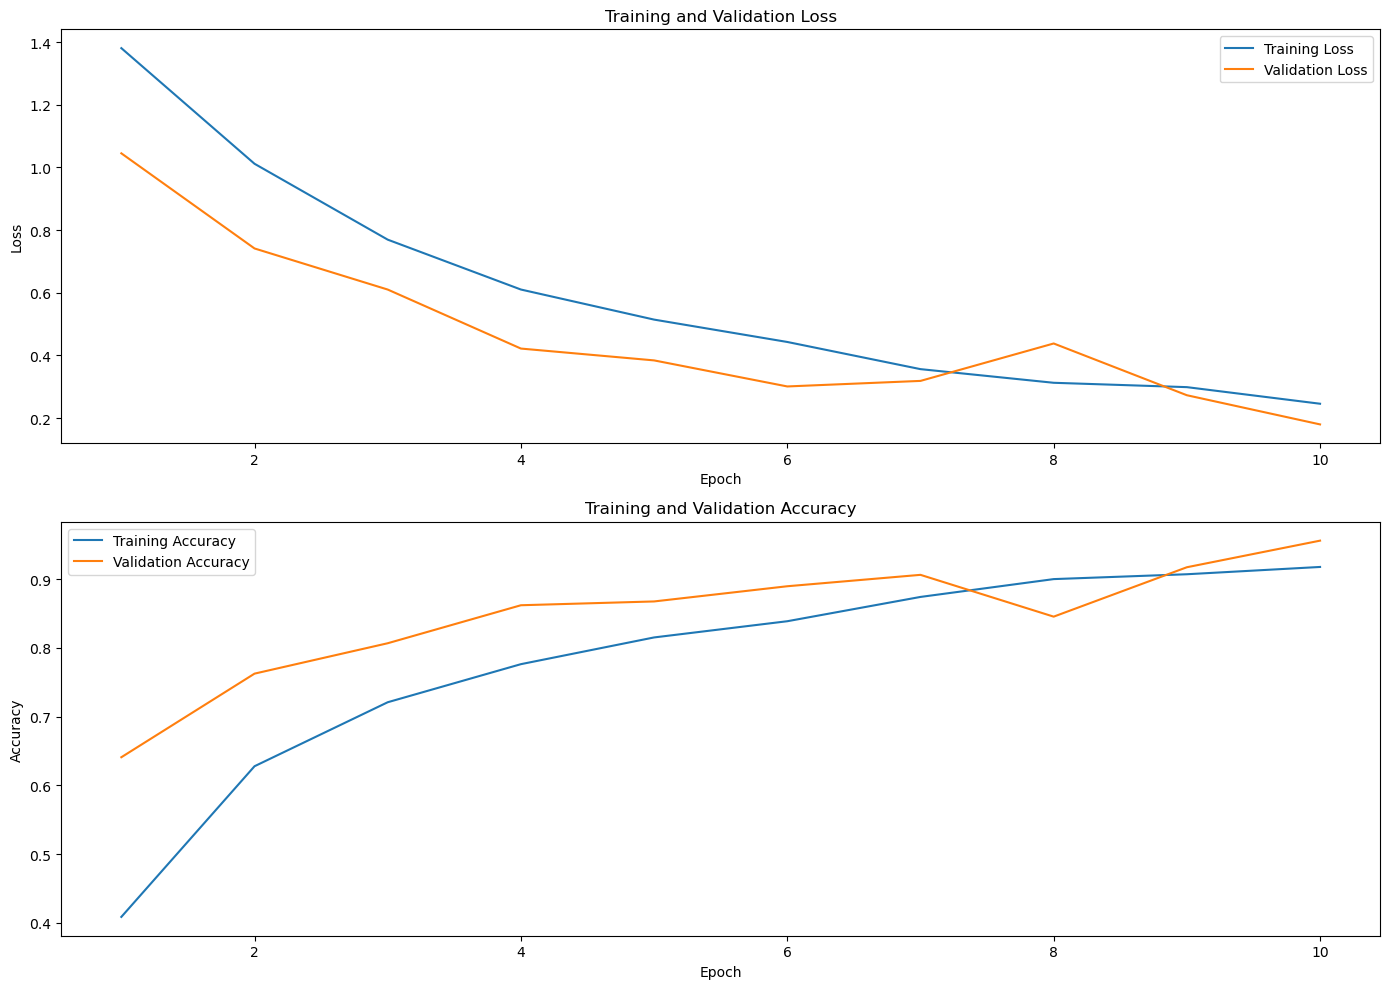

Test Loss: 0.21813568100333214, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 43
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512, 256]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.5527285243625994, Train Accuracy: 0.2921083627797409, Val Loss: 1.2486820419629414, Val Accuracy: 0.585635359116022
Epoch 1, Train Loss: 1.2666404986823048, Train Accuracy: 0.48998822143698467, Val Loss: 0.980546439687411, Val Accuracy: 0.6740331491712708
Epoch 2, Train Loss: 1.110462159746223, Train Accuracy: 0.552414605418139, Val Loss: 0.8298704872528712, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 0.938556209758476, Train Accuracy: 0.657243816254417, Val Loss: 0.6454445545872053, Val Accuracy: 0.8121546961325967
Epoch 4, Train Loss: 0.8249297732556308, Train Accuracy: 0.696113074204947, Val Loss: 0.5859755525986353, Val Accuracy: 0.801104972375690

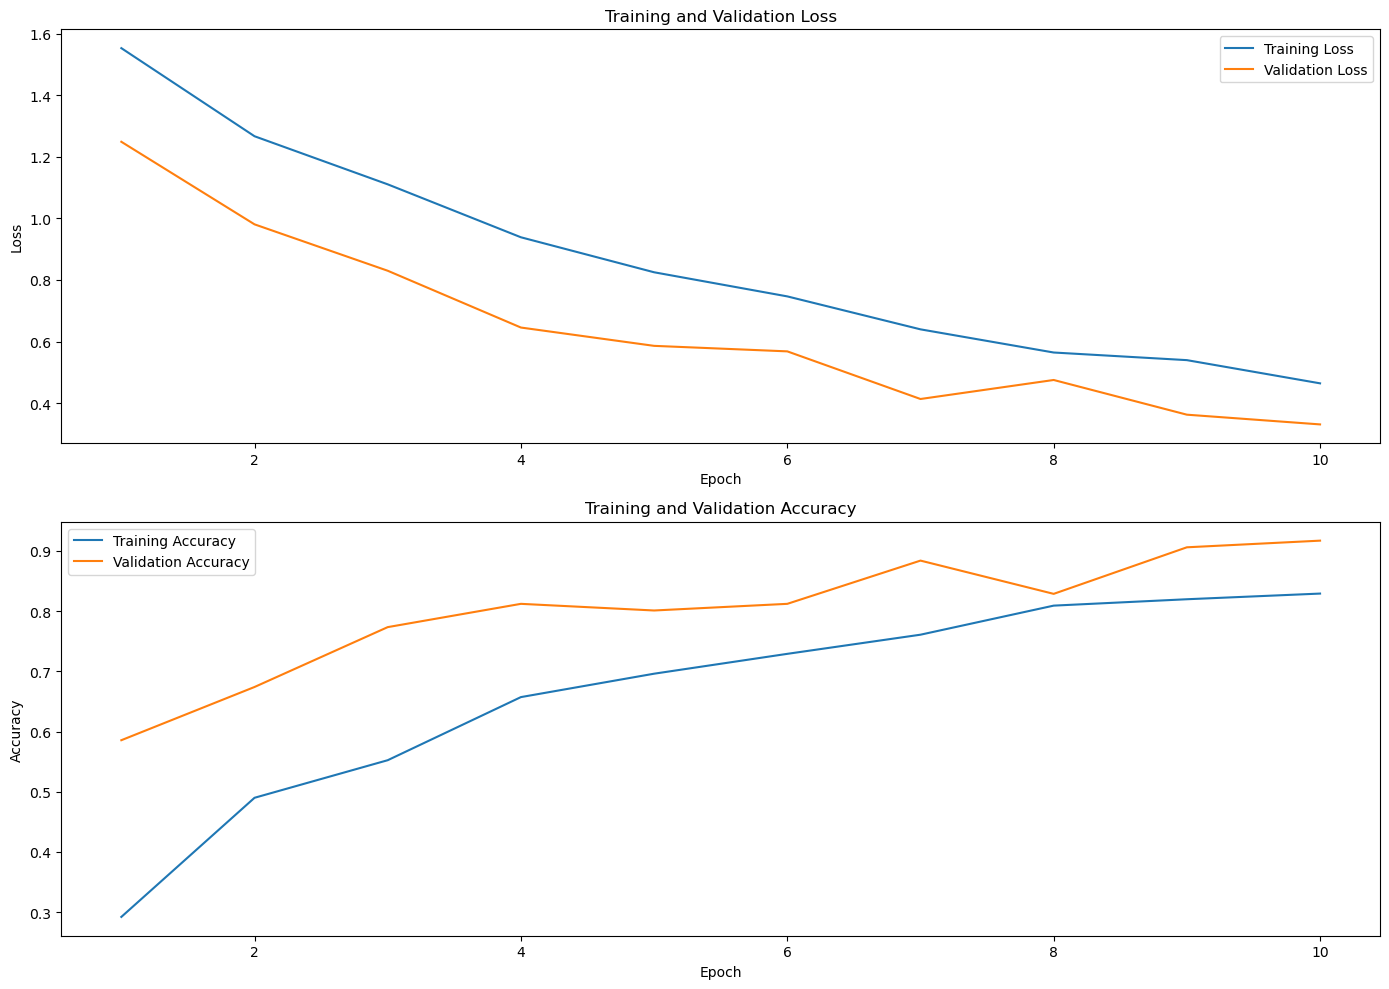

Test Loss: 0.39195942506194115, Test Accuracy: 0.8743169398907104
************************************************************************
************************************************************************
Experiment: 44
batch_size= 16
learning_rate= 0.0001
hidden_layers= [512, 256]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.728184872203403, Train Accuracy: 0.254416961130742, Val Loss: 1.464846630891164, Val Accuracy: 0.44751381215469616
Epoch 1, Train Loss: 1.598630878660414, Train Accuracy: 0.2826855123674912, Val Loss: 1.3368201553821564, Val Accuracy: 0.6022099447513812
Epoch 2, Train Loss: 1.5019389964916088, Train Accuracy: 0.3651354534746761, Val Loss: 1.2621857523918152, Val Accuracy: 0.6740331491712708
Epoch 3, Train Loss: 1.403443901627152, Train Accuracy: 0.4216725559481743, Val Loss: 1.131690005461375, Val Accuracy: 0.8011049723756906
Epoch 4, Train Loss: 1.3059515522585974, Train Accuracy: 0.4499411071849234, Val Loss: 1.049351175626119, Val Accuracy: 0.685082872928176

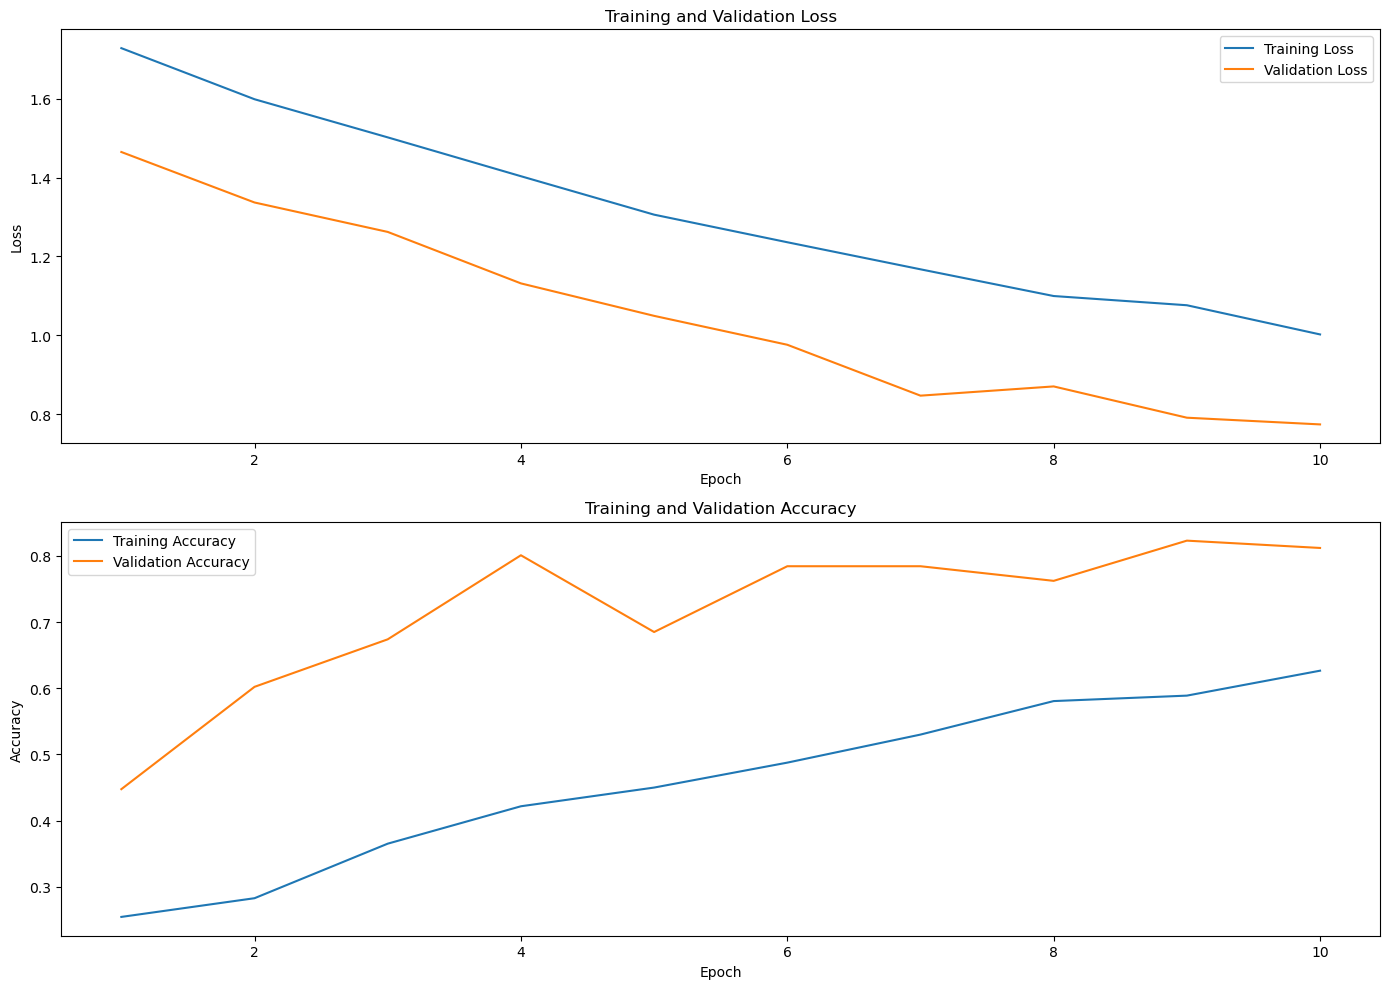

Test Loss: 0.79496169090271, Test Accuracy: 0.7377049180327869
************************************************************************
************************************************************************
Experiment: 45
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024, 512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.261441680016341, Train Accuracy: 0.46878680800942285, Val Loss: 0.9092559268077215, Val Accuracy: 0.6408839779005525
Epoch 1, Train Loss: 0.7228211803292787, Train Accuracy: 0.7526501766784452, Val Loss: 0.7269723663727442, Val Accuracy: 0.7679558011049724
Epoch 2, Train Loss: 0.5165589942976281, Train Accuracy: 0.8315665488810365, Val Loss: 0.6462761188546816, Val Accuracy: 0.7292817679558011
Epoch 3, Train Loss: 0.39404594953413363, Train Accuracy: 0.8716136631330977, Val Loss: 0.3359616200129191, Val Accuracy: 0.8895027624309392
Epoch 4, Train Loss: 0.324890311083032, Train Accuracy: 0.8975265017667845, Val Loss: 0.3243829930822055, Val Accuracy: 0.86740331491

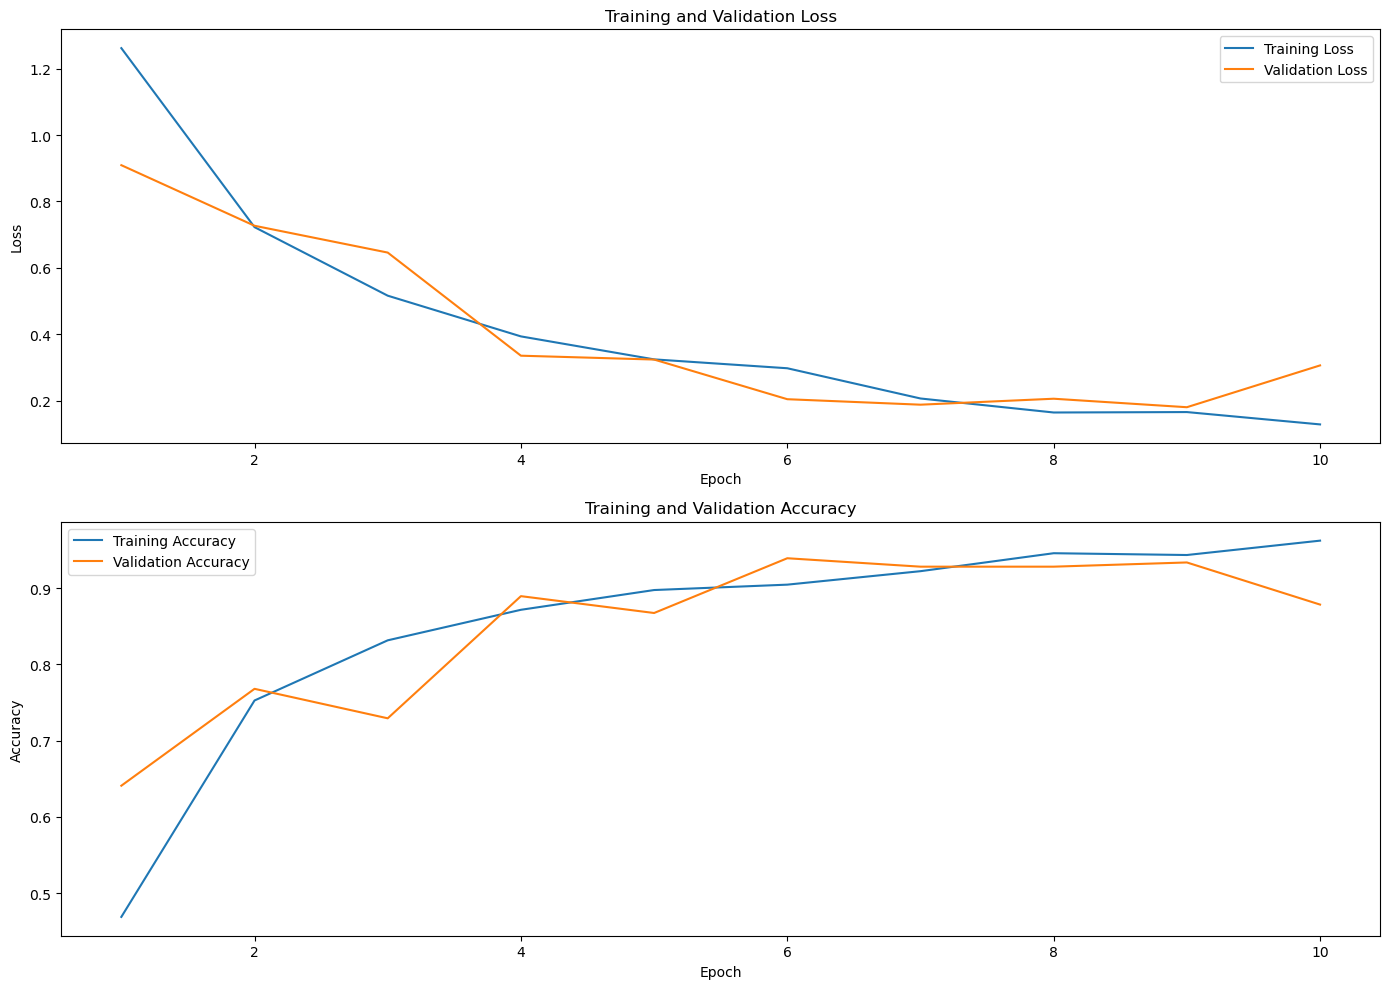

Test Loss: 0.30456748604774475, Test Accuracy: 0.8907103825136612
************************************************************************
************************************************************************
Experiment: 46
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024, 512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.3767867695402216, Train Accuracy: 0.40636042402826855, Val Loss: 0.889326478044192, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.8728627981962981, Train Accuracy: 0.6925795053003534, Val Loss: 0.7628191535671552, Val Accuracy: 0.7348066298342542
Epoch 2, Train Loss: 0.6396608336104287, Train Accuracy: 0.7656065959952886, Val Loss: 0.6985557427008947, Val Accuracy: 0.7403314917127072
Epoch 3, Train Loss: 0.5516967071151292, Train Accuracy: 0.8115429917550059, Val Loss: 0.3654220402240753, Val Accuracy: 0.8839779005524862
Epoch 4, Train Loss: 0.4226821041493504, Train Accuracy: 0.856301531213192, Val Loss: 0.3385388193031152, Val Accuracy: 0.850828729

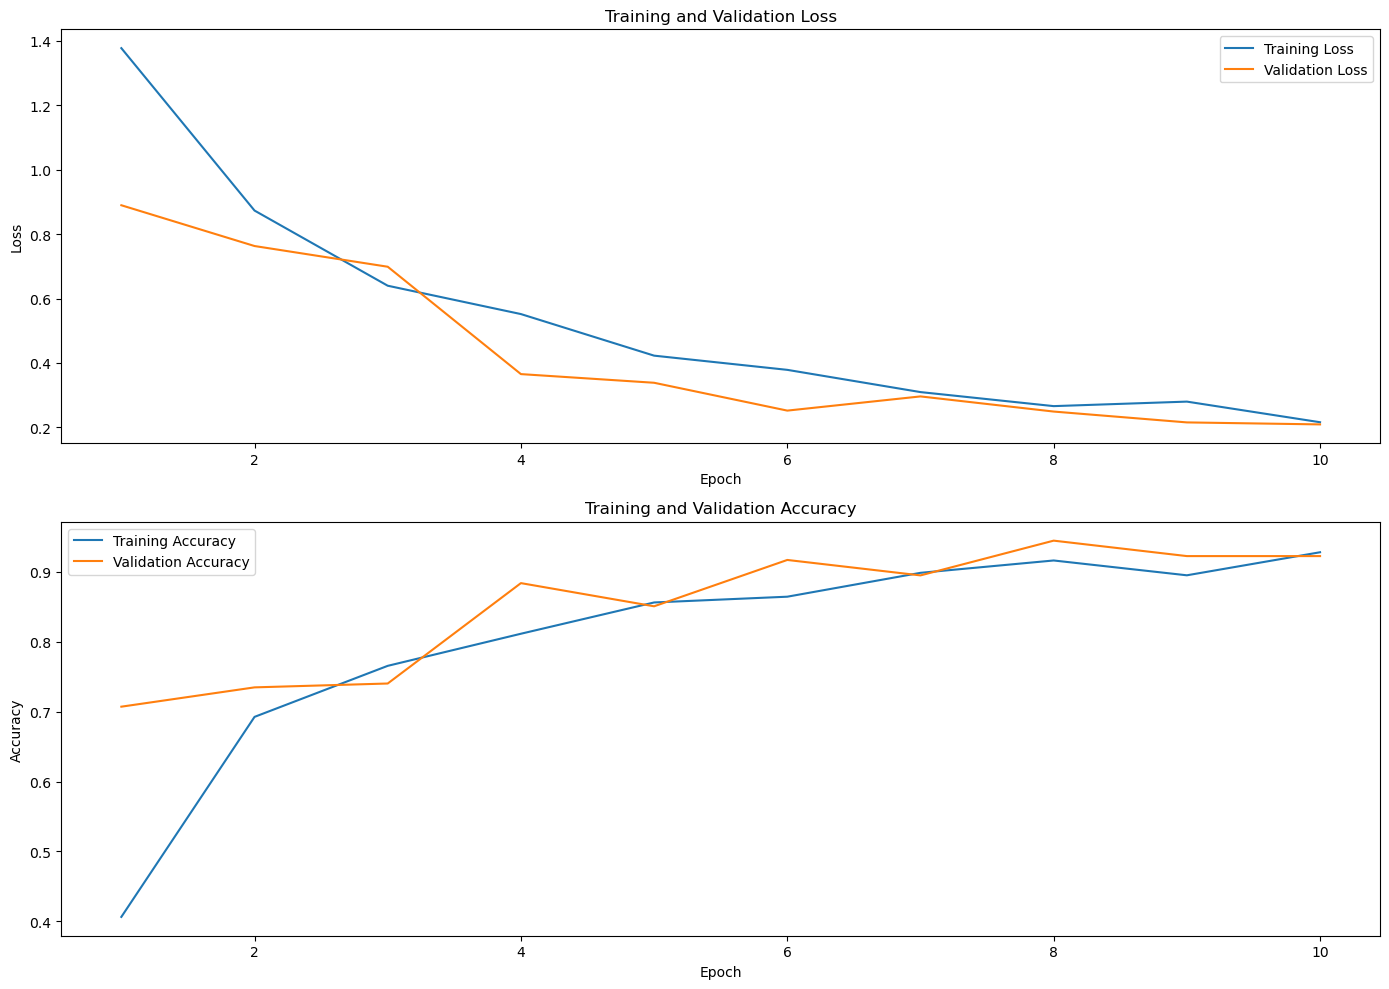

Test Loss: 0.2086191624403, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 47
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024, 512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.5094472368558247, Train Accuracy: 0.3451118963486455, Val Loss: 1.1433417350053787, Val Accuracy: 0.580110497237569
Epoch 1, Train Loss: 1.1183327076335747, Train Accuracy: 0.5630153121319199, Val Loss: 0.8799712111552557, Val Accuracy: 0.7237569060773481
Epoch 2, Train Loss: 0.944660879947521, Train Accuracy: 0.6466431095406361, Val Loss: 0.7545286963383356, Val Accuracy: 0.7403314917127072
Epoch 3, Train Loss: 0.7846636653498367, Train Accuracy: 0.7055359246171967, Val Loss: 0.5612736667195956, Val Accuracy: 0.8397790055248618
Epoch 4, Train Loss: 0.7099072464086391, Train Accuracy: 0.7526501766784452, Val Loss: 0.5200143406788508, Val Accuracy: 0.83425414364640

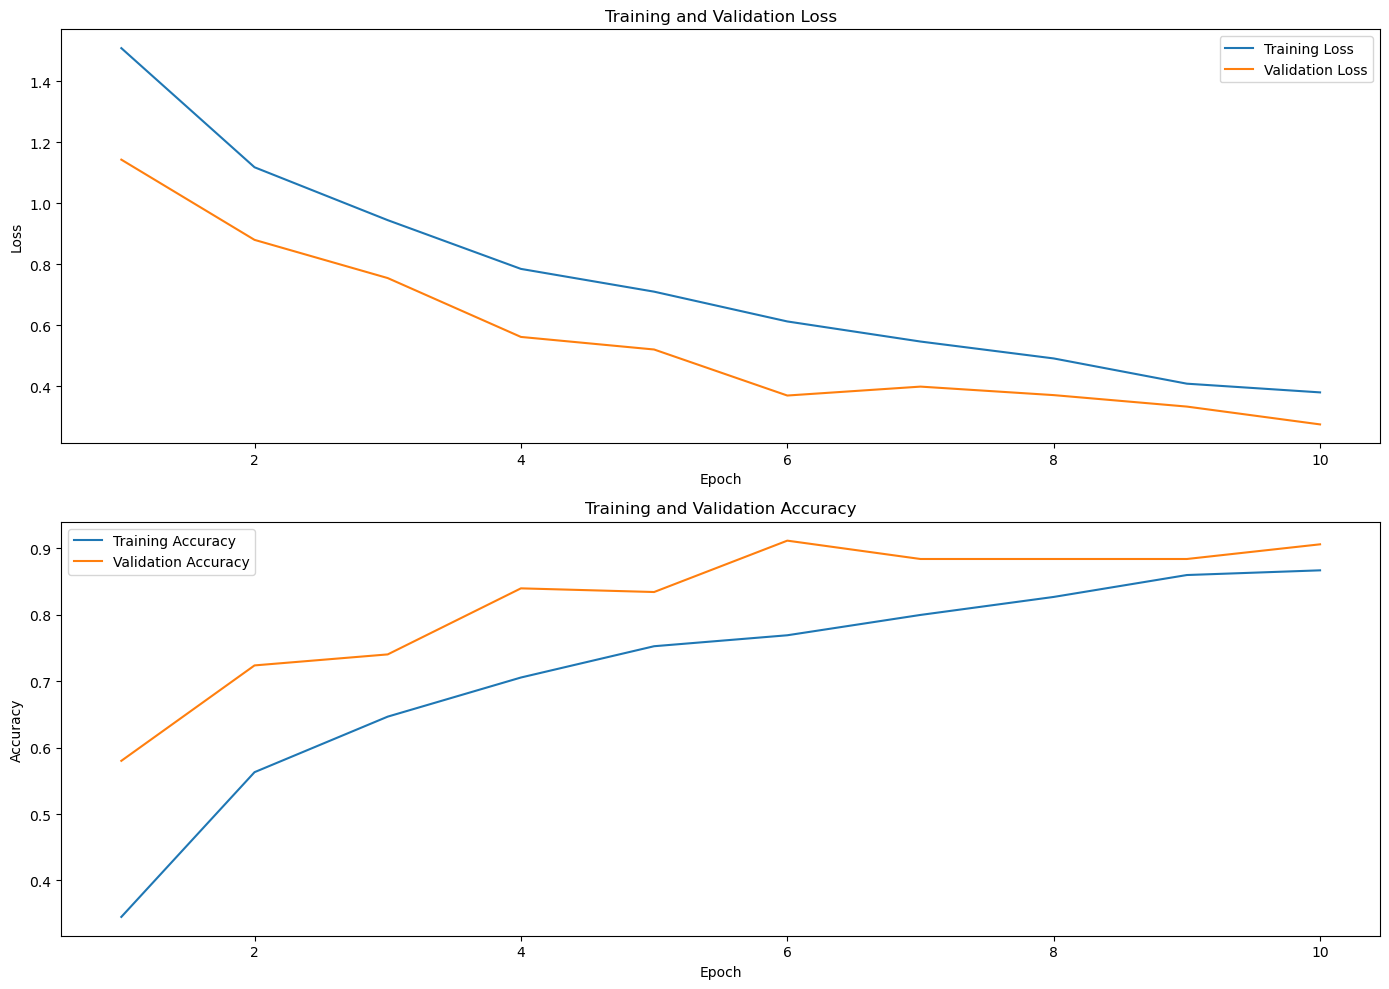

Test Loss: 0.2830823448797067, Test Accuracy: 0.8961748633879781
************************************************************************
************************************************************************
Experiment: 48
batch_size= 16
learning_rate= 0.0001
hidden_layers= [1024, 512]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.7644741778020505, Train Accuracy: 0.2508833922261484, Val Loss: 1.4075119992097218, Val Accuracy: 0.5082872928176796
Epoch 1, Train Loss: 1.5998197308293096, Train Accuracy: 0.3027090694935218, Val Loss: 1.289419839779536, Val Accuracy: 0.580110497237569
Epoch 2, Train Loss: 1.4344020861166495, Train Accuracy: 0.42285041224970554, Val Loss: 1.1263322085142136, Val Accuracy: 0.6408839779005525
Epoch 3, Train Loss: 1.258733084908238, Train Accuracy: 0.4840989399293286, Val Loss: 0.9731599738200506, Val Accuracy: 0.7071823204419889
Epoch 4, Train Loss: 1.216542375308496, Train Accuracy: 0.5453474676089517, Val Loss: 0.8587589810291926, Val Accuracy: 0.767955801104

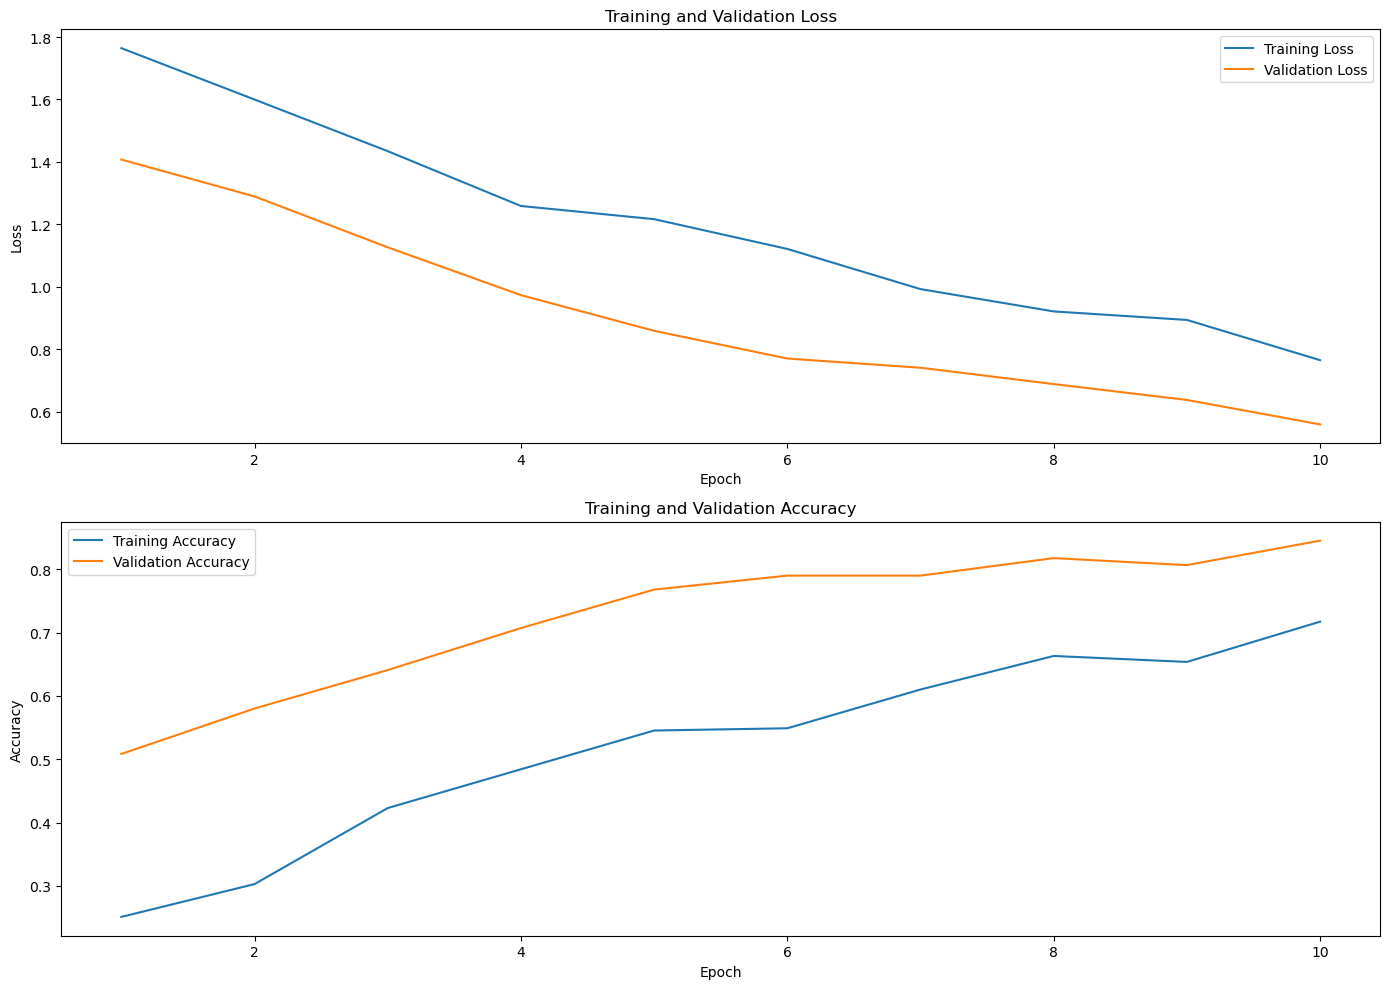

Test Loss: 0.5716479221979777, Test Accuracy: 0.8087431693989071
************************************************************************
************************************************************************
Experiment: 49
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.2193171977996826, Train Accuracy: 0.5076560659599529, Val Loss: 0.7973044862349828, Val Accuracy: 0.7403314917127072
Epoch 1, Train Loss: 0.690206762265276, Train Accuracy: 0.7656065959952886, Val Loss: 0.6493394722541174, Val Accuracy: 0.7790055248618785
Epoch 2, Train Loss: 0.5028575067925785, Train Accuracy: 0.839811542991755, Val Loss: 0.49091867357492447, Val Accuracy: 0.8453038674033149
Epoch 3, Train Loss: 0.411980382822178, Train Accuracy: 0.8751472320376914, Val Loss: 0.3717210677762826, Val Accuracy: 0.8895027624309392
Epoch 4, Train Loss: 0.31028749366049413, Train Accuracy: 0.9104829210836278, Val Loss: 0.26941218599677086, Val Accuracy: 0.9392265193370166

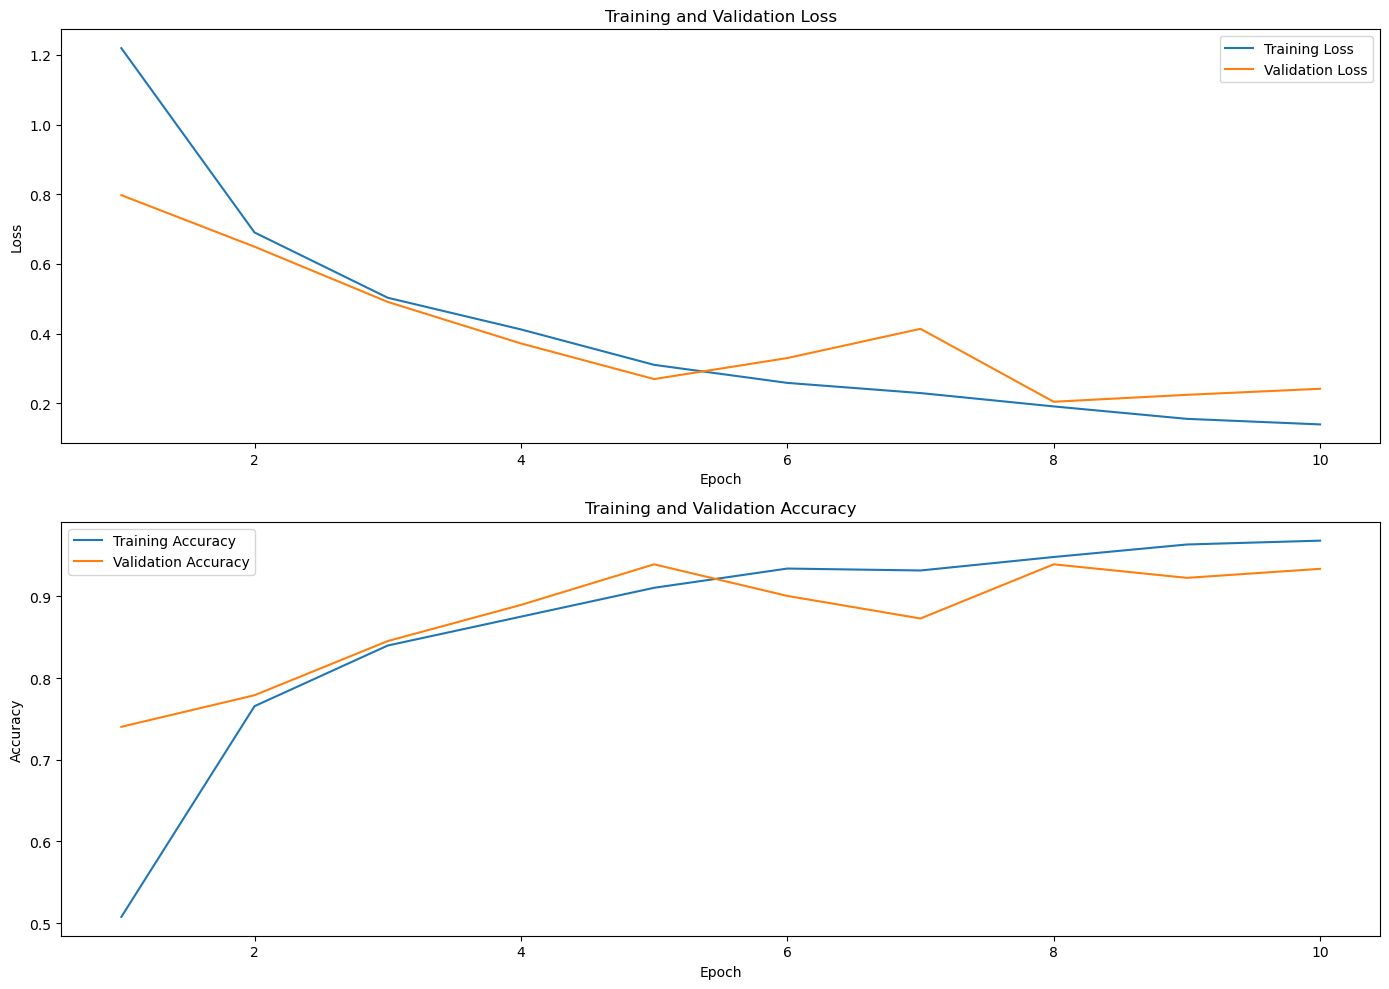

Test Loss: 0.2922840667888522, Test Accuracy: 0.9234972677595629
************************************************************************
************************************************************************
Experiment: 50
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.2992502464740365, Train Accuracy: 0.4652532391048292, Val Loss: 0.8578720241785049, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.7897804307716864, Train Accuracy: 0.71849234393404, Val Loss: 0.6858453005552292, Val Accuracy: 0.7679558011049724
Epoch 2, Train Loss: 0.5894472862904271, Train Accuracy: 0.7997644287396938, Val Loss: 0.5300102457404137, Val Accuracy: 0.8453038674033149
Epoch 3, Train Loss: 0.4897088941048693, Train Accuracy: 0.8421672555948174, Val Loss: 0.4245634910960992, Val Accuracy: 0.8895027624309392
Epoch 4, Train Loss: 0.38412627908918595, Train Accuracy: 0.8869257950530035, Val Loss: 0.3016922604292631, Val Accuracy: 0.9226519337016574


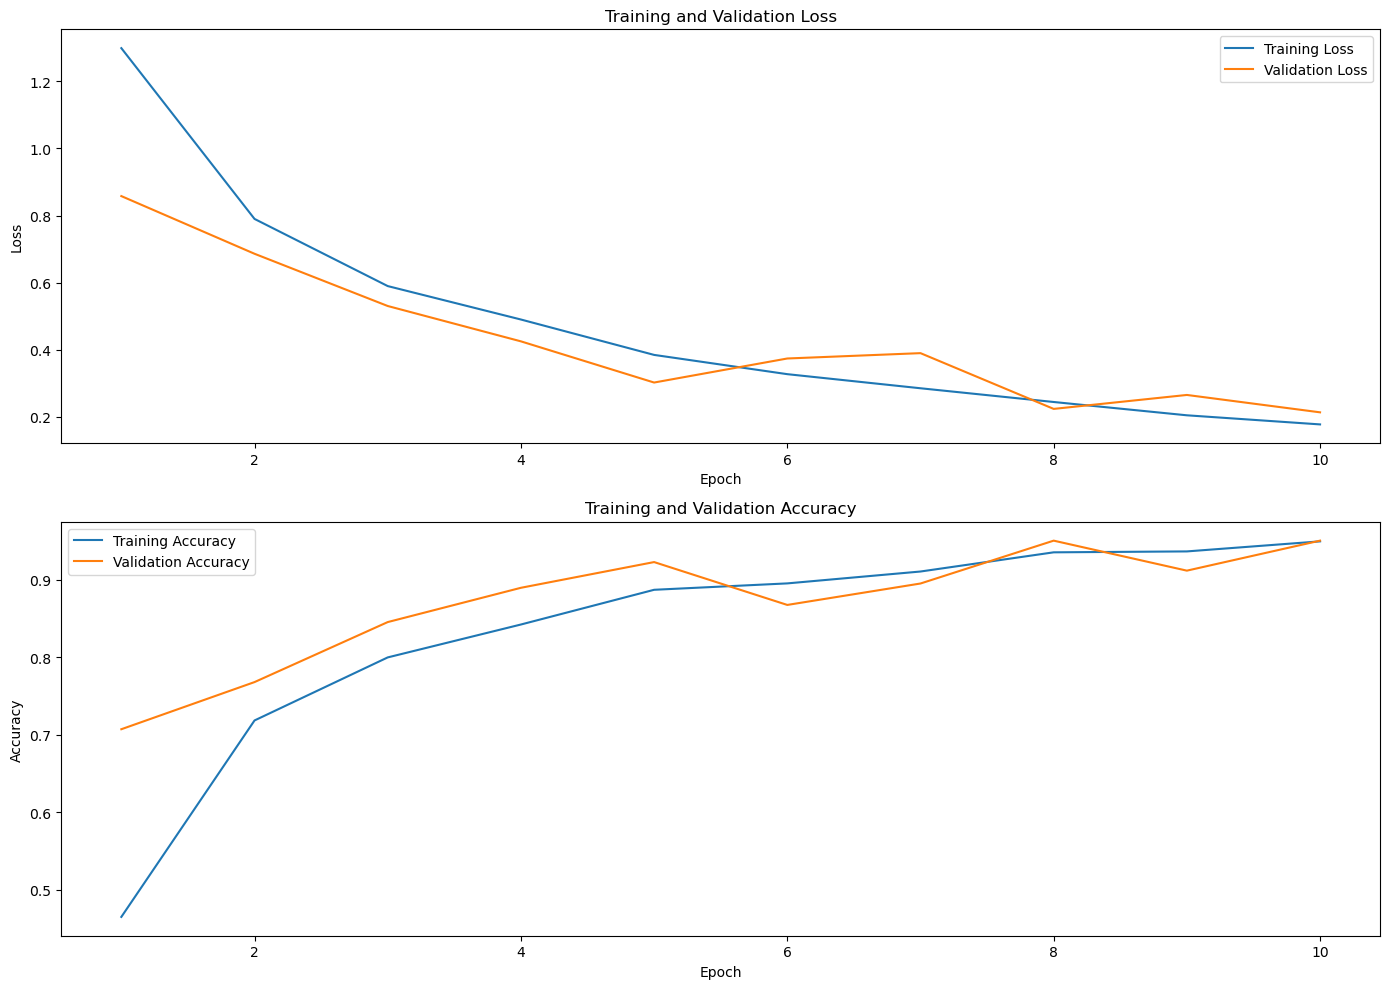

Test Loss: 0.2594543754433592, Test Accuracy: 0.9508196721311475
************************************************************************
************************************************************************
Experiment: 51
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.3934495206232425, Train Accuracy: 0.41460541813898705, Val Loss: 0.9092474927504858, Val Accuracy: 0.7237569060773481
Epoch 1, Train Loss: 0.9140762212099852, Train Accuracy: 0.6749116607773852, Val Loss: 0.7585739865899086, Val Accuracy: 0.7679558011049724
Epoch 2, Train Loss: 0.7249396617041418, Train Accuracy: 0.7373380447585395, Val Loss: 0.5845621402064959, Val Accuracy: 0.7955801104972375
Epoch 3, Train Loss: 0.5947274518785653, Train Accuracy: 0.7797408716136631, Val Loss: 0.47806383669376373, Val Accuracy: 0.8950276243093923
Epoch 4, Train Loss: 0.4859780625060753, Train Accuracy: 0.8374558303886925, Val Loss: 0.3875759293635686, Val Accuracy: 0.91160220994475

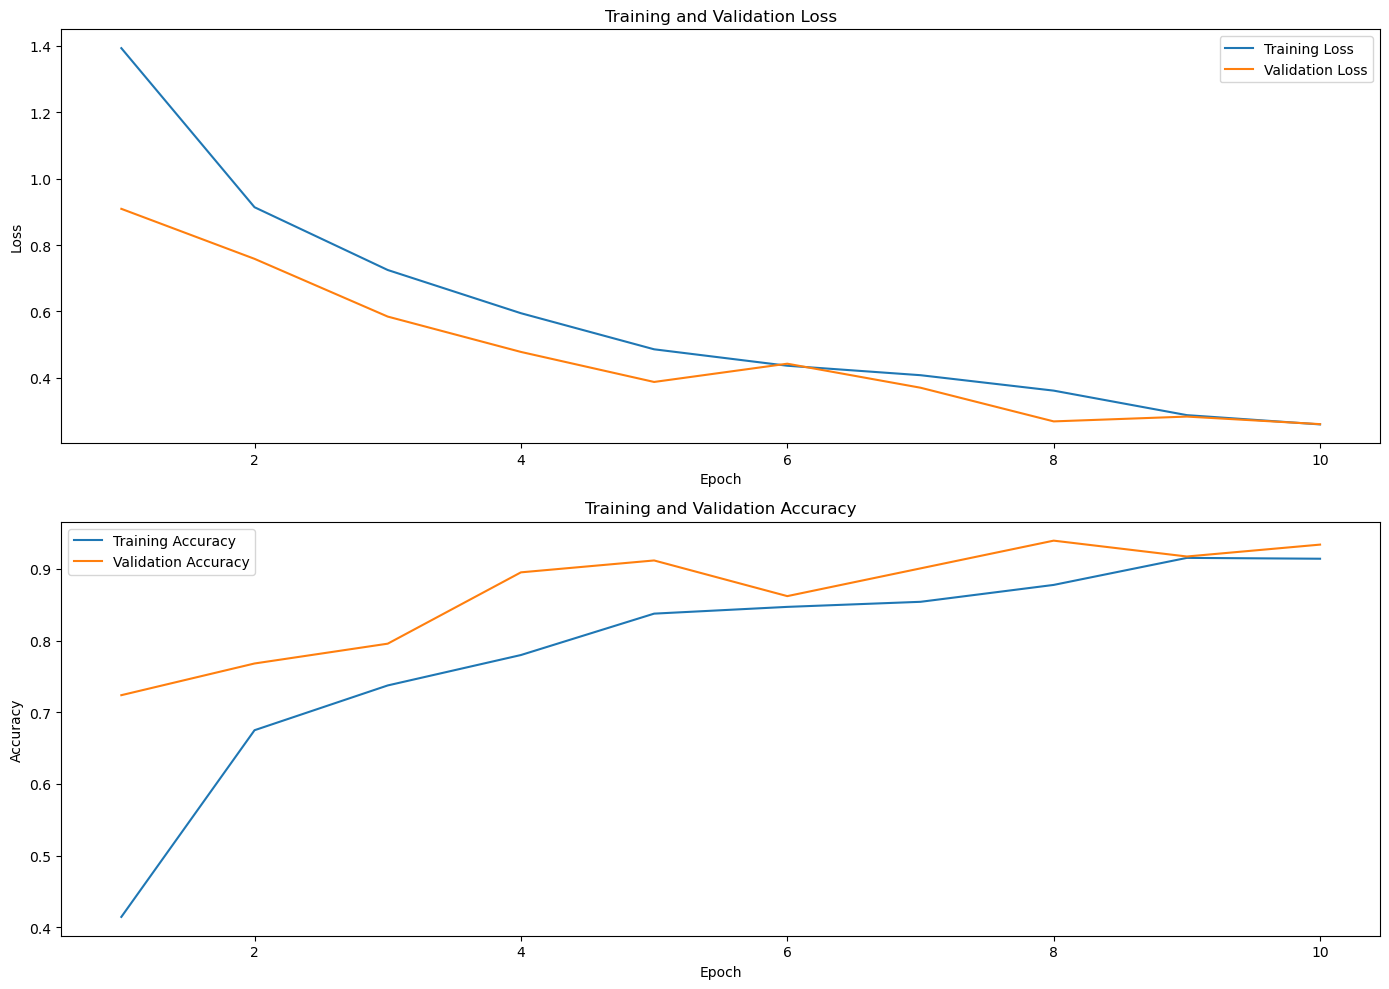

Test Loss: 0.29020961311956245, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 52
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.5523147538856223, Train Accuracy: 0.336866902237927, Val Loss: 1.0206557214260101, Val Accuracy: 0.7016574585635359
Epoch 1, Train Loss: 1.1236057491214186, Train Accuracy: 0.5453474676089517, Val Loss: 0.884989008307457, Val Accuracy: 0.7292817679558011
Epoch 2, Train Loss: 0.9335735267097199, Train Accuracy: 0.6501766784452296, Val Loss: 0.6928079128265381, Val Accuracy: 0.7679558011049724
Epoch 3, Train Loss: 0.8382057266102897, Train Accuracy: 0.6831566548881036, Val Loss: 0.6248662769794464, Val Accuracy: 0.8287292817679558
Epoch 4, Train Loss: 0.7044494488724956, Train Accuracy: 0.7502944640753828, Val Loss: 0.5476744448145231, Val Accuracy: 0.856353591160221
E

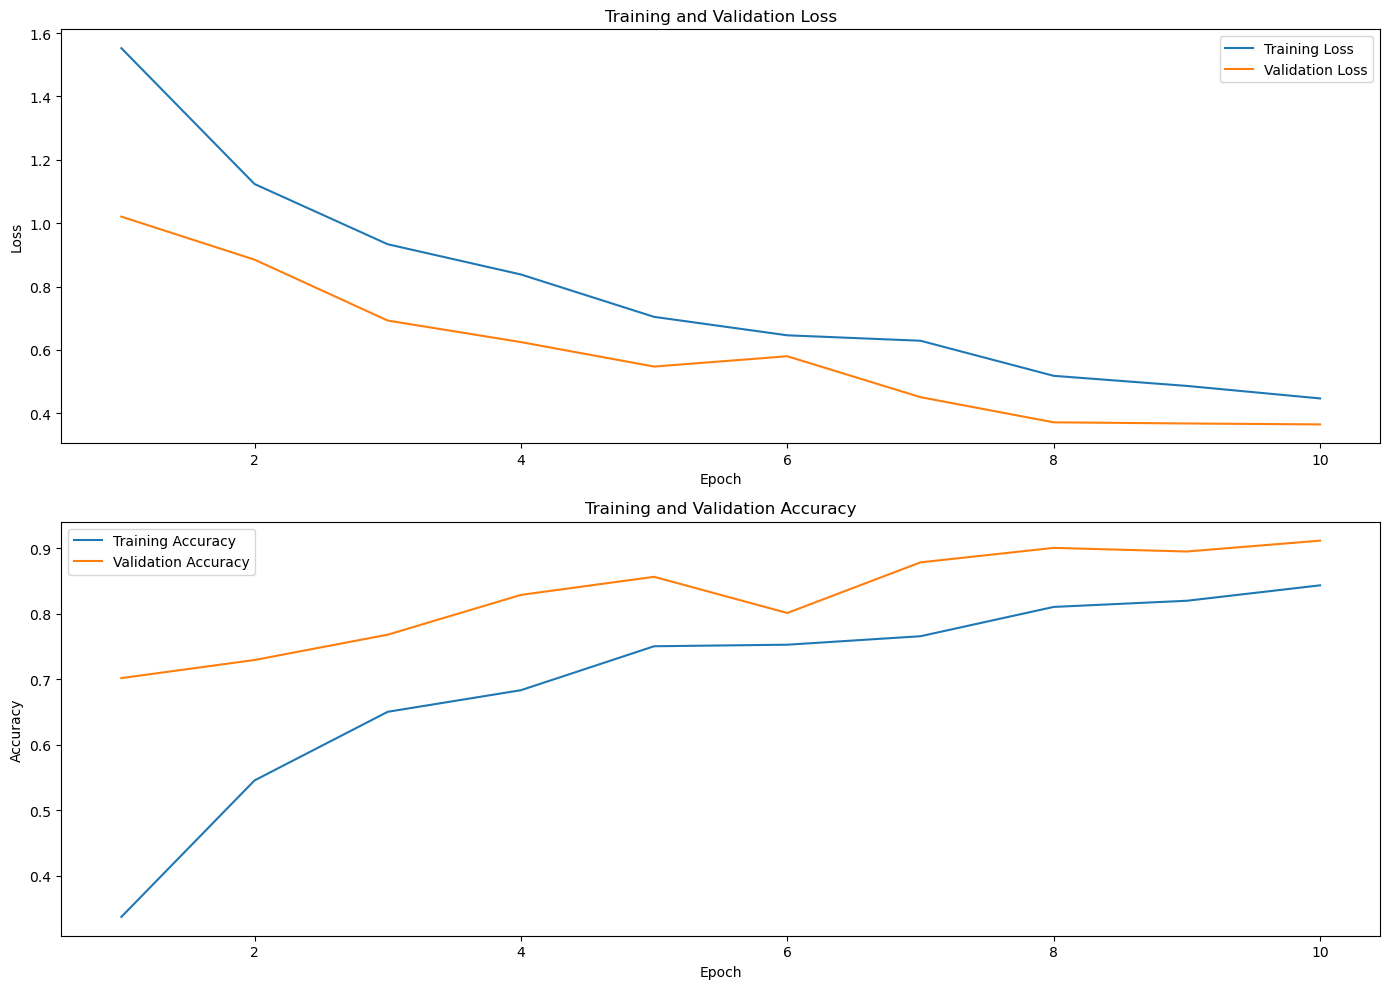

Test Loss: 0.3780339391281207, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 53
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.2557009814514055, Train Accuracy: 0.4958775029446408, Val Loss: 0.7895300487677256, Val Accuracy: 0.7016574585635359
Epoch 1, Train Loss: 0.6926406586059818, Train Accuracy: 0.7502944640753828, Val Loss: 0.5817140390475591, Val Accuracy: 0.7955801104972375
Epoch 2, Train Loss: 0.49870026525523925, Train Accuracy: 0.8244994110718492, Val Loss: 0.49300458778937656, Val Accuracy: 0.8287292817679558
Epoch 3, Train Loss: 0.33185199061753573, Train Accuracy: 0.9022379269729093, Val Loss: 0.3403258000810941, Val Accuracy: 0.9005524861878453
Epoch 4, Train Loss: 0.25740454663281087, Train Accuracy: 0.917550058892815, Val Loss: 0.2847689439853032, Val Accuracy: 0.906077348066

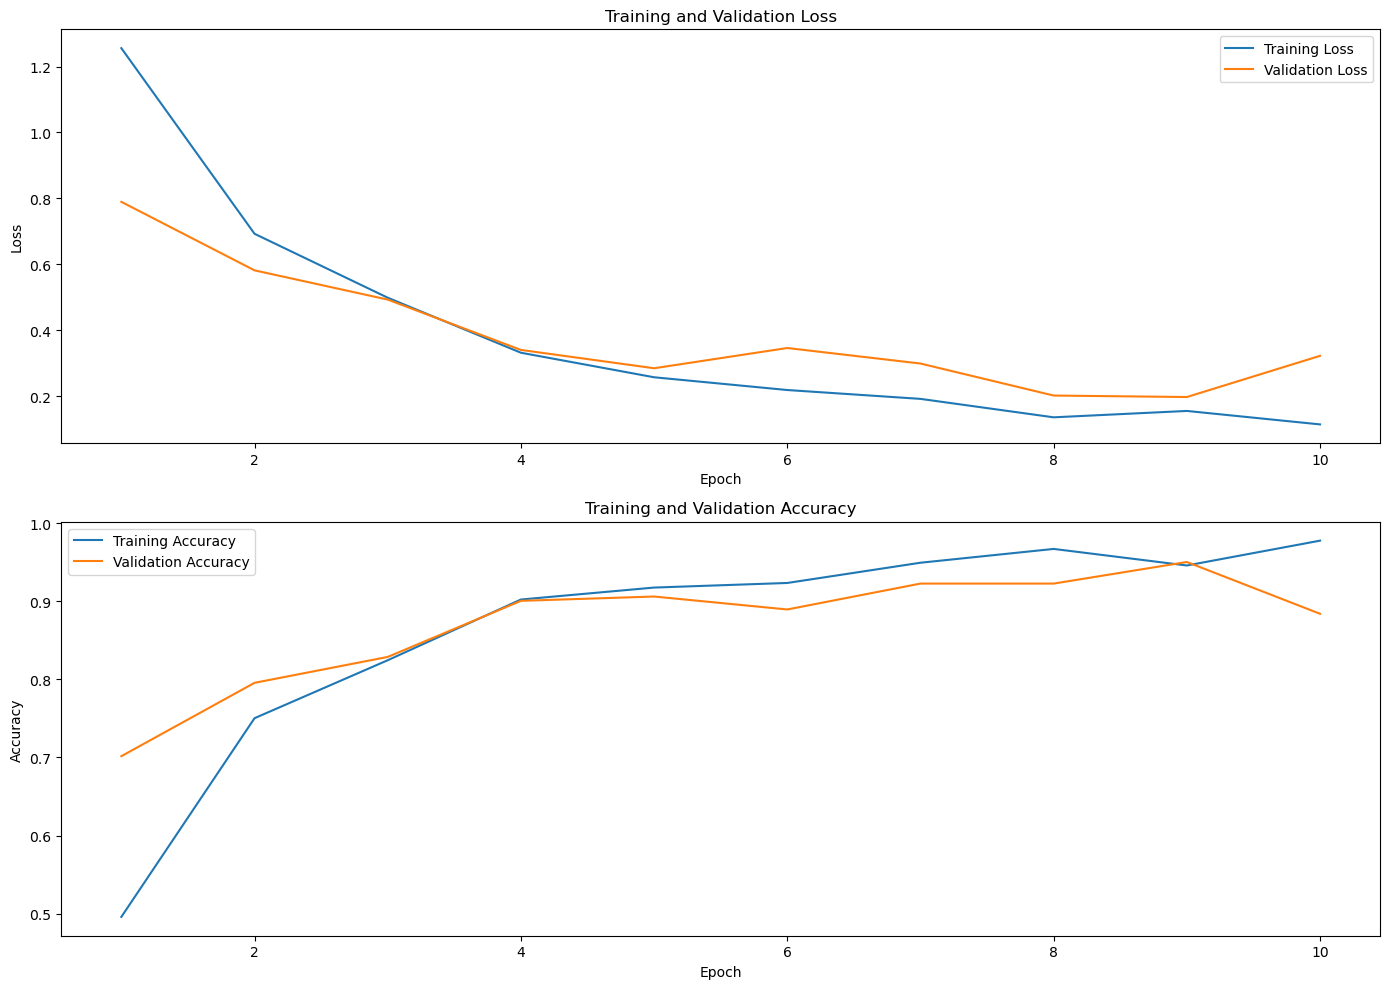

Test Loss: 0.34580974125613767, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 54
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.2921878865195646, Train Accuracy: 0.4711425206124853, Val Loss: 0.8642802238464355, Val Accuracy: 0.7071823204419889
Epoch 1, Train Loss: 0.7650471721534375, Train Accuracy: 0.7279151943462897, Val Loss: 0.6531100956102213, Val Accuracy: 0.7237569060773481
Epoch 2, Train Loss: 0.5772411874322979, Train Accuracy: 0.7832744405182568, Val Loss: 0.5599448333183924, Val Accuracy: 0.8066298342541437
Epoch 3, Train Loss: 0.4001062066742667, Train Accuracy: 0.8704358068315665, Val Loss: 0.39563360437750816, Val Accuracy: 0.8895027624309392
Epoch 4, Train Loss: 0.3111992555635947, Train Accuracy: 0.9045936395759717, Val Loss: 0.314513485878706, Val Accuracy: 0.90055248618784

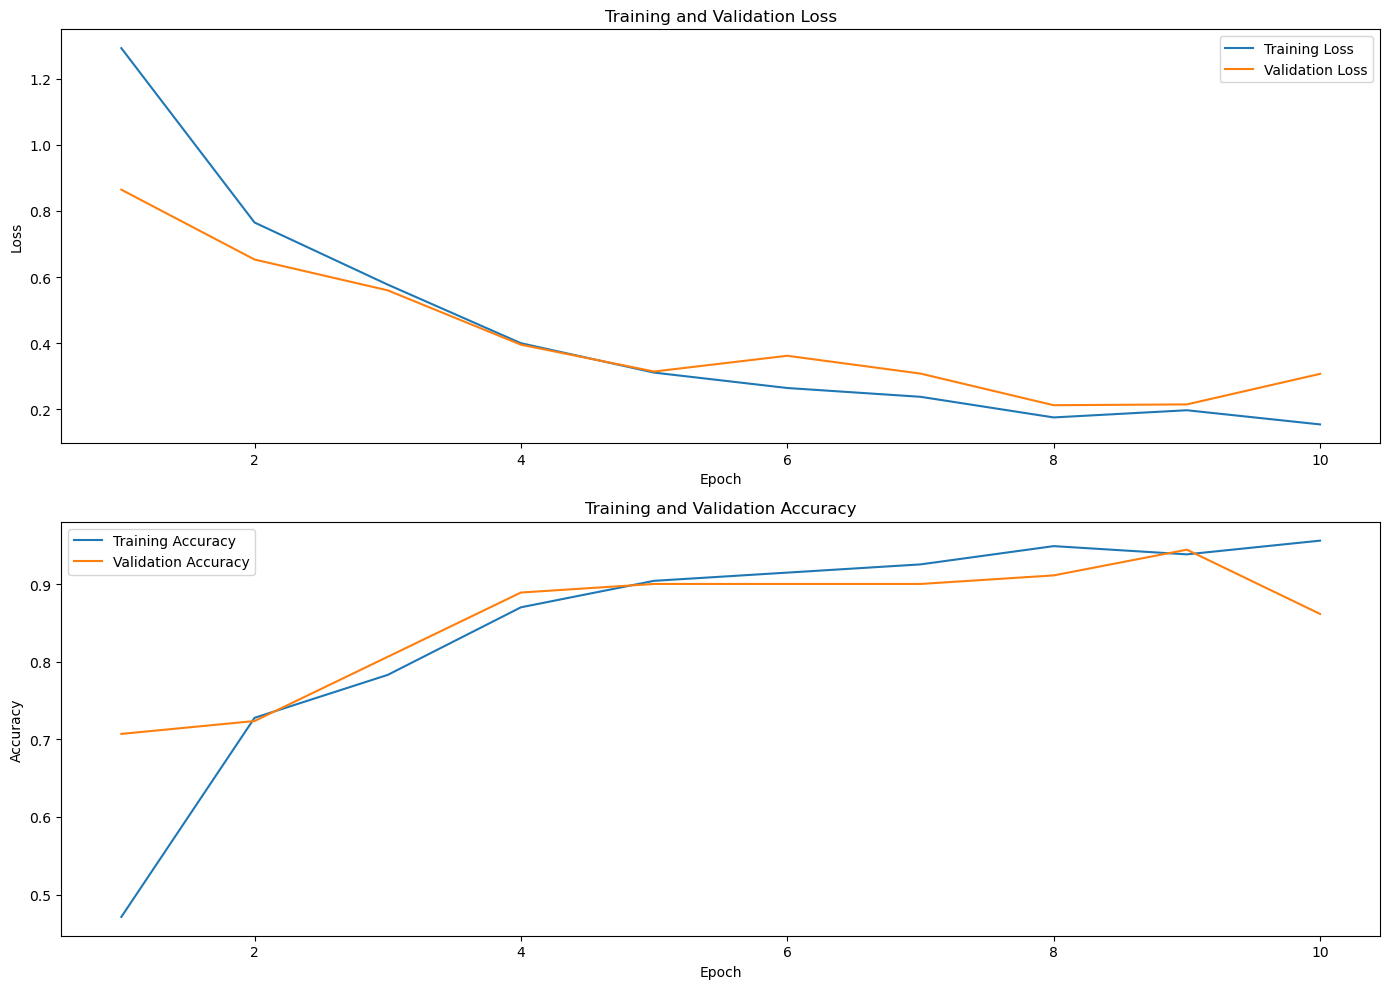

Test Loss: 0.34187891396383446, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 55
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.3768915252553091, Train Accuracy: 0.43580683156654887, Val Loss: 0.9183258463939031, Val Accuracy: 0.6629834254143646
Epoch 1, Train Loss: 0.8661012296323423, Train Accuracy: 0.6725559481743227, Val Loss: 0.6942926968137423, Val Accuracy: 0.712707182320442
Epoch 2, Train Loss: 0.6789462836804213, Train Accuracy: 0.7573616018845701, Val Loss: 0.5606739595532417, Val Accuracy: 0.8397790055248618
Epoch 3, Train Loss: 0.5028361851970354, Train Accuracy: 0.8244994110718492, Val Loss: 0.4442804728945096, Val Accuracy: 0.8674033149171271
Epoch 4, Train Loss: 0.4179246834030858, Train Accuracy: 0.8610129564193169, Val Loss: 0.3675735779106617, Val Accuracy: 0.88950276243093

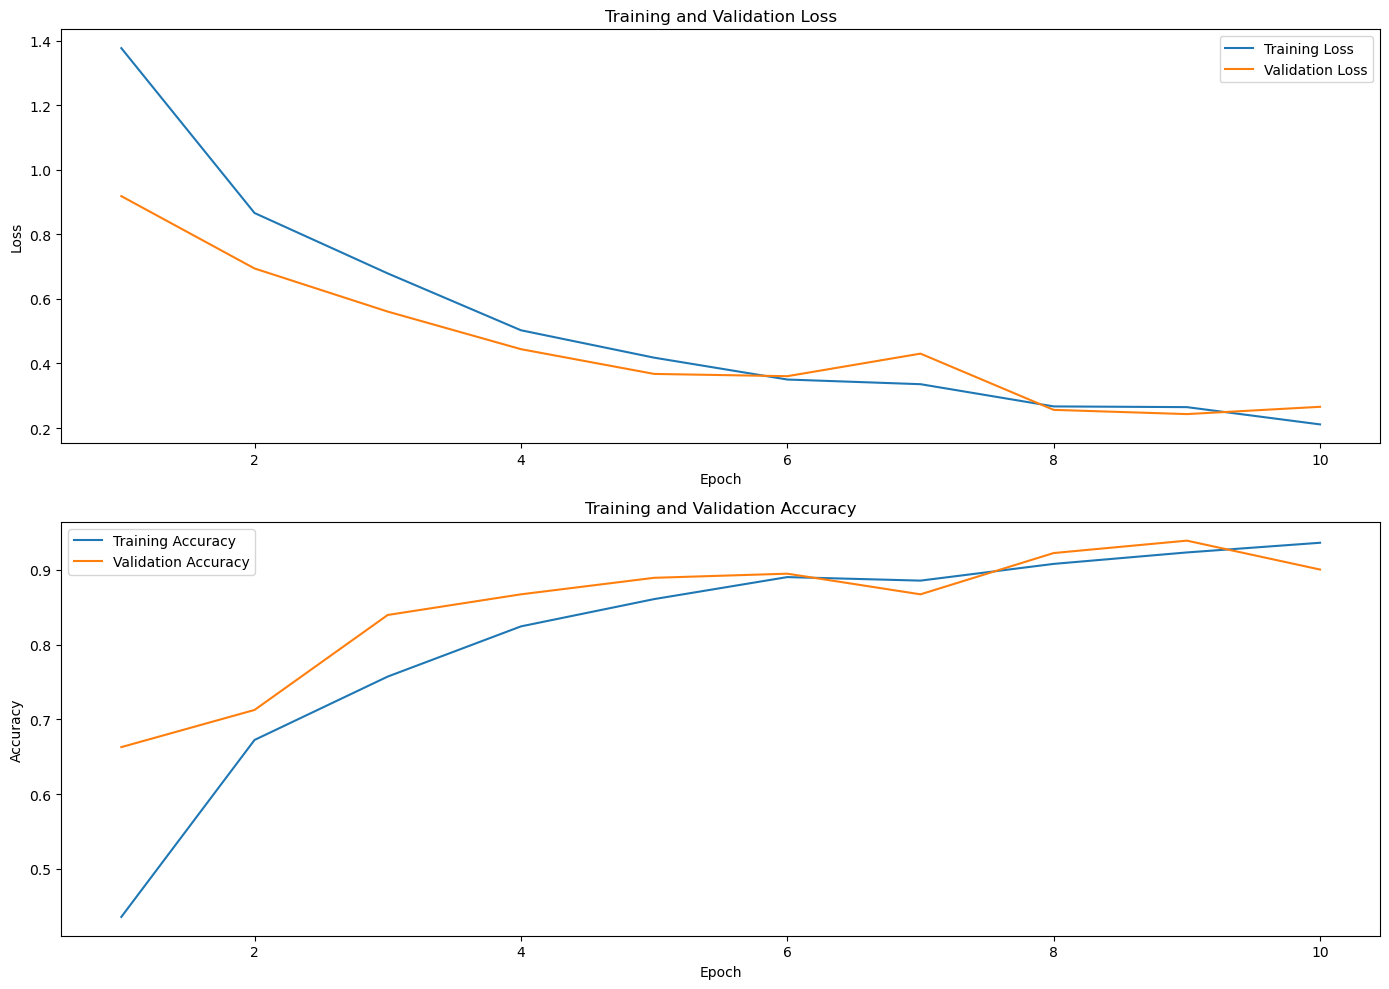

Test Loss: 0.3052269018565615, Test Accuracy: 0.8961748633879781
************************************************************************
************************************************************************
Experiment: 56
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.4977443245825943, Train Accuracy: 0.3934040047114252, Val Loss: 0.9701016843318939, Val Accuracy: 0.6629834254143646
Epoch 1, Train Loss: 1.0756017069021861, Train Accuracy: 0.5889281507656066, Val Loss: 0.7657571608821551, Val Accuracy: 0.7292817679558011
Epoch 2, Train Loss: 0.8801346542658629, Train Accuracy: 0.6772673733804476, Val Loss: 0.6244300752878189, Val Accuracy: 0.8342541436464088
Epoch 3, Train Loss: 0.7358295729176866, Train Accuracy: 0.7361601884570083, Val Loss: 0.5344223429759344, Val Accuracy: 0.8729281767955801
Epoch 4, Train Loss: 0.6326404271854295, Train Accuracy: 0.7703180212014135, Val Loss: 0.4757129003604253, Val Accuracy: 0.861878453038674

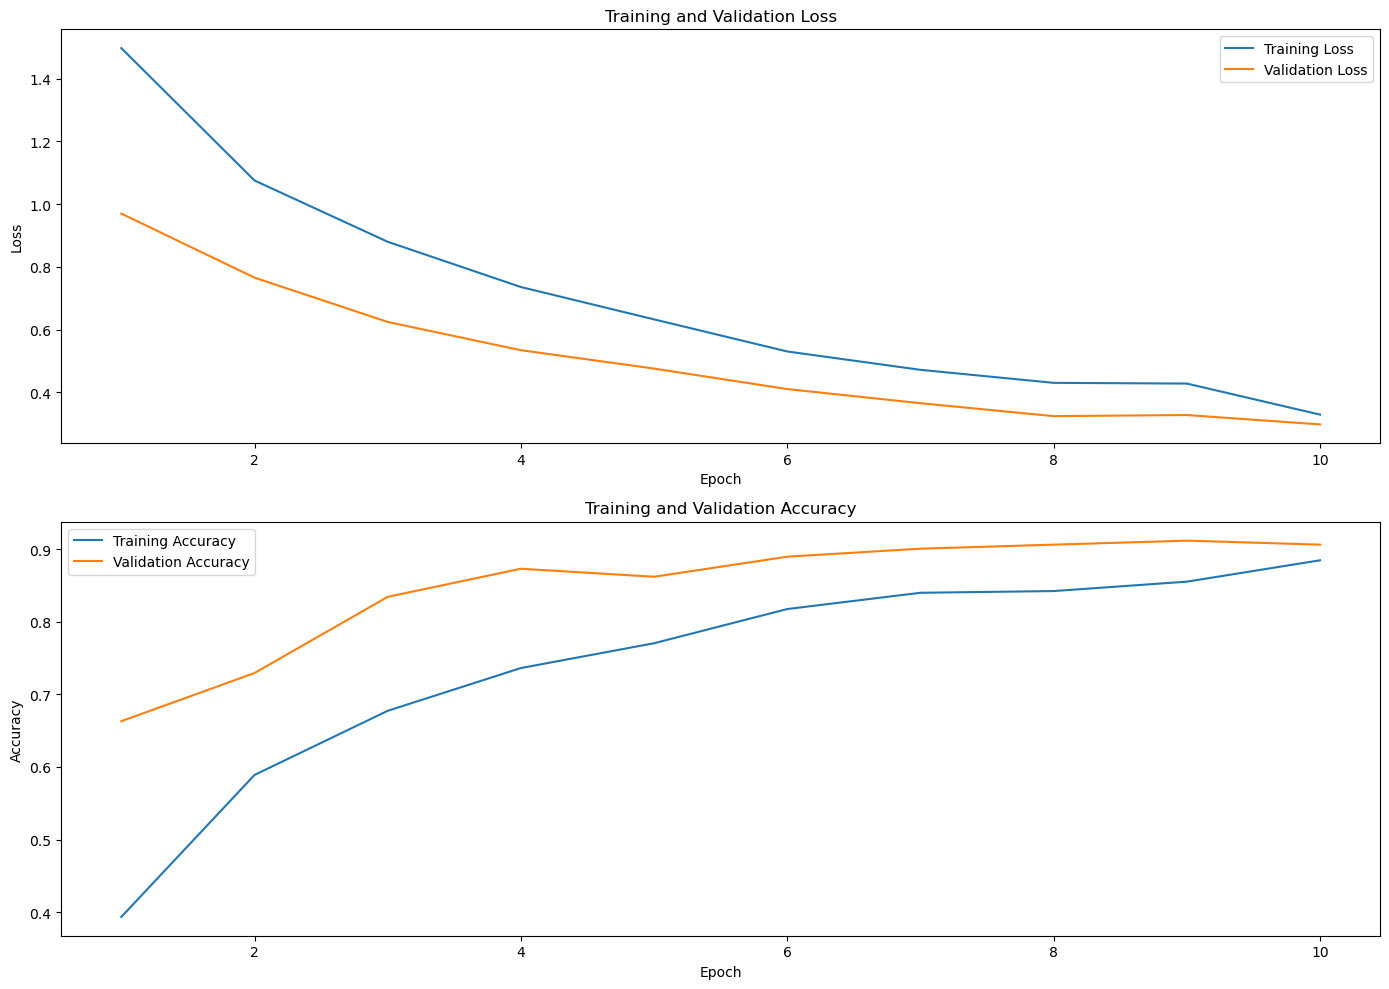

Test Loss: 0.34084503911435604, Test Accuracy: 0.8797814207650273
************************************************************************
************************************************************************
Experiment: 57
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512, 256]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.3754640144330483, Train Accuracy: 0.44876325088339225, Val Loss: 1.0751651177803676, Val Accuracy: 0.6187845303867403
Epoch 1, Train Loss: 0.9226879665145168, Train Accuracy: 0.6914016489988222, Val Loss: 0.7342074861129125, Val Accuracy: 0.7458563535911602
Epoch 2, Train Loss: 0.7018344322288478, Train Accuracy: 0.7620730270906949, Val Loss: 0.6286804402867953, Val Accuracy: 0.8011049723756906
Epoch 3, Train Loss: 0.5297033872317385, Train Accuracy: 0.8374558303886925, Val Loss: 0.3825554798046748, Val Accuracy: 0.8895027624309392
Epoch 4, Train Loss: 0.4184779221260989, Train Accuracy: 0.8716136631330977, Val Loss: 0.4124654208620389, Val Accuracy: 0.872928176

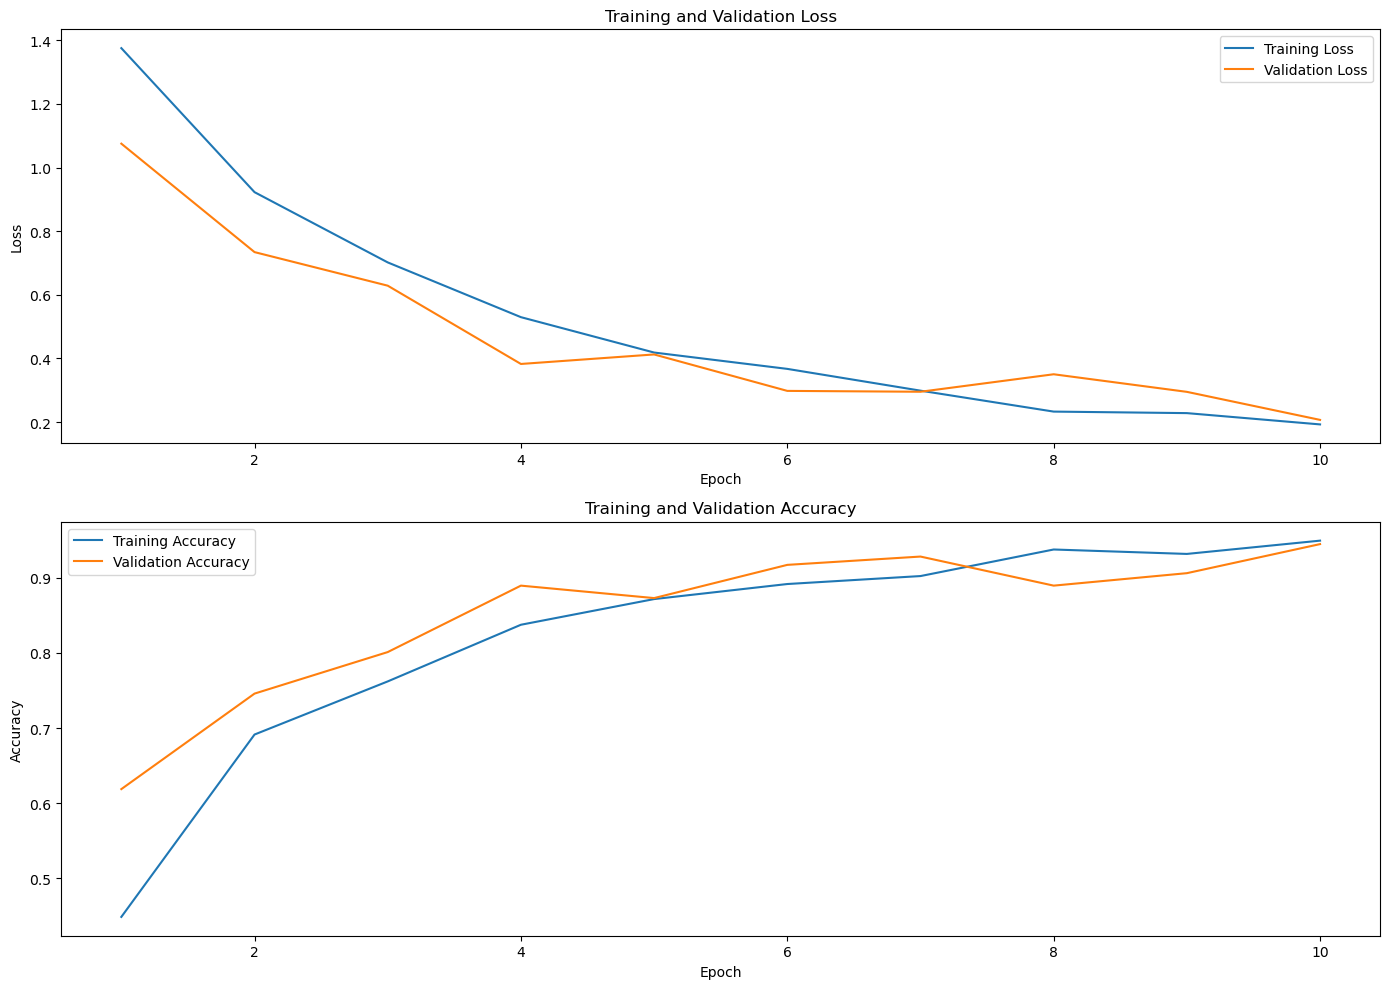

Test Loss: 0.2207348228742679, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 58
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512, 256]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.4709555445997804, Train Accuracy: 0.36395759717314485, Val Loss: 1.1879457533359528, Val Accuracy: 0.6795580110497238
Epoch 1, Train Loss: 1.1279855955530096, Train Accuracy: 0.585394581861013, Val Loss: 0.8966636955738068, Val Accuracy: 0.6961325966850829
Epoch 2, Train Loss: 0.9174401903593982, Train Accuracy: 0.6525323910482921, Val Loss: 0.7318652321894964, Val Accuracy: 0.7569060773480663
Epoch 3, Train Loss: 0.7416495995389091, Train Accuracy: 0.7502944640753828, Val Loss: 0.5244473094741503, Val Accuracy: 0.856353591160221
Epoch 4, Train Loss: 0.6285939282841153, Train Accuracy: 0.7868080094228505, Val Loss: 0.5041847204168638, Val Accuracy: 0.867403314917

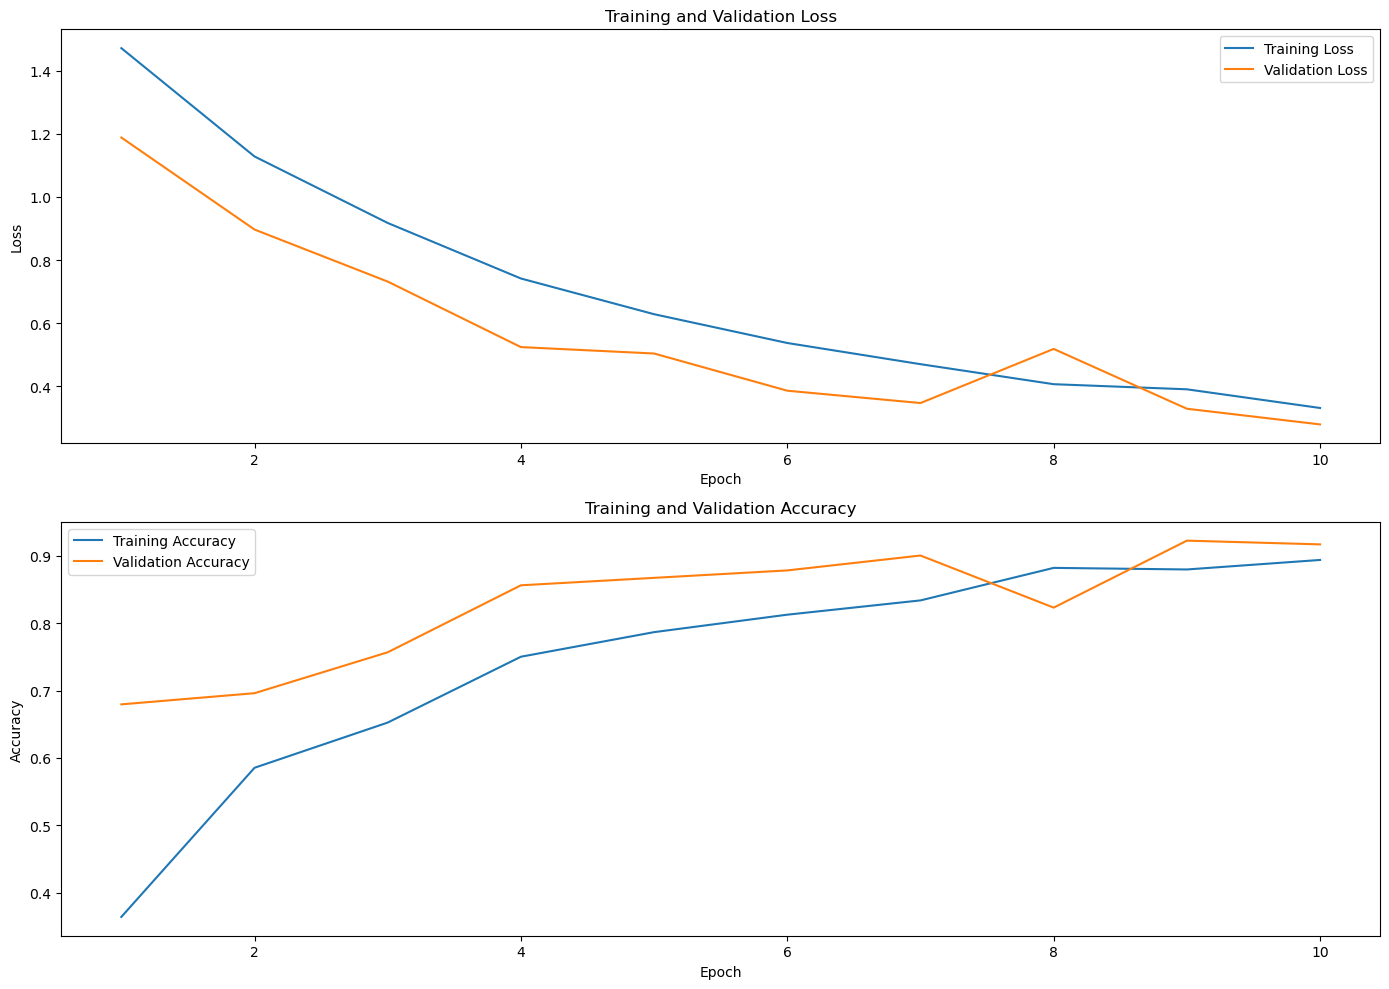

Test Loss: 0.3191821053624153, Test Accuracy: 0.9016393442622951
************************************************************************
************************************************************************
Experiment: 59
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512, 256]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.563956559808166, Train Accuracy: 0.2791519434628975, Val Loss: 1.3923165102799733, Val Accuracy: 0.574585635359116
Epoch 1, Train Loss: 1.3669749708087355, Train Accuracy: 0.4381625441696113, Val Loss: 1.1206632157166798, Val Accuracy: 0.6243093922651933
Epoch 2, Train Loss: 1.2340389611544433, Train Accuracy: 0.4958775029446408, Val Loss: 0.9685280919075012, Val Accuracy: 0.7734806629834254
Epoch 3, Train Loss: 1.0738673905531566, Train Accuracy: 0.5865724381625441, Val Loss: 0.7948806087176005, Val Accuracy: 0.7955801104972375
Epoch 4, Train Loss: 0.9682153165340424, Train Accuracy: 0.6501766784452296, Val Loss: 0.7629118810097376, Val Accuracy: 0.7845303867403

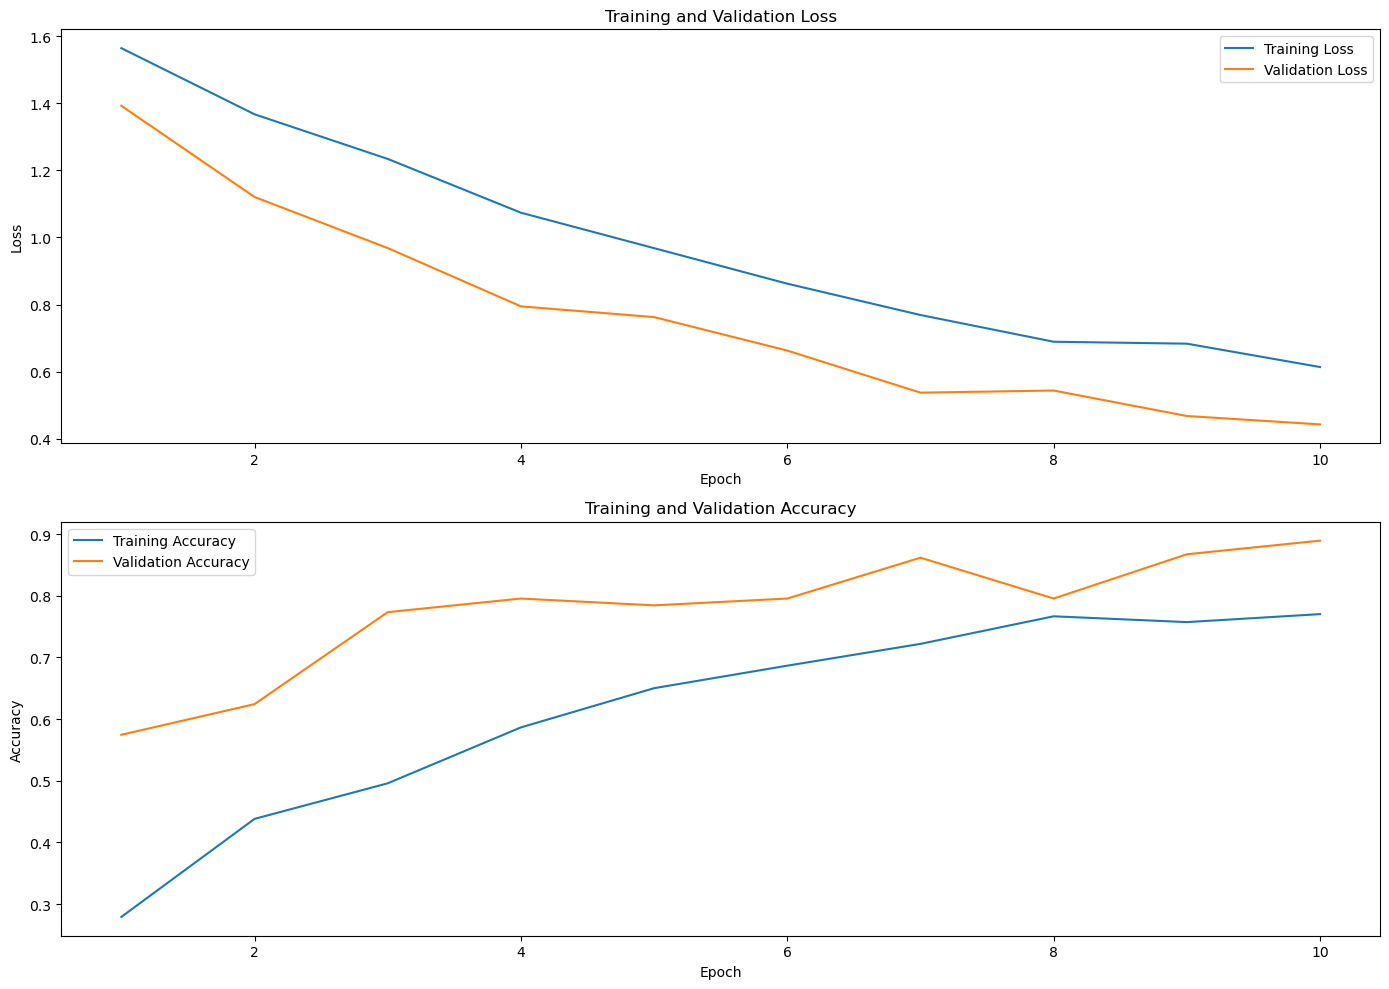

Test Loss: 0.5025827263792356, Test Accuracy: 0.8415300546448088
************************************************************************
************************************************************************
Experiment: 60
batch_size= 16
learning_rate= 5e-05
hidden_layers= [512, 256]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.6856311824586656, Train Accuracy: 0.23439340400471143, Val Loss: 1.515920917193095, Val Accuracy: 0.3314917127071823
Epoch 1, Train Loss: 1.6023299407075953, Train Accuracy: 0.2850412249705536, Val Loss: 1.4254373212655385, Val Accuracy: 0.6243093922651933
Epoch 2, Train Loss: 1.5622656058382105, Train Accuracy: 0.30742049469964666, Val Loss: 1.368144303560257, Val Accuracy: 0.6850828729281768
Epoch 3, Train Loss: 1.4670837764386777, Train Accuracy: 0.38869257950530034, Val Loss: 1.2790167431036632, Val Accuracy: 0.7182320441988951
Epoch 4, Train Loss: 1.3902396537639476, Train Accuracy: 0.4193168433451119, Val Loss: 1.1856465637683868, Val Accuracy: 0.6961325966

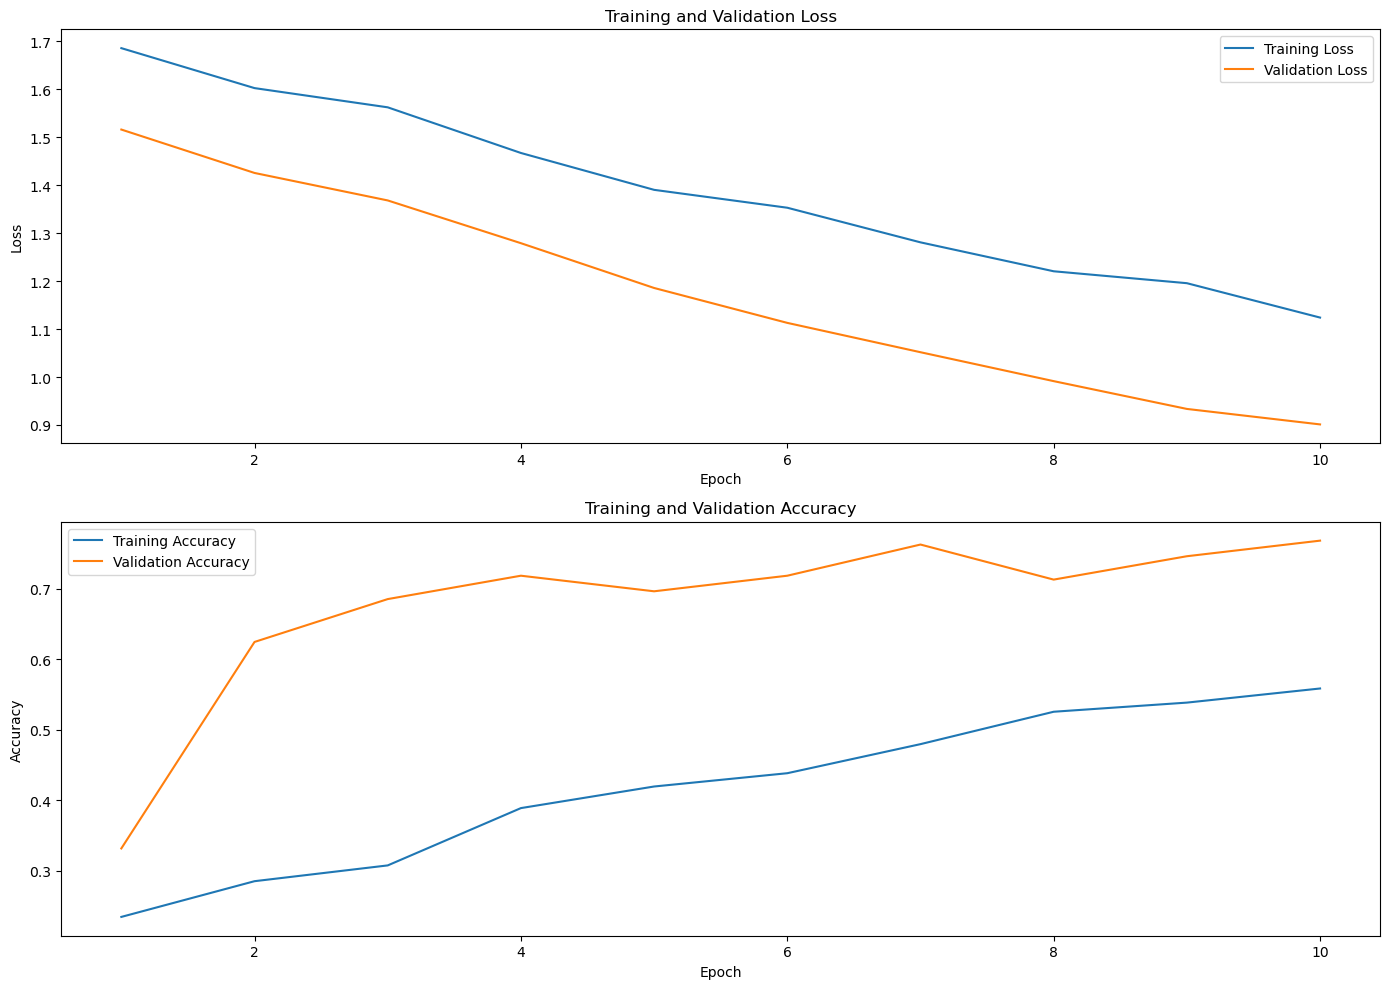

Test Loss: 0.907484382390976, Test Accuracy: 0.7158469945355191
************************************************************************
************************************************************************
Experiment: 61
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024, 512]
dropout_rate= 0.1
Epoch 0, Train Loss: 1.3395592879365992, Train Accuracy: 0.45229681978798586, Val Loss: 0.9498854825894038, Val Accuracy: 0.6574585635359116
Epoch 1, Train Loss: 0.8033667405446371, Train Accuracy: 0.7408716136631331, Val Loss: 0.731754961113135, Val Accuracy: 0.7513812154696132
Epoch 2, Train Loss: 0.5719328257772658, Train Accuracy: 0.8150765606595995, Val Loss: 0.6266671866178513, Val Accuracy: 0.7237569060773481
Epoch 3, Train Loss: 0.43657134666487024, Train Accuracy: 0.8645465253239105, Val Loss: 0.3845592811703682, Val Accuracy: 0.8674033149171271
Epoch 4, Train Loss: 0.36420387043445196, Train Accuracy: 0.8928150765606596, Val Loss: 0.37391751011212665, Val Accuracy: 0.82320441

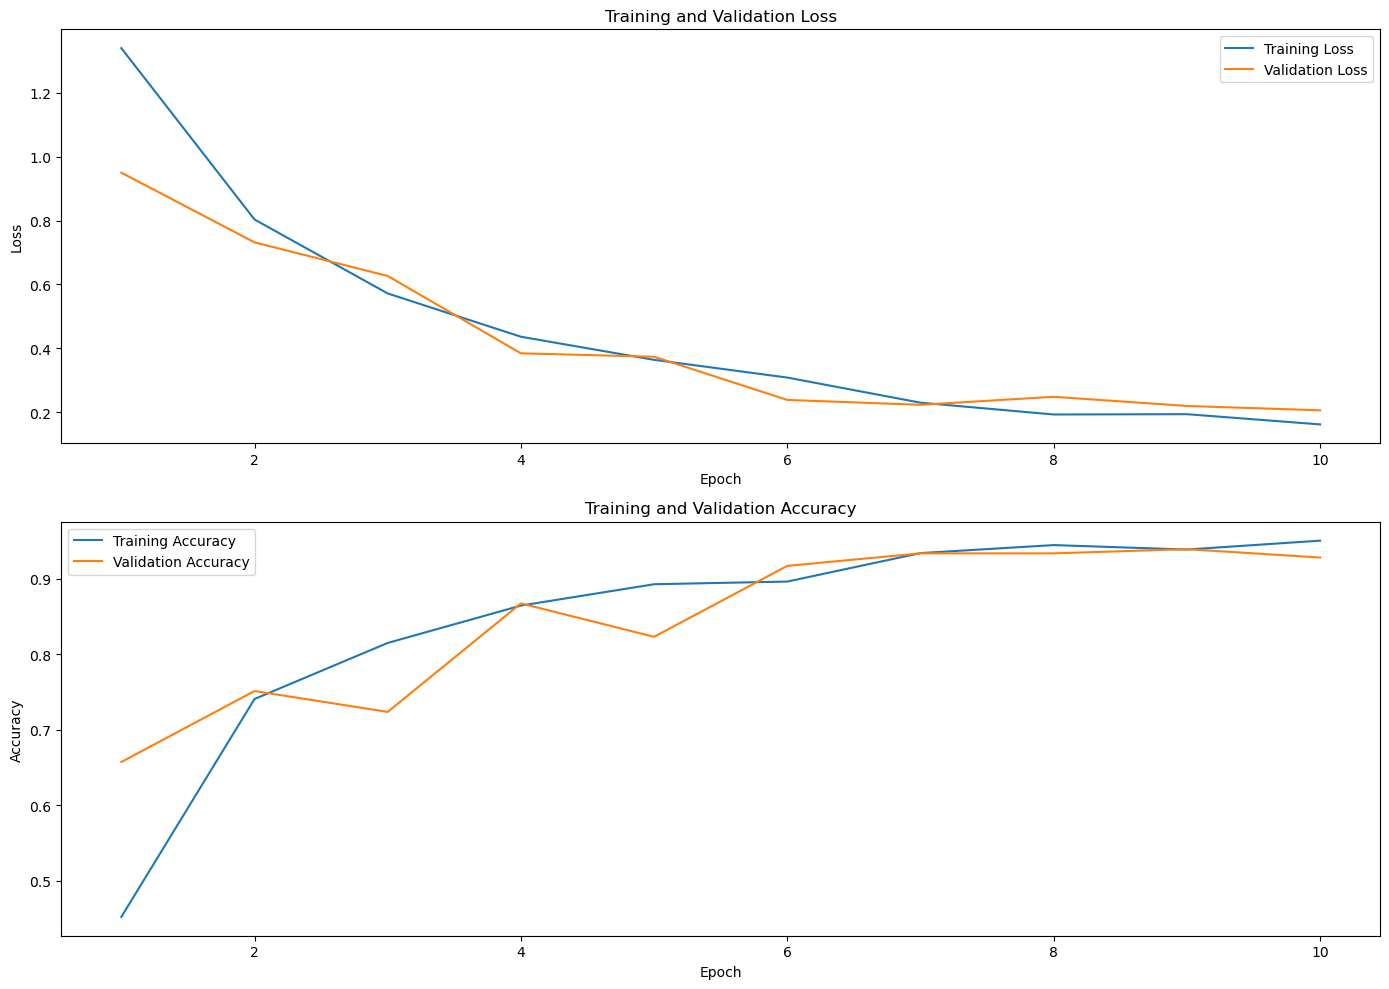

Test Loss: 0.20662409625947475, Test Accuracy: 0.9289617486338798
************************************************************************
************************************************************************
Experiment: 62
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024, 512]
dropout_rate= 0.3
Epoch 0, Train Loss: 1.4197175679383454, Train Accuracy: 0.4122497055359246, Val Loss: 1.1038923511902492, Val Accuracy: 0.585635359116022
Epoch 1, Train Loss: 0.970641994089992, Train Accuracy: 0.6466431095406361, Val Loss: 0.8162394960721334, Val Accuracy: 0.7348066298342542
Epoch 2, Train Loss: 0.7518162379662195, Train Accuracy: 0.7314487632508834, Val Loss: 0.647270048658053, Val Accuracy: 0.7403314917127072
Epoch 3, Train Loss: 0.6073863765707722, Train Accuracy: 0.8021201413427562, Val Loss: 0.4748646691441536, Val Accuracy: 0.856353591160221
Epoch 4, Train Loss: 0.5074535597253729, Train Accuracy: 0.8433451118963486, Val Loss: 0.430992944786946, Val Accuracy: 0.82320441988950

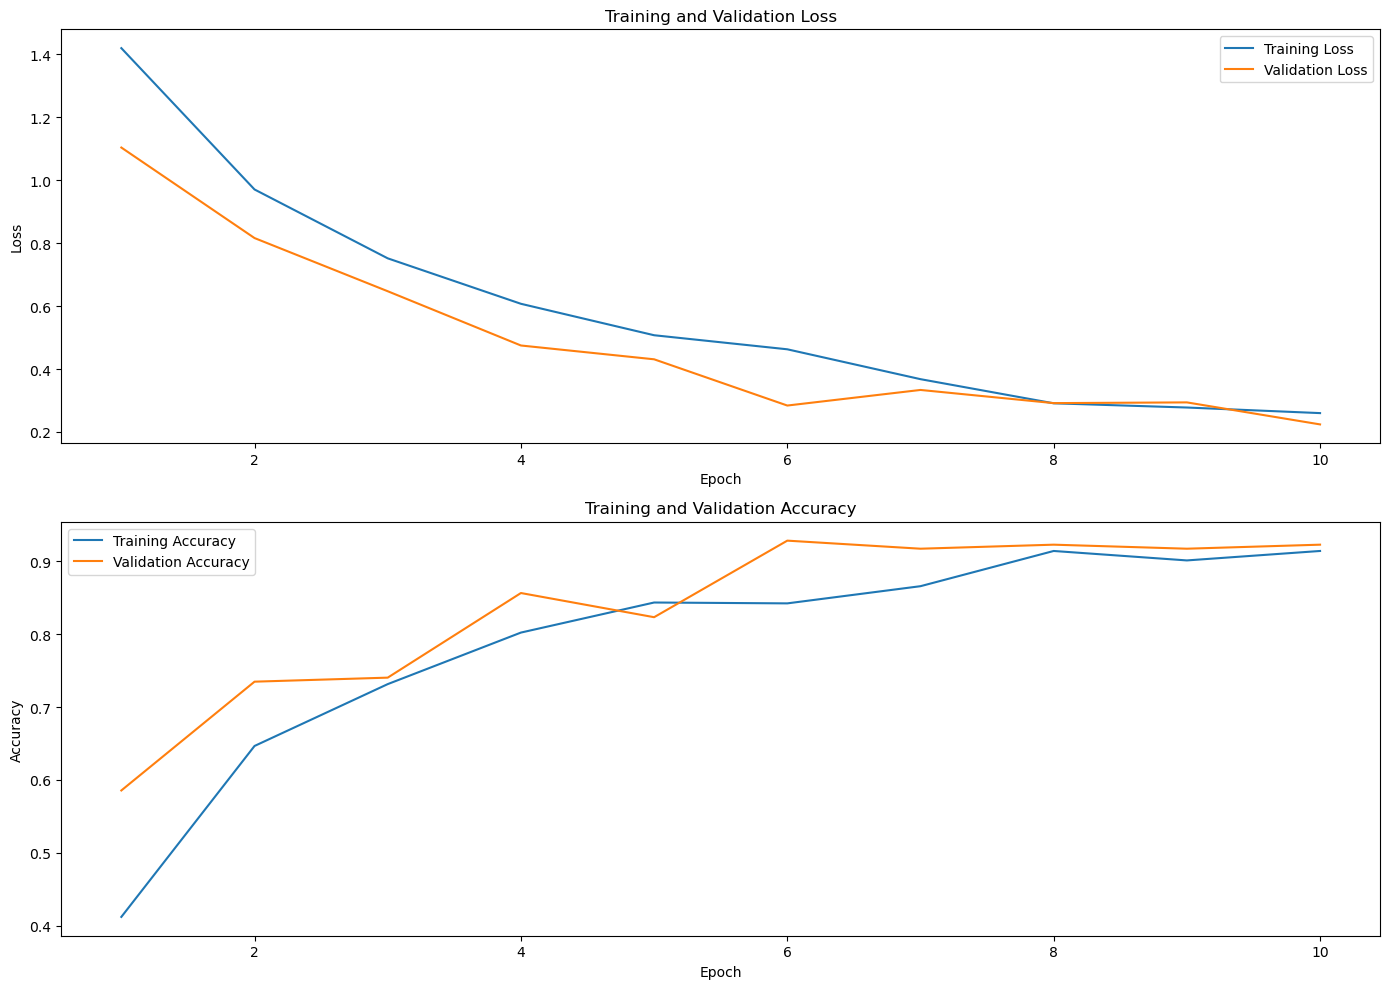

Test Loss: 0.23050122149288654, Test Accuracy: 0.9234972677595629
************************************************************************
************************************************************************
Experiment: 63
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024, 512]
dropout_rate= 0.5
Epoch 0, Train Loss: 1.5283010381239432, Train Accuracy: 0.32744405182567726, Val Loss: 1.3024325370788574, Val Accuracy: 0.4861878453038674
Epoch 1, Train Loss: 1.2260827568394166, Train Accuracy: 0.49823321554770317, Val Loss: 1.0124845554431279, Val Accuracy: 0.6850828729281768
Epoch 2, Train Loss: 1.0534580305770591, Train Accuracy: 0.6089517078916372, Val Loss: 0.8163312822580338, Val Accuracy: 0.7348066298342542
Epoch 3, Train Loss: 0.8637501028952775, Train Accuracy: 0.6878680800942285, Val Loss: 0.6468330870072047, Val Accuracy: 0.8121546961325967
Epoch 4, Train Loss: 0.8072199308209949, Train Accuracy: 0.71849234393404, Val Loss: 0.5619260196884474, Val Accuracy: 0.817679558

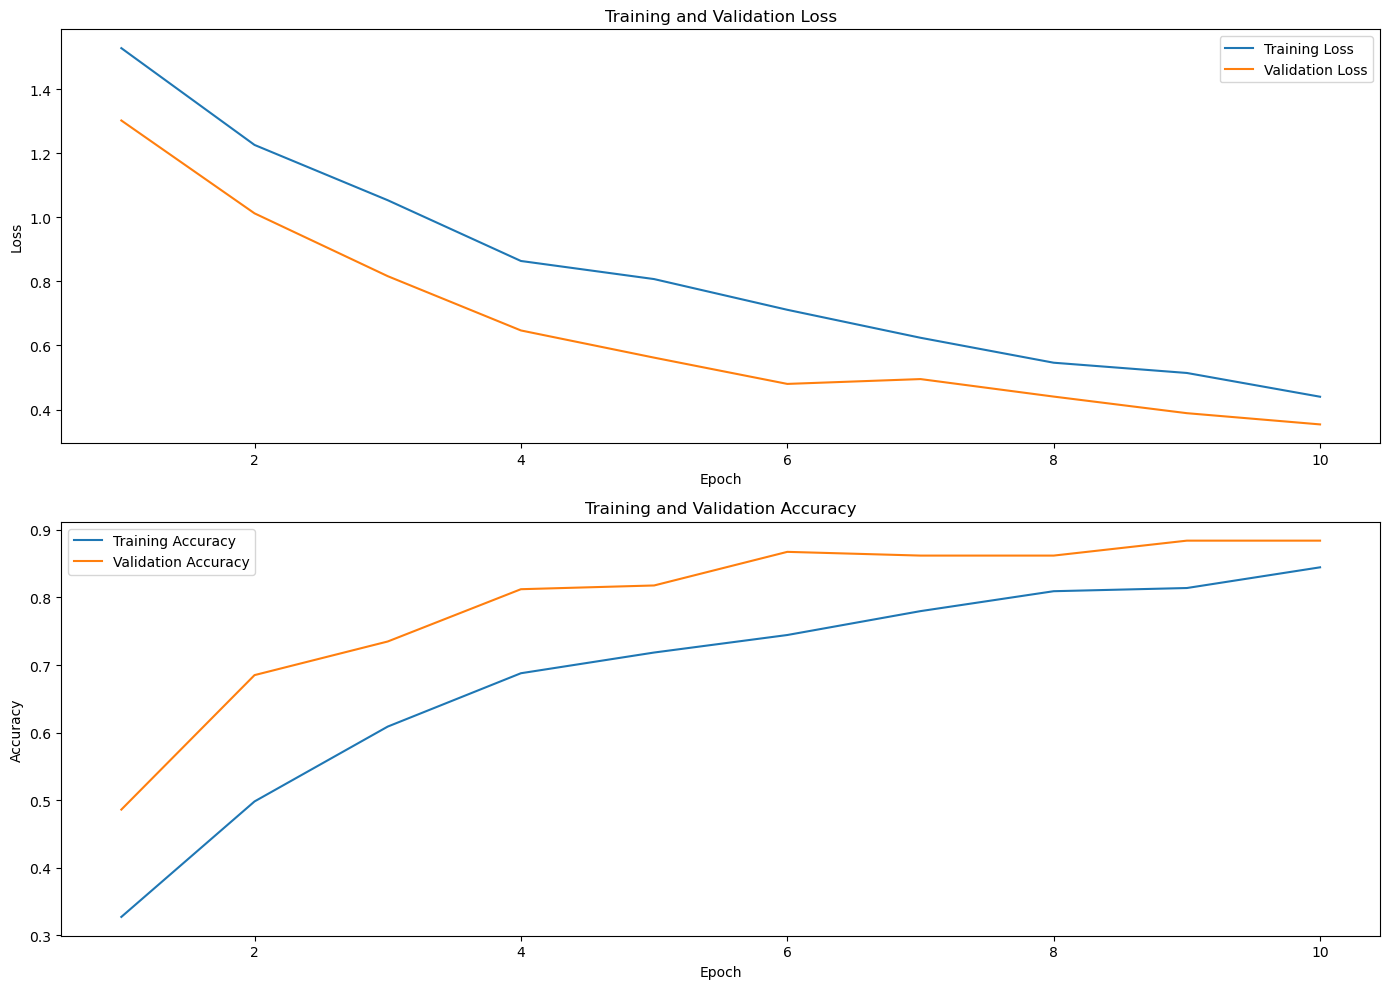

Test Loss: 0.35482439150412876, Test Accuracy: 0.8688524590163934
************************************************************************
************************************************************************
Experiment: 64
batch_size= 16
learning_rate= 5e-05
hidden_layers= [1024, 512]
dropout_rate= 0.7
Epoch 0, Train Loss: 1.7113050200321056, Train Accuracy: 0.24499411071849234, Val Loss: 1.4591521322727203, Val Accuracy: 0.5359116022099447
Epoch 1, Train Loss: 1.5948659932171856, Train Accuracy: 0.2968197879858657, Val Loss: 1.3647561967372894, Val Accuracy: 0.5966850828729282
Epoch 2, Train Loss: 1.453157020939721, Train Accuracy: 0.39693757361601884, Val Loss: 1.1984337468942006, Val Accuracy: 0.6519337016574586
Epoch 3, Train Loss: 1.3670450890505756, Train Accuracy: 0.42285041224970554, Val Loss: 1.1029142638047535, Val Accuracy: 0.7348066298342542
Epoch 4, Train Loss: 1.3334682208520394, Train Accuracy: 0.48527679623085984, Val Loss: 0.9885567178328832, Val Accuracy: 0.712707

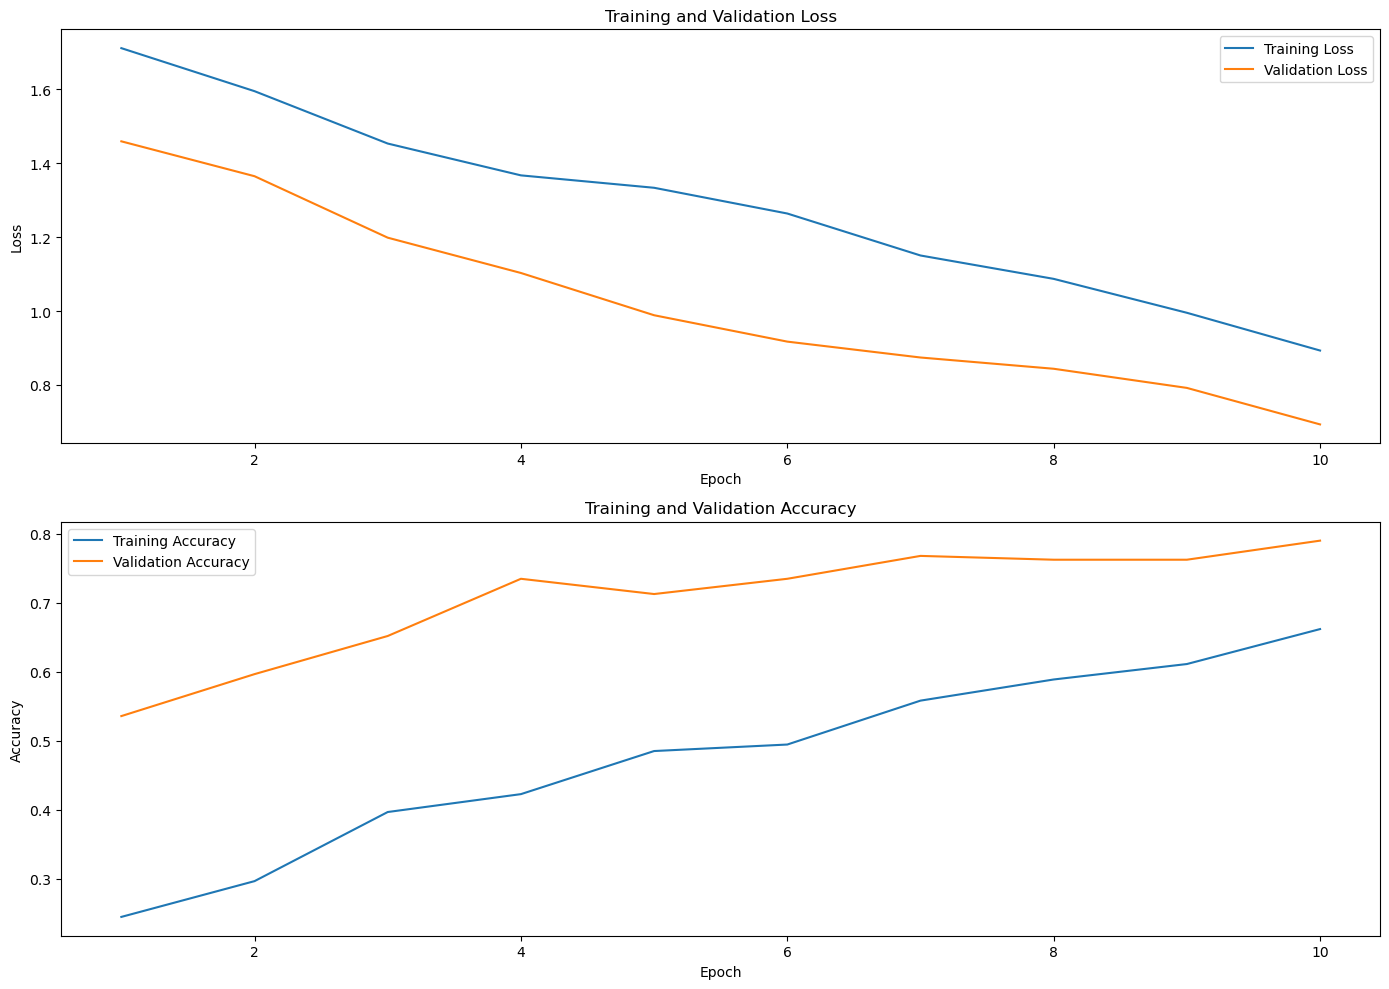

Test Loss: 0.7062273994088173, Test Accuracy: 0.7595628415300546


In [12]:
import itertools

# Define your hyperparameters to test

learning_rates = [0.001, 0.0005, 0.0001, 0.00005]
hidden_layers_options = [[512], [1024], [512, 256], [1024, 512]]
dropout_rates = [0.1, 0.3, 0.5, 0.7]

# Create a cartesian product of all hyperparameters
all_combinations = list(itertools.product(learning_rates, hidden_layers_options, dropout_rates))

# Iterate over each combination and run the experiment
i=1
for combination in all_combinations:
    learning_rate, hidden_layers, dropout_rate = combination

    config = {
    "data_path": "data",
    "batch_size": 16,
    "learning_rate": learning_rate,
    "epochs": 10,
    "model": "AlexNet",
    'input_features': 9216,
    'hidden_layers': hidden_layers,
    'output_classes': 5,
    'dropout_rate': dropout_rate,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
    }
    print("************************************************************************")
    print("************************************************************************")
    print("Experiment:",i)
    print("batch_size=", batch_size)
    print("learning_rate=", learning_rate)
    print("hidden_layers=", hidden_layers)
    print("dropout_rate=", dropout_rate)
    i=i+1
    run_experiment(config)


# transforms: 
Preprocessing steps applied to the data before it enters the network. These can include normalization, scaling, cropping, and flipping images.
Normalization: Normalizing inputs or activations (batch normalization) helps in speeding up the training and provides regularization effects.
# AlexNet: 
optimizer: An algorithm or method used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses. Responsible for updating the model parameters using the computed gradients

The function freeze_model_parameters is designed to iterate through all the parameters of a given model and set their requires_grad attribute to False. This is a common practice when you're fine-tuning a pre-trained model and you want to keep the weights of certain layers fixed, meaning that no gradient will be computed for them during backpropagation. Consequently, these parameters will not be updated during the training process.

# Regularization: 
Techniques like Dropout are used to prevent overfitting in neural networks, which ensures the model generalizes well on unseen data. 
Dropout: A regularization technique that involves randomly setting a fraction of input units to 0 at each update during training to prevent overfitting.
You can prevent overfitting also by choose the number of epochs.
also by:
Training loss must be higher then the validation loss.
Validation accurecy must be higher then training accurecy.

# ReLU: 
A common activation function that allows models to solve non-linear problems.

# LogSoftmax:
A function that applies the logarithm after the softmax transformation to the output layer, used in multi-class classification problems.
# loss function:
A function that the model aims to minimize during training, which measures the difference between the actual and predicted outputs.
training & validation loss: Metrics that indicate how well the model is learning; training loss is calculated on the training set, and validation loss is calculated on a set not seen by the model during training.
learning rate: A hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


# forward & backward:
Forward refers to the computation of output values from inputs, and backward refers to backpropagation, where gradients are computed for learning.
# zero grad: 
Resets the gradients of the model parameters, necessary because gradients accumulate by default in PyTorch.
# epochs: 
One epoch represents one complete pass of the training dataset through the network.
batch size: The number of training examples utilized in one iteration.